# Machine learning - Coursework 2

## Predicting Pediatric Appendicitis Diagnosis and Severity Using Clinical Data

**Author:** *Eoin Houstoun*  
**Affiliation:** Department of Computing, Goldsmiths, University of London  
**Email:** ehous001@gold.ac.uk
_______

<img src="https://st2.depositphotos.com/2852841/5872/v/450/depositphotos_58724665-stock-illustration-appendicitis.jpg" alt="Monte Carlo CV Pipeline" width="600">

**Interpretable and Intervenable Ultrasonography-based Machine Learning Models for Pediatric Appendicitis**  
*Ričards Marcinkevičs & et al, Published in Medical Image Analysis 2023*  
[Introductory Paper](https://arxiv.org/abs/2302.14460v2)



### Objective
This project aims to predict:
1. **Diagnosis**: Whether a pediatric patient has appendicitis
2. **Severity**: Whether the appendicitis is uncomplicated or complicated

using only **structured clinical, laboratory, and ultrasound-derived tabular features**, excluding raw ultrasound images.

> Uncomplicated Appendicitis includes subacute/catarrhal inflammation and fibrosis and complicated Appendicitis includes phlegmonous, gangrenous, perforated, or abscessed forms.

### Dataset
The project uses the [Regensburg Pediatric Appendicitis Dataset](https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis), which contains data from **782 pediatric patients** aged 0-18.

Predictor variables:
- Demographics (age, sex, BMI)
- Clinical scores (e.g. Alvarado, Pediatric Appendicitis Score)
- Physical signs and symptoms (e.g. rebound tenderness, nausea)
- Lab values (e.g. WBC, CRP, hemoglobin)
- Sonographic findings (e.g. appendix diameter, free fluids)

Outcome variables:
- `Diagnosis`: appendicitis vs. no appendicitis
- `Severity`: uncomplicated vs. complicated


The data used in this project comes from a retrospective study conducted at the Children's Hospital St. Hedwig in Regensburg, Germany ([Interpretable and Intervenable Ultrasonography-based Machine Learning Models for Pediatric Appendicitis, Ričards Marcinkevičs & et al, Published in Medical Image Analysis 2023](https://arxiv.org/abs/2302.14460v2)). It includes pediatric patients who were admitted with abdominal pain. For most patients, multiple abdominal ultrasound images were captured, focusing on areas such as the appendix, intestines, lymph nodes, and reproductive organs.

In addition to the ultrasound images, the dataset contains structured clinical information, including laboratory test results, physical examination findings, and clinical scores like the Alvarado and Pediatric Appendicitis Score.

The study received ethical approval from the University of Regensburg and was conducted in accordance with relevant medical research guidelines.



# Libraries

In [10]:
# Numerical & Data Manipulation
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import t

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.ticker as mtick
from tabulate import tabulate
from tqdm import trange


# Scikit-learn - Preprocessing & Pipelines
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Scikit-learn - Imputation
from sklearn.impute import KNNImputer

# Scikit-learn - Model Selection
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold,
    ParameterGrid, cross_val_score
)

# Scikit-learn - Classification Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Scikit-learn - Regression Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Scikit-learn - Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, precision_recall_curve, roc_curve,
    mean_squared_error, mean_absolute_error,root_mean_squared_error, r2_score,
    make_scorer, classification_report
)
from sklearn.calibration import calibration_curve

# XGBoost
from xgboost import XGBClassifier, XGBRegressor

# Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

# General Utilities
import os
import re
import warnings
from collections import defaultdict, Counter

# Google Drive (Colab Only)
from google.colab import drive
drive.mount('/content/drive')

# Paths for saving results
save_path_c_f = "/content/drive/MyDrive/Colab Notebooks/ML/CW2/RESULTS/CLASSIFICATION/DIAG"
save_path_c_m = "/content/drive/MyDrive/Colab Notebooks/ML/CW2/RESULTS/CLASSIFICATION/SEVERITY"


# Suppress Warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1. DATASET EXPLORATION**

In [2]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# fetch dataset
regensburg_pediatric_appendicitis = fetch_ucirepo(id=938)

# data (as pandas dataframes)
X = regensburg_pediatric_appendicitis.data.features
y = regensburg_pediatric_appendicitis.data.targets

# metadata
print(regensburg_pediatric_appendicitis.metadata)

# variable information
regensburg_pediatric_appendicitis.variables


{'uci_id': 938, 'name': 'Regensburg Pediatric Appendicitis', 'repository_url': 'https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis', 'data_url': 'https://archive.ics.uci.edu/static/public/938/data.csv', 'abstract': 'This repository holds the data from a cohort of pediatric patients with suspected appendicitis admitted with abdominal pain to Children’s Hospital St. Hedwig in Regensburg, Germany, between 2016 and 2021. Each patient has (potentially multiple) ultrasound (US) images, aka views, tabular data comprising laboratory, physical examination, scoring results and ultrasonographic findings extracted manually by the experts, and three target variables, namely, diagnosis, management and severity.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Image'], 'num_instances': 782, 'num_features': 53, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': ['Age', 'Sex'], 'target_col': ['Management', 'Severity',

name     role         type demographic  \
0                                Age  Feature   Continuous         Age   
1                                BMI  Feature   Continuous        None   
2                                Sex  Feature  Categorical         Sex   
3                             Height  Feature   Continuous        None   
4                             Weight  Feature      Integer        None   
5                     Length_of_Stay  Feature      Integer        None   
6                         Management   Target  Categorical        None   
7                           Severity   Target  Categorical        None   
8              Diagnosis_Presumptive    Other       Binary        None   
9                          Diagnosis   Target       Binary        None   
10                    Alvarado_Score  Feature      Integer        None   
11     Paedriatic_Appendicitis_Score  Feature      Integer        None   
12                    Appendix_on_US  Feature       Binary        None   
13                 Appendix_Diameter  Feature      Integer        None   
14                    Migratory_Pain  Feature       Binary        None   
15              Lower_Right_Abd_Pain  Feature       Binary        None   
16  Contralateral_Rebound_Tenderness  Feature       Binary        None   
17                     Coughing_Pain  Feature       Binary        None   
18                            Nausea  Feature       Binary        None   
19                  Loss_of_Appetite  Feature       Binary        None   
20                  Body_Temperature  Feature   Continuous        None   
21                         WBC_Count  Feature   Continuous        None   
22             Neutrophil_Percentage  Feature      Integer        None   
23             Segmented_Neutrophils  Feature      Integer        None   
24                      Neutrophilia  Feature  Categorical        None   
25                         RBC_Count  Feature   Continuous        None   
26                        Hemoglobin  Feature   Continuous        None   
27                               RDW  Feature   Continuous        None   
28                 Thrombocyte_Count  Feature      Integer        None   
29                  Ketones_in_Urine  Feature  Categorical        None   
30                      RBC_in_Urine  Feature  Categorical        None   
31                      WBC_in_Urine  Feature  Categorical        None   
32                               CRP  Feature      Integer        None   
33                           Dysuria  Feature       Binary        None   
34                             Stool  Feature  Categorical        None   
35                       Peritonitis  Feature  Categorical        None   
36                        Psoas_Sign  Feature  Categorical        None   
37    Ipsilateral_Rebound_Tenderness  Feature  Categorical        None   
38                      US_Performed  Feature  Categorical        None   
39                         US_Number    Other      Integer        None   
40                       Free_Fluids  Feature  Categorical        None   
41              Appendix_Wall_Layers  Feature  Categorical        None   
42                       Target_Sign  Feature  Categorical        None   
43                     Appendicolith  Feature  Categorical        None   
44                         Perfusion  Feature  Categorical        None   
45                       Perforation  Feature  Categorical        None   
46       Surrounding_Tissue_Reaction  Feature  Categorical        None   
47              Appendicular_Abscess  Feature  Categorical        None   
48                  Abscess_Location  Feature  Categorical        None   
49          Pathological_Lymph_Nodes  Feature       Binary        None   
50              Lymph_Nodes_Location  Feature  Categorical        None   
51             Bowel_Wall_Thickening  Feature       Binary        None   
52       Conglomerate_of_Bowel_Loops  Feature       Binary        None   
53                             Ileus

## 1.1 Feature Exploration Functions

In [3]:
## OUTLIER DETECTION
def detect_outliers(X, extreme_threshold=5):
    """
    Detects extreme outliers in numerical features using an aggressive IQR method (3 × IQR rule).

    Args:
        X (pd.DataFrame): The dataset (features only, no target variable).
        extreme_threshold (float): The multiplier for the IQR to define extreme outliers (default is 3).

    Returns:
        pd.DataFrame: A summary of extreme outliers for each numeric column.
    """

    if not isinstance(X, pd.DataFrame):
        print("❌ Error: Input `X` must be a Pandas DataFrame.")
        return None

    numeric_cols = X.select_dtypes(include=['number'])
    summary = numeric_cols.describe()

    # Compute IQR
    Q1 = summary.loc['25%']
    Q3 = summary.loc['75%']
    IQR = Q3 - Q1

    lower_bound = Q1 - extreme_threshold * IQR
    upper_bound = Q3 + extreme_threshold * IQR

    extreme_outlier_mask = (numeric_cols < lower_bound) | (numeric_cols > upper_bound)
    extreme_outlier_counts = extreme_outlier_mask.sum()
    extreme_outlier_percent = (extreme_outlier_counts / len(X)) * 100
    extreme_outlier_summary = pd.DataFrame({
        "Outlier Count": extreme_outlier_counts,
        "Outlier Percentage (%)": extreme_outlier_percent
    }).sort_values(by="Outlier Percentage (%)", ascending=False)

    print("\\n Outlier Detection Summary:")
    print(extreme_outlier_summary)

    extreme_cols = extreme_outlier_summary[extreme_outlier_summary["Outlier Count"] > 0].index
    if len(extreme_cols) > 0:
        for col in extreme_cols:
            plt.figure(figsize=(8, 5))
            sns.histplot(X[col], bins=30, kde=True, color="red")
            plt.axvline(lower_bound[col], color='blue', linestyle="dashed", label="Lower Bound")
            plt.axvline(upper_bound[col], color='blue', linestyle="dashed", label="Upper Bound")
            plt.title(f"Histogram of {col} with Outliers", fontsize=14, fontweight="bold")
            plt.xlabel(col)
            plt.ylabel("Count")
            plt.show()

    return extreme_outlier_summary


# Class Distribution (BINARY)
def class_distribution(y, target_name="Target Variable"):
    """
    Plots and prints the class distribution for a binary classification problem.

    Args:
        y (pd.Series): The target variable (should contain 'Yes'/'No' or 0/1).
        target_name (str): The name of the target variable for plot title.
    """
    if not isinstance(y, pd.Series):
        print("Error: Input `y` must be a Pandas Series.")
        return

    unique_vals = y.unique()
    if len(unique_vals) != 2:
        print(f"Error: {target_name} is not binary. Found values: {unique_vals}")
        return

    class_counts = y.value_counts()

    plt.figure(figsize=(8, 5))
    ax = sns.countplot(x=y, palette=sns.color_palette(['cyan', 'purple']),
                       order=class_counts.index, legend=False)

    ax.set_title(f'Frequency of {target_name}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Class', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=15, color='black', fontweight='bold')

    yes_count, no_count = class_counts.iloc[0], class_counts.iloc[1]
    yes_label, no_label = class_counts.index[0], class_counts.index[1]

    print(f"Number of {yes_label}: {yes_count} ||| Proportion: {round(100 * (yes_count / (yes_count + no_count)), 1)}%")
    print(f"Number of {no_label}: {no_count} ||| Proportion: {round(100 * (no_count / (yes_count + no_count)), 1)}%")

    plt.show()

## 1.2 Predictors

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               781 non-null    float64
 1   BMI                               755 non-null    float64
 2   Sex                               780 non-null    object 
 3   Height                            756 non-null    float64
 4   Weight                            779 non-null    float64
 5   Length_of_Stay                    778 non-null    float64
 6   Alvarado_Score                    730 non-null    float64
 7   Paedriatic_Appendicitis_Score     730 non-null    float64
 8   Appendix_on_US                    777 non-null    object 
 9   Appendix_Diameter                 498 non-null    float64
 10  Migratory_Pain                    773 non-null    object 
 11  Lower_Right_Abd_Pain              774 non-null    object 
 12  Contrala

- Lots of missing values
- Many categorical variables

In [5]:
round(X.describe().T,3)

count     mean     std    min      25%     50%  \
Age                            781.0   11.346   3.530   0.00    9.200   11.44   
BMI                            755.0   18.907   4.385   7.83   15.725   18.06   
Height                         756.0  148.017  19.732  53.00  137.000  149.65   
Weight                         779.0   43.173  17.391   3.96   29.500   41.40   
Length_of_Stay                 778.0    4.284   2.574   1.00    3.000    3.00   
Alvarado_Score                 730.0    5.922   2.156   0.00    4.000    6.00   
Paedriatic_Appendicitis_Score  730.0    5.253   1.958   0.00    4.000    5.00   
Appendix_Diameter              498.0    7.763   2.537   2.70    6.000    7.50   
Body_Temperature               775.0   37.405   0.904  26.90   36.800   37.20   
WBC_Count                      776.0   12.671   5.367   2.60    8.200   12.00   
Neutrophil_Percentage          679.0   71.791  14.464  27.20   61.400   75.50   
Segmented_Neutrophils           54.0   64.930  15.085  32.00   54.500   64.50   
RBC_Count                      764.0    4.799   0.499   3.62    4.538    4.78   
Hemoglobin                     764.0   13.380   1.393   8.20   12.600   13.30   
RDW                            756.0   13.180   4.539  11.20   12.300   12.70   
Thrombocyte_Count              764.0  285.253  72.494  91.00  236.000  276.00   
CRP                            771.0   31.387  57.434   0.00    1.000    7.00   

                                  75%     max  
Age                             14.10   18.36  
BMI                             21.18   38.16  
Height                         163.00  192.00  
Weight                          54.00  103.00  
Length_of_Stay                   5.00   28.00  
Alvarado_Score                   8.00   10.00  
Paedriatic_Appendicitis_Score    7.00   10.00  
Appendix_Diameter                9.10   17.00  
Body_Temperature                37.90   40.20  
WBC_Count                       16.20   37.70  
Neutrophil_Percentage           83.60   97.70  
Segmented_Neutrophils           77.50   91.00  
RBC_Count                        5.02   14.00  
Hemoglobin                      14.00   36.00  
RDW                             13.30   86.90  
Thrombocyte_Count              330.00  708.00  
CRP                             33.00  365.00

- Median and mean align well across all numerical features except CRP
- **C-Reactive Protein (CRP)** stands out with a **mean of 31.39** and a **median of 7**, suggesting the presence of **potential outliers or extreme inflammation cases** with very high CRP values.


#### Summarise Missing Data

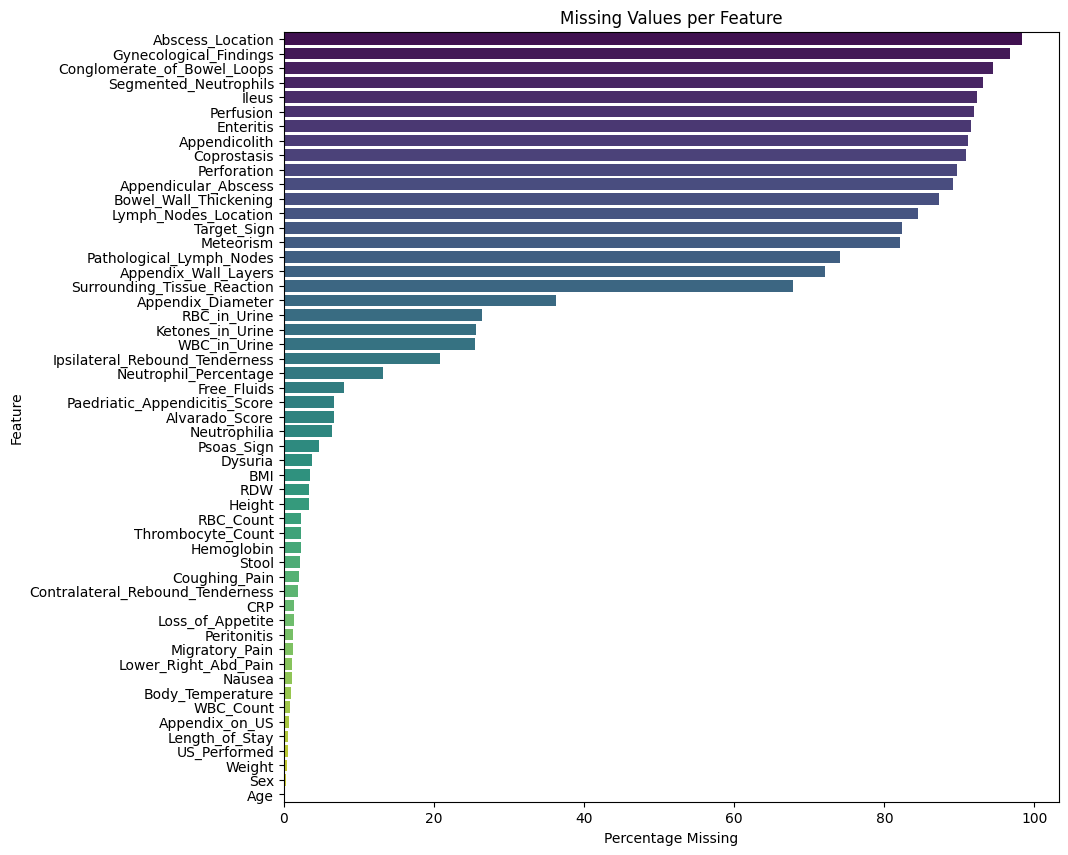

In [6]:
missing_percent = X.isnull().mean() * 100
missing_percent_sorted = missing_percent.sort_values(ascending=False)


plt.figure(figsize=(10,10))
sns.barplot(x=missing_percent_sorted[missing_percent_sorted > 0],
            y=missing_percent_sorted[missing_percent_sorted > 0].index,
            palette='viridis')
plt.xlabel('Percentage Missing')
plt.ylabel('Feature')
plt.title('Missing Values per Feature')
plt.show()


In [7]:
cols_to_drop = missing_percent[missing_percent > 50].index
X = X.drop(columns=cols_to_drop)


Variables with more than 50% missing values were removed, as such a high proportion of missing data could compromise model performance.

In [8]:
numeric_cols = X.select_dtypes(include=['float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns



\n Outlier Detection Summary:
                               Outlier Count  Outlier Percentage (%)
CRP                                       85               10.869565
Length_of_Stay                            44                5.626598
RDW                                       23                2.941176
BMI                                       23                2.941176
Hemoglobin                                16                2.046036
RBC_Count                                 14                1.790281
Height                                    12                1.534527
Body_Temperature                          12                1.534527
Appendix_Diameter                         10                1.278772
Thrombocyte_Count                          9                1.150895
Weight                                     8                1.023018
WBC_Count                                  6                0.767263
Age                                        5                0.639386
Neut

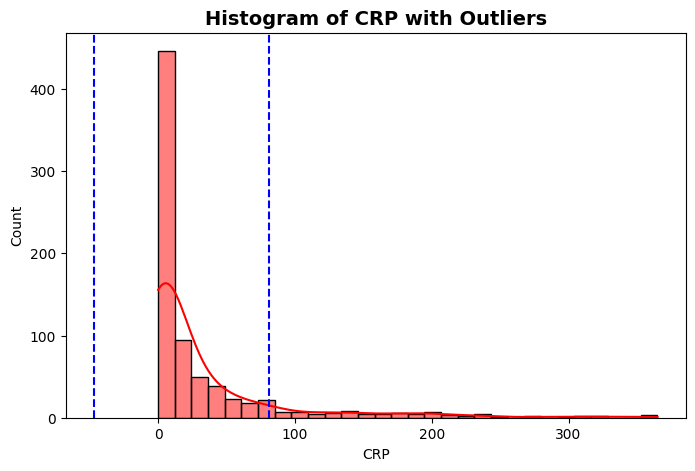

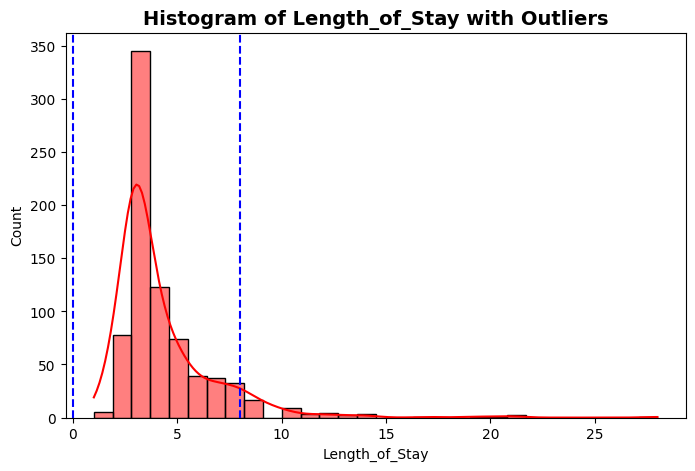

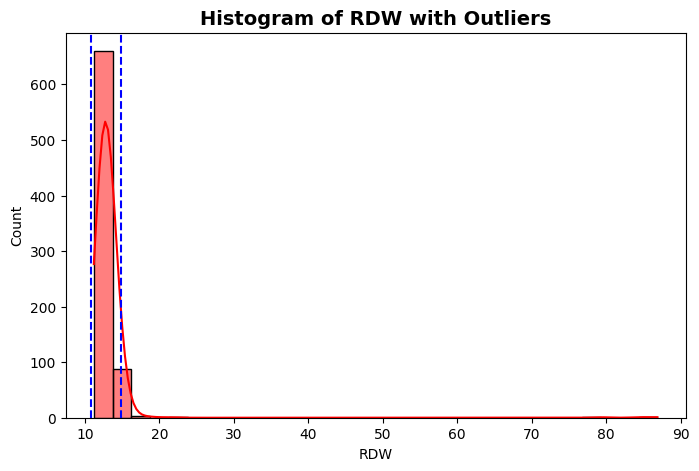

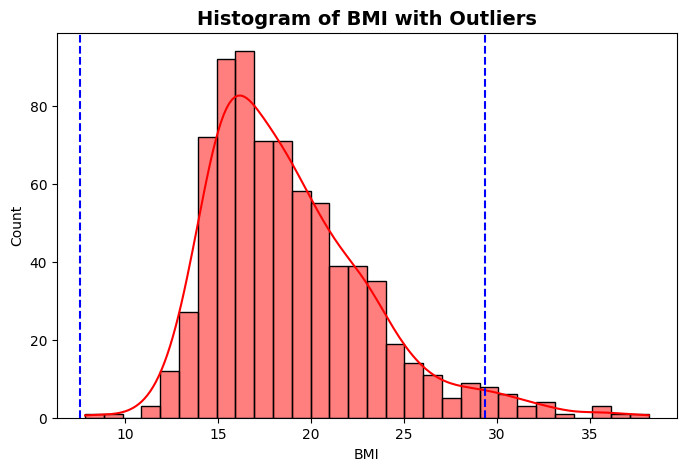

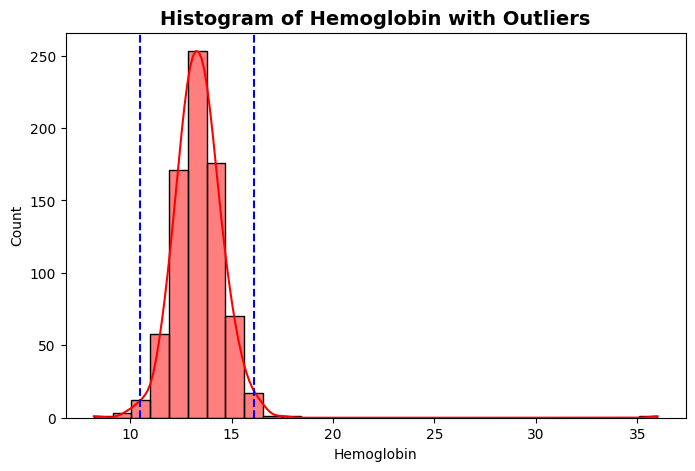

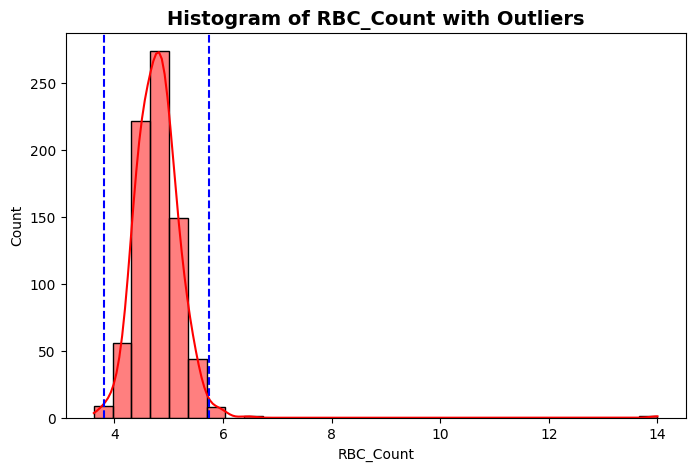

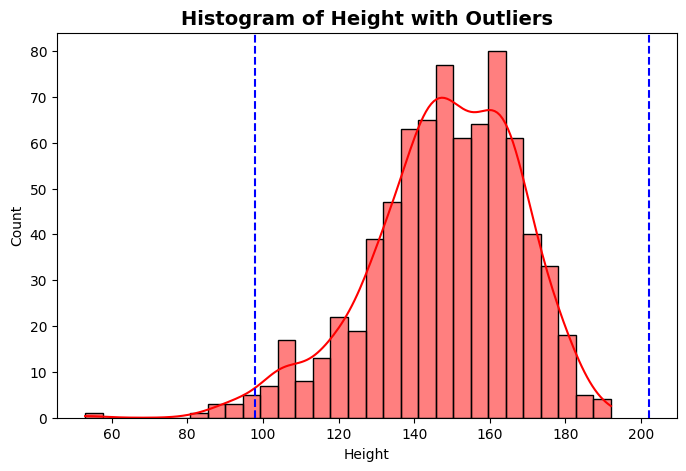

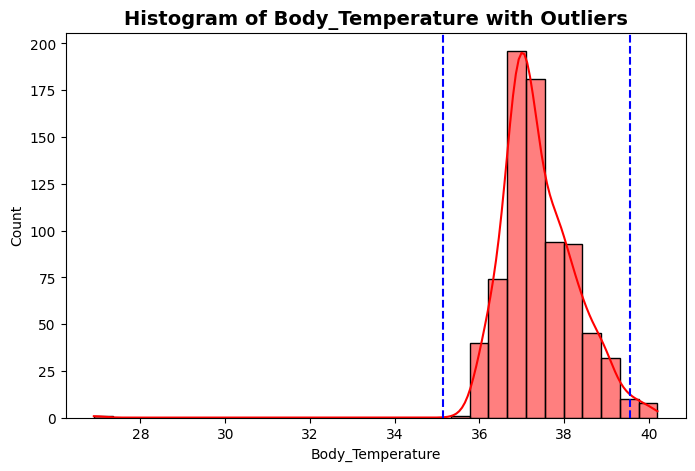

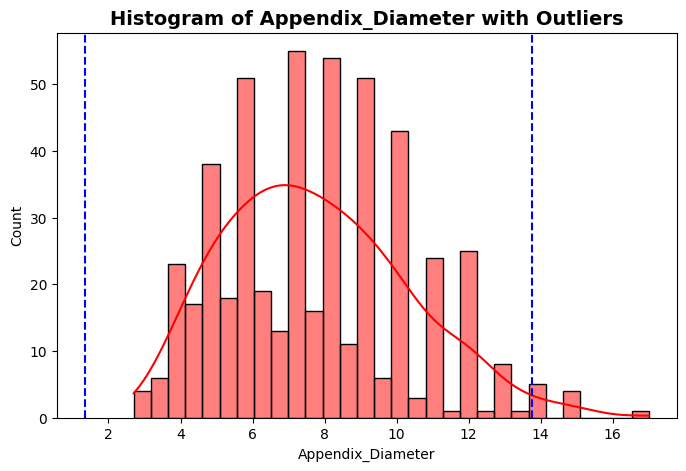

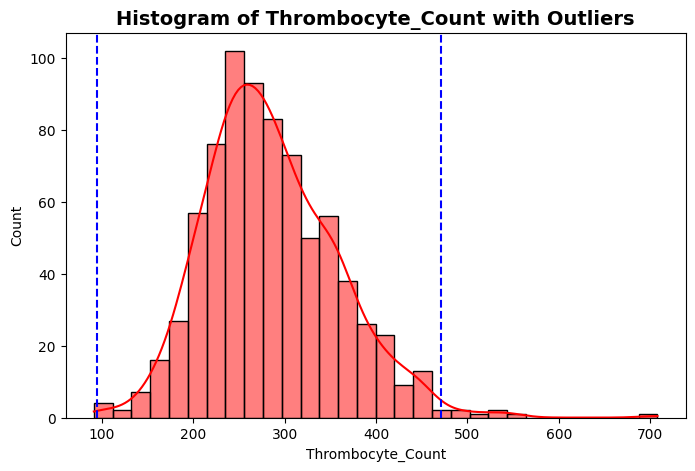

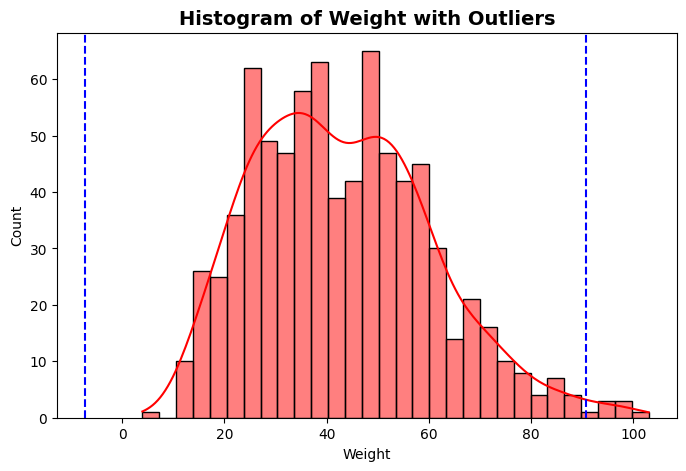

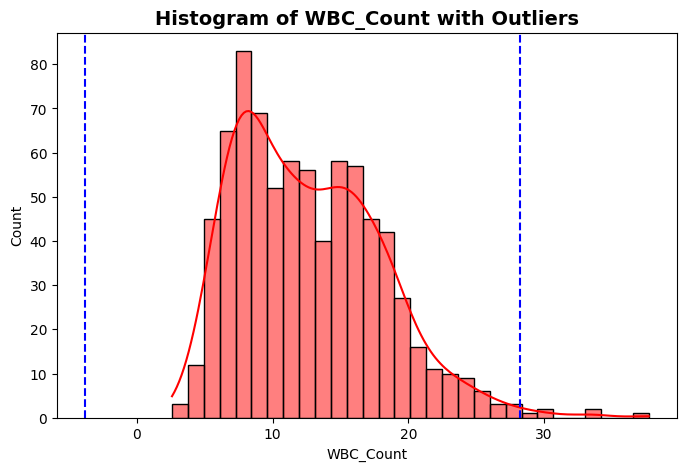

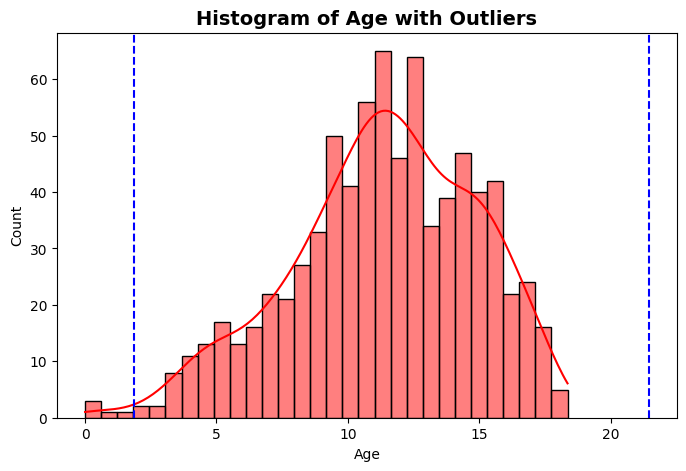

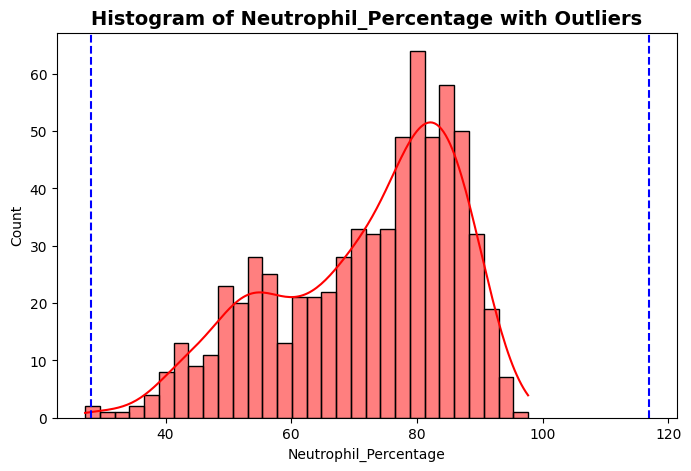

In [11]:
outliers = detect_outliers(X, 1.5)  # Detect outliers in features


Outlier detection was based on the interquartile range (IQR), where any value falling outside the range $[Q1 - k \cdot \text{IQR},\ Q3 + k \cdot \text{IQR}]$ was flagged as an outlier. Here, $k$ was set to 1.5 (1.5 x IQR) rule.


\n Outlier Detection Summary:
                               Outlier Count  Outlier Percentage (%)
CRP                                       15                1.918159
Length_of_Stay                             5                0.639386
RDW                                        4                0.511509
Body_Temperature                           1                0.127877
RBC_Count                                  1                0.127877
Hemoglobin                                 1                0.127877
Height                                     0                0.000000
Age                                        0                0.000000
Appendix_Diameter                          0                0.000000
Paedriatic_Appendicitis_Score              0                0.000000
Alvarado_Score                             0                0.000000
Weight                                     0                0.000000
BMI                                        0                0.000000
WBC_

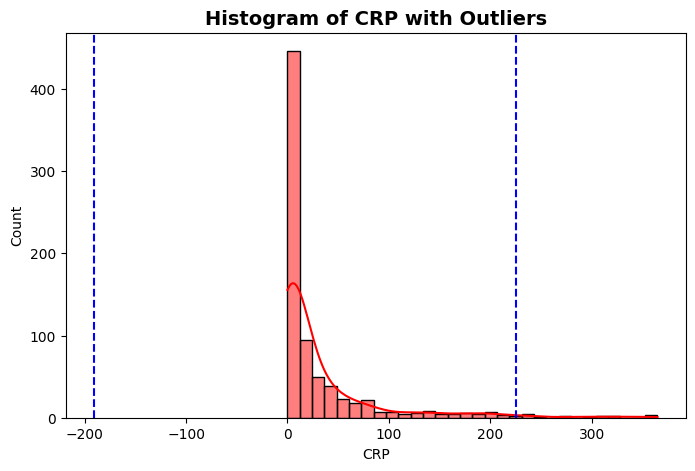

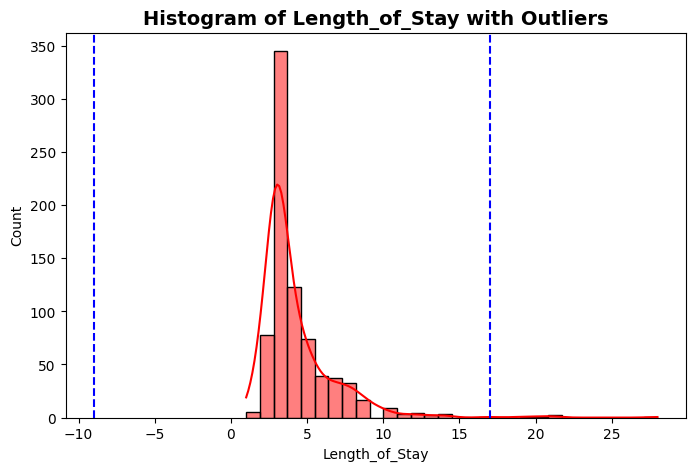

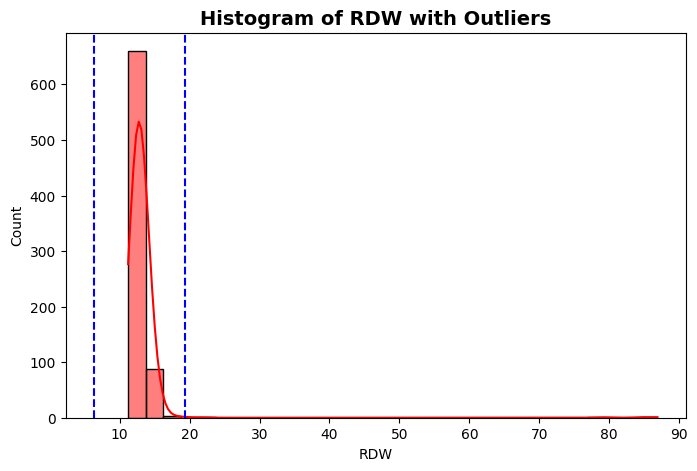

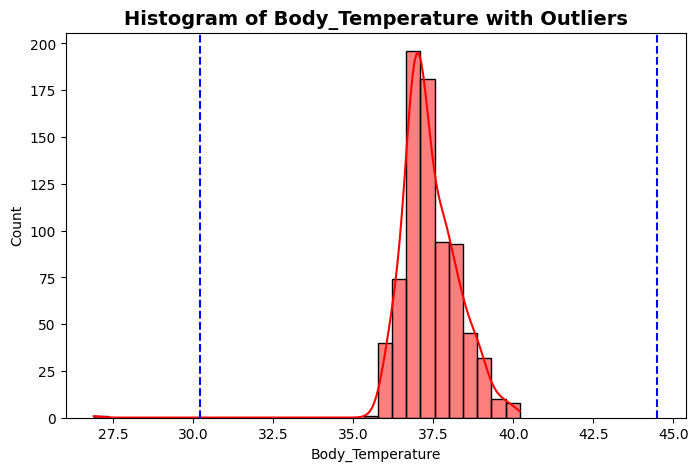

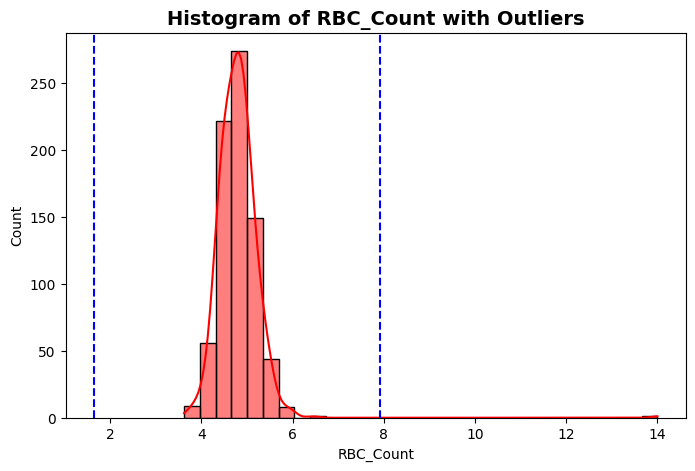

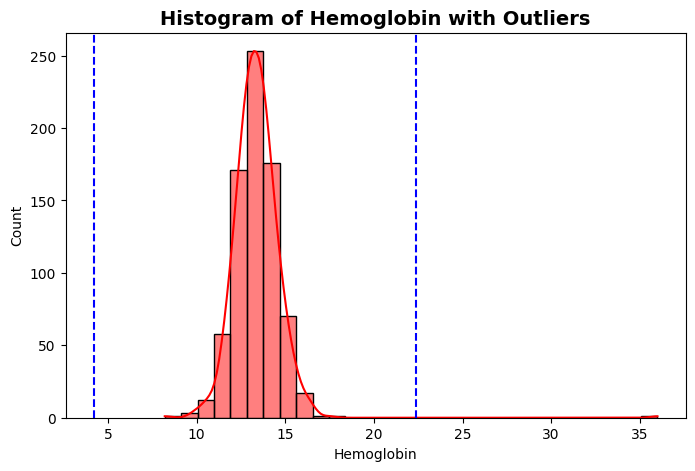

In [12]:
outliers = detect_outliers(X, 6)  # Detect Extreme outliers in features


When the threshold was increased to 6×IQR to focus only on extreme outliers, CRP remained the most affected variable,

#### Predictor Correlation

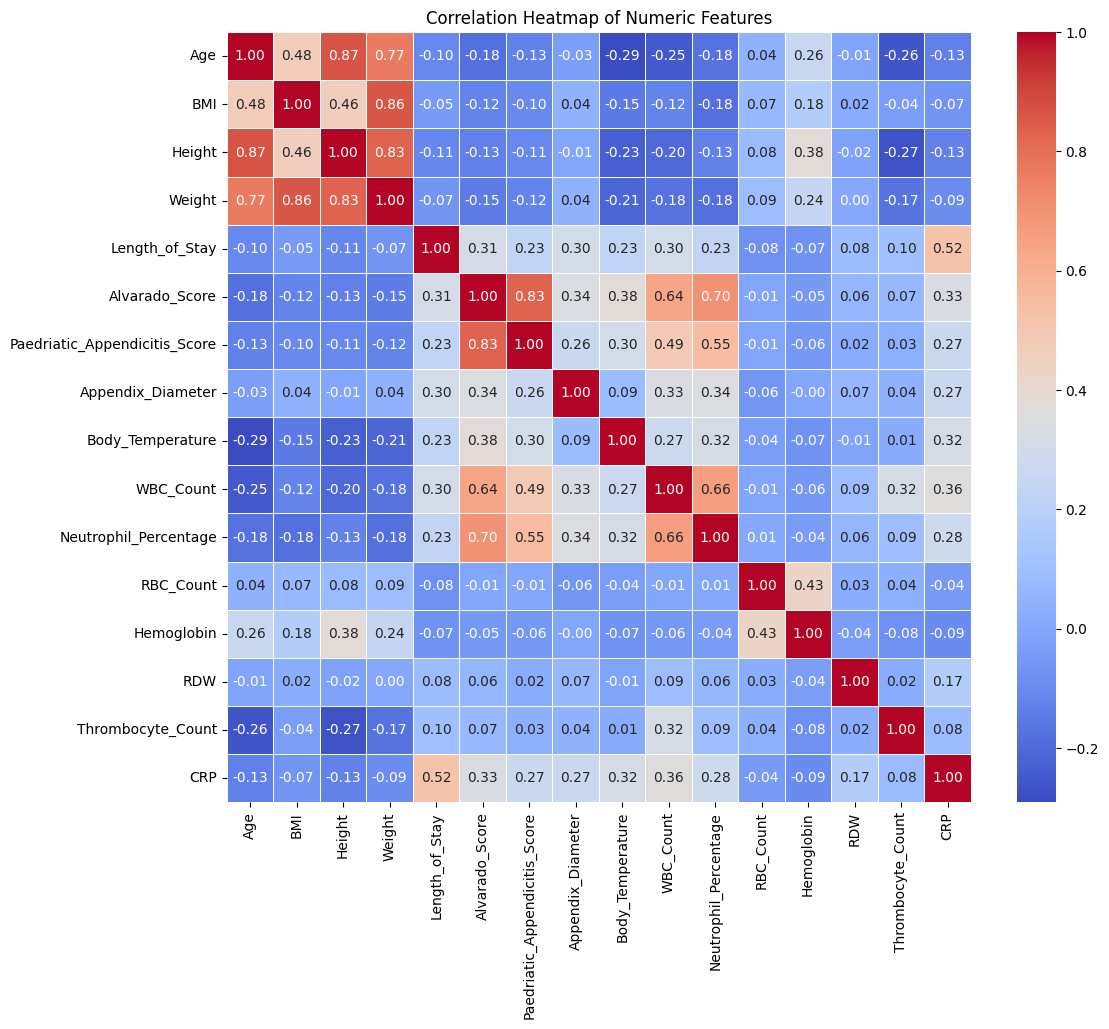

In [9]:
num_x = X.select_dtypes(exclude=['object', 'category'])
f,ax = plt.subplots(figsize=(12, 10))
sns.heatmap(num_x.corr(), annot=True, cmap='coolwarm', linewidths=.5, fmt= '.2f',ax=ax)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In a pediatric population (ages 0-18), the strong correlation between age and height (.87), and age and weight (.77) is expected due to natural growth patterns. However, this level of multicollinearity could effect the stability of a logistic regression model, suggesting that it may be beneficial to exclude one of the variables with a high correlation.

In [10]:
y_full = y.copy()

In [11]:
y = y_full['Diagnosis']

In [12]:
y

0         appendicitis
1      no appendicitis
2      no appendicitis
3      no appendicitis
4         appendicitis
            ...       
777       appendicitis
778       appendicitis
779       appendicitis
780       appendicitis
781       appendicitis
Name: Diagnosis, Length: 782, dtype: object

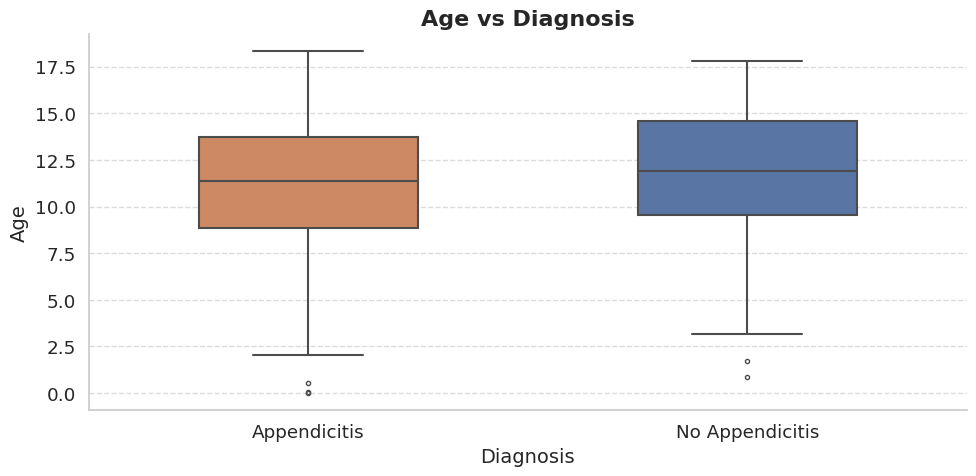

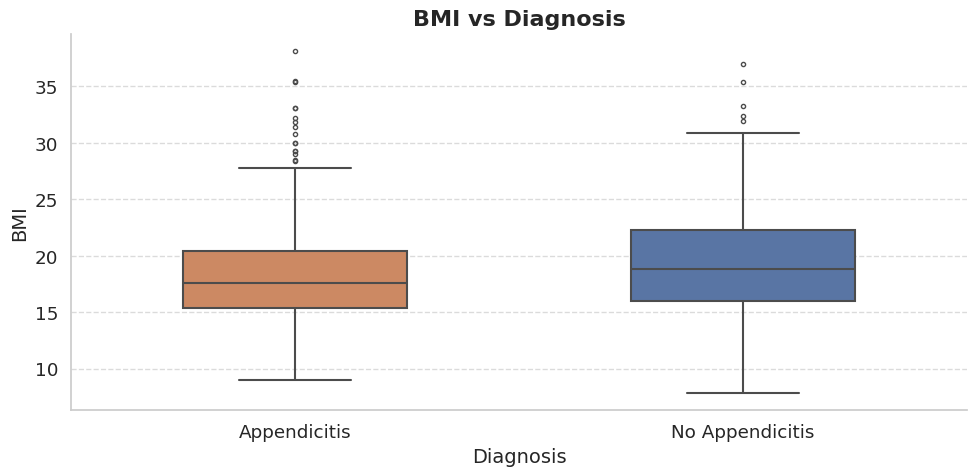

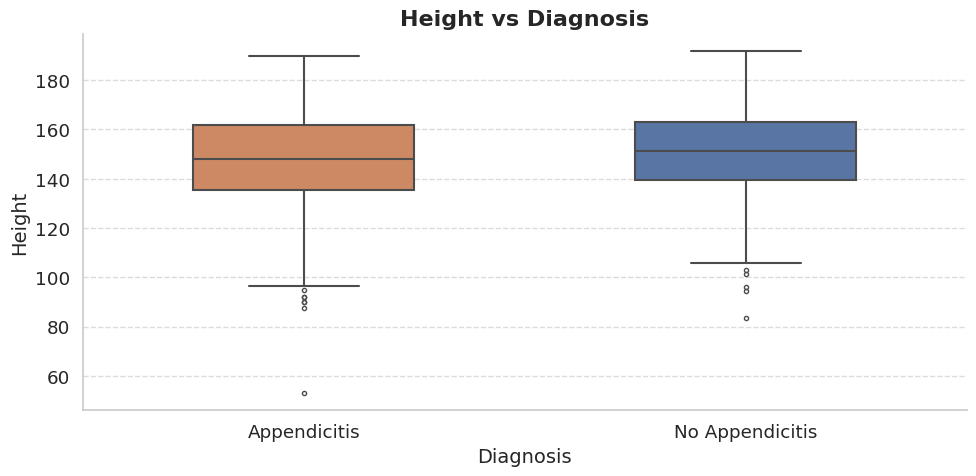

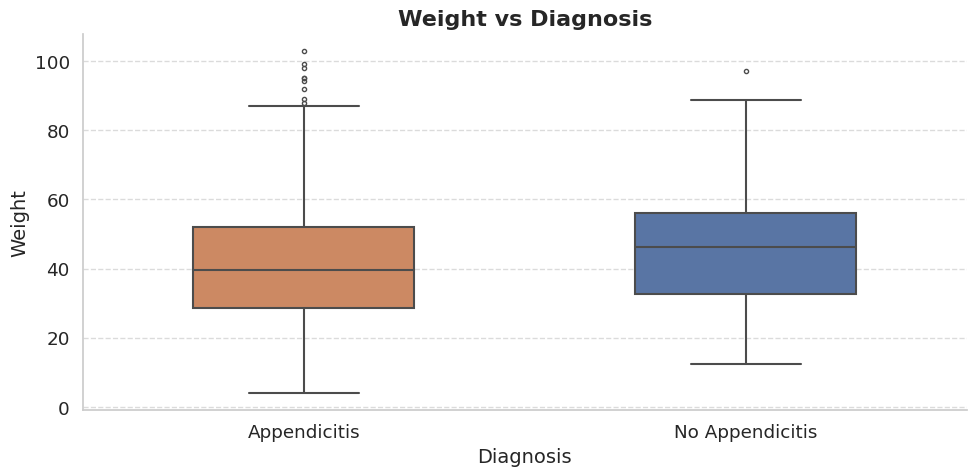

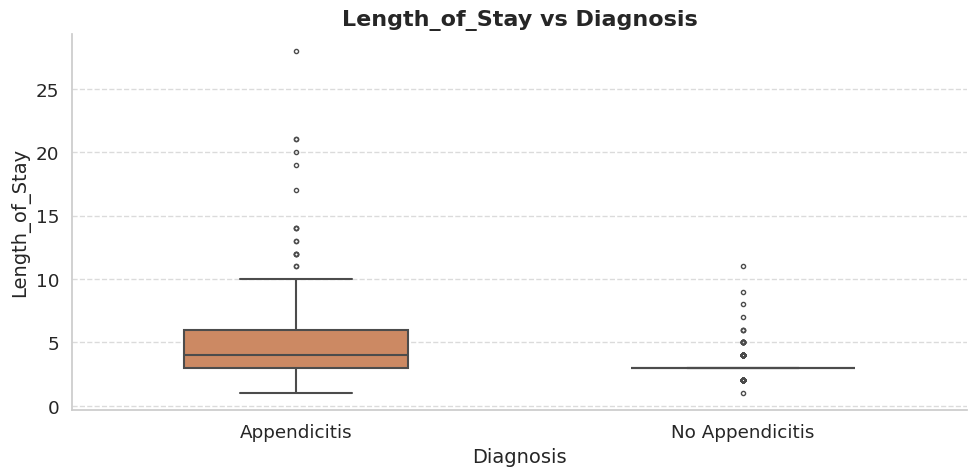

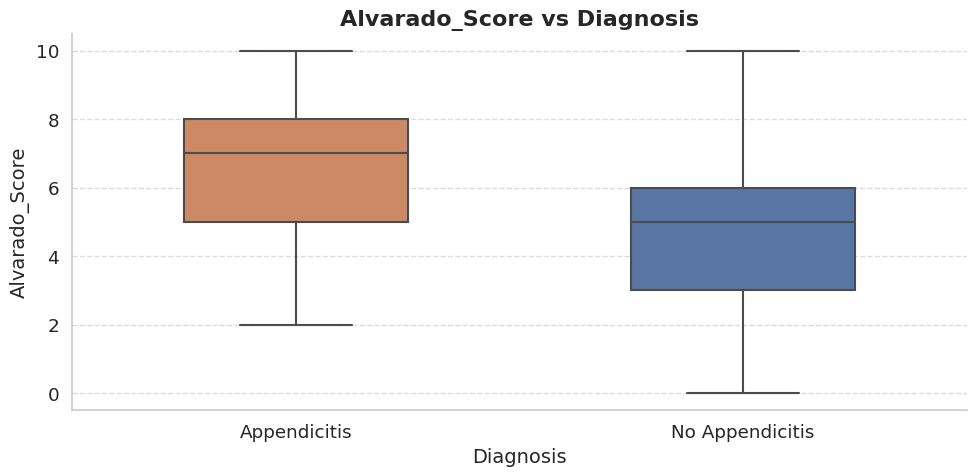

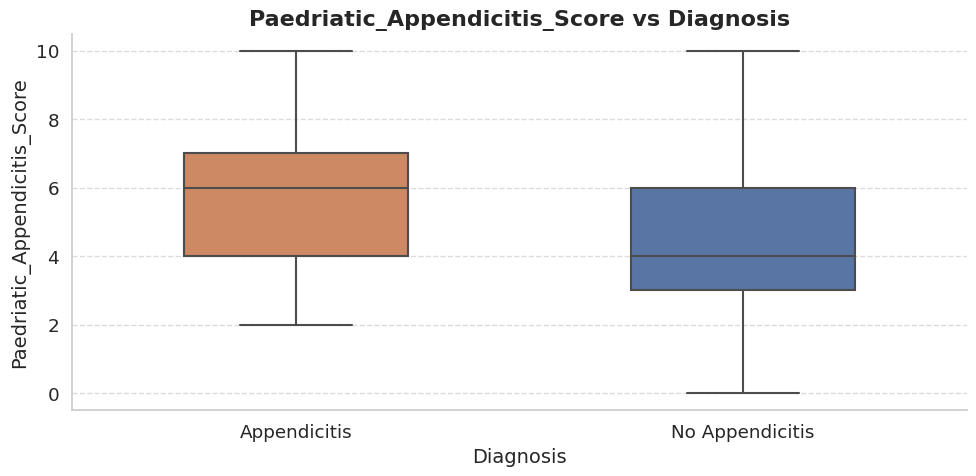

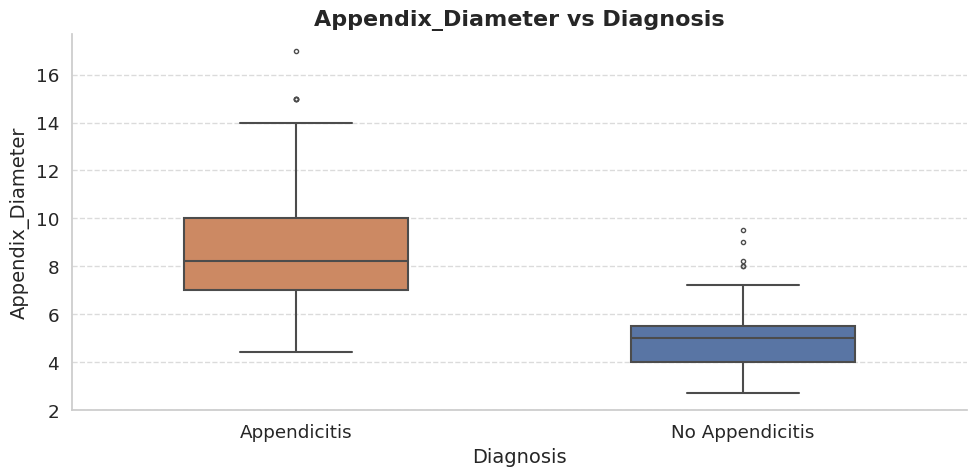

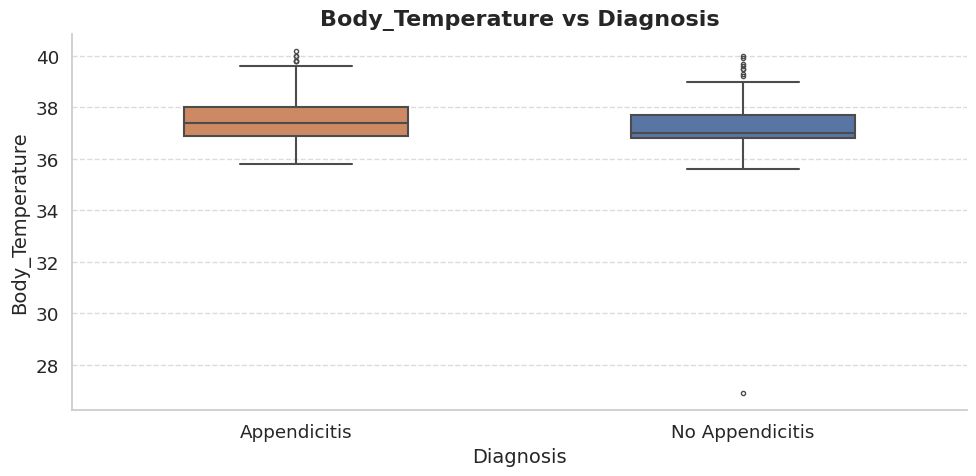

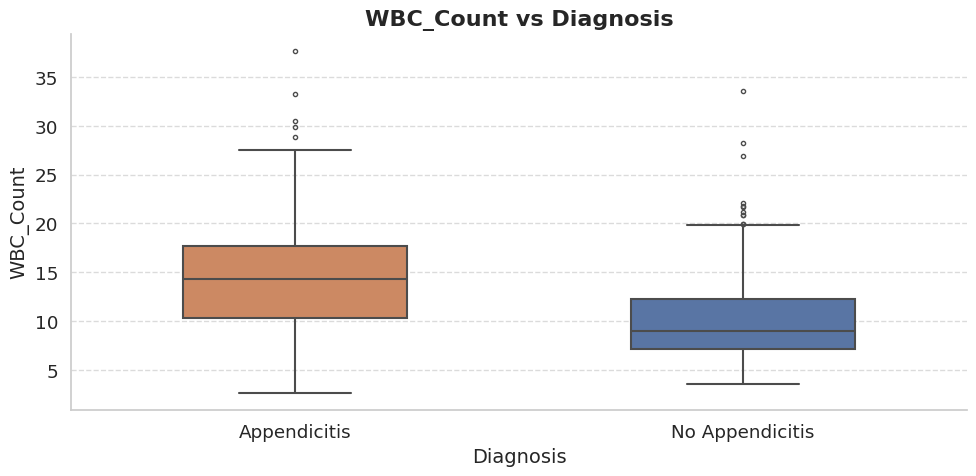

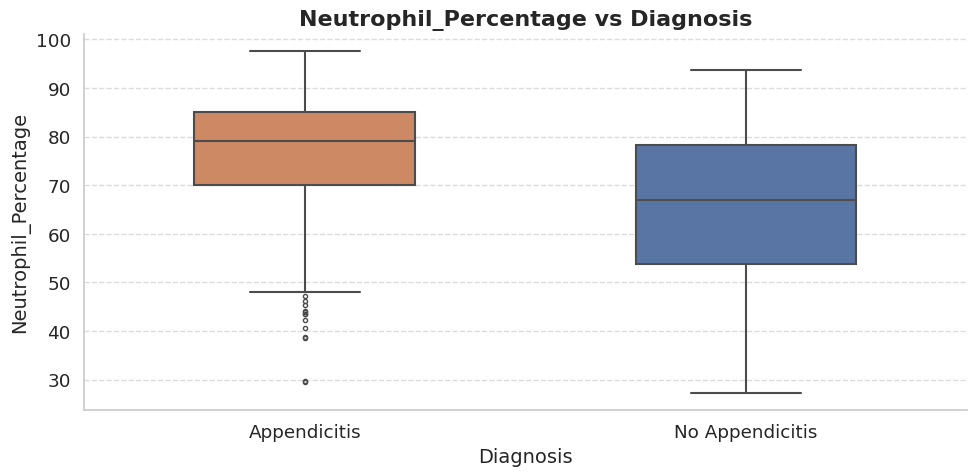

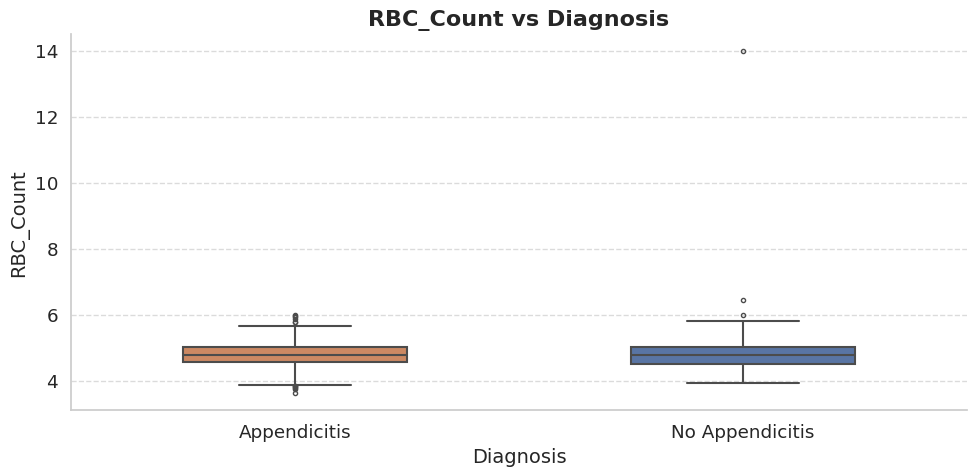

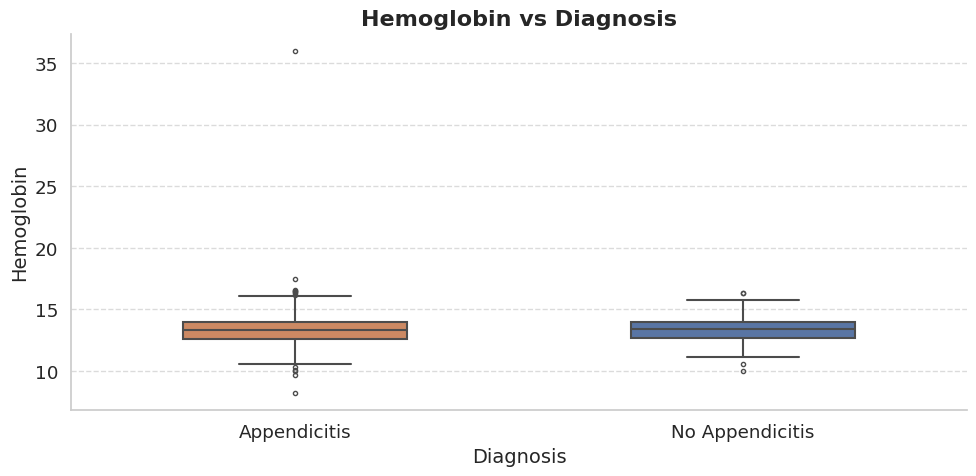

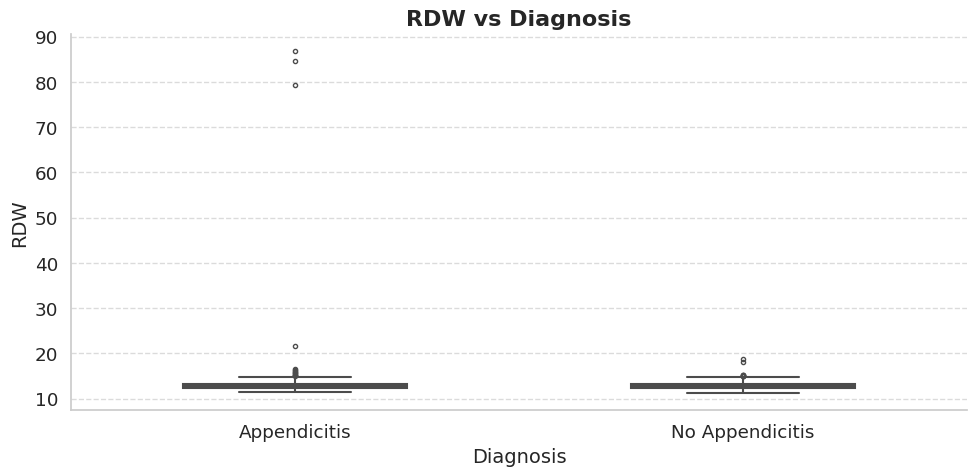

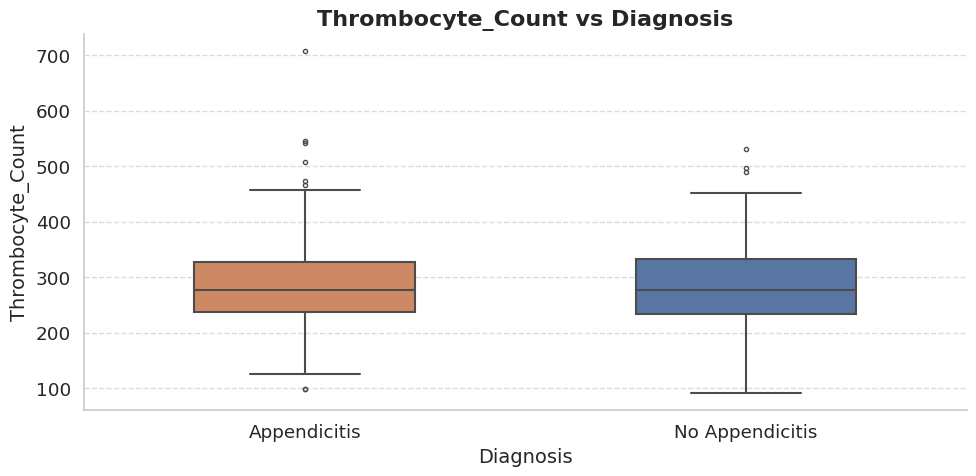

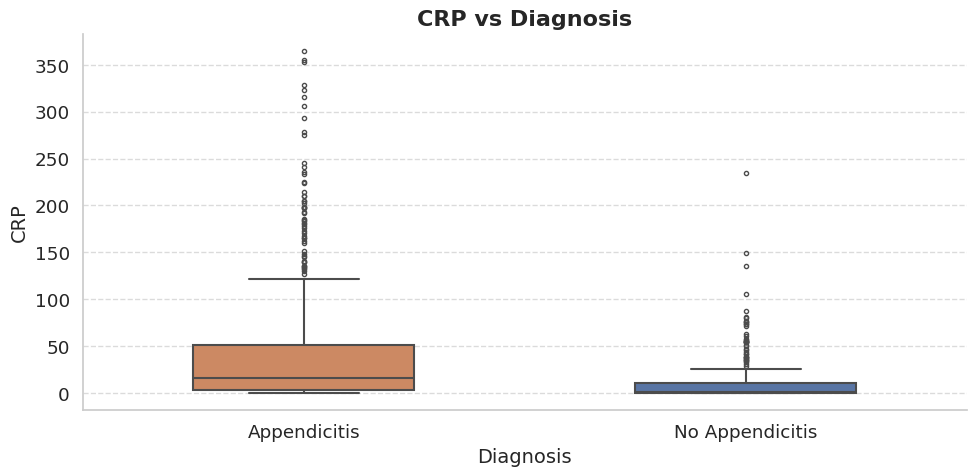

In [13]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
custom_palette = {
    'no appendicitis': "#4C72B0",  # Blue for "No Appendicitis"
    'appendicitis': "#DD8452"   # Orange for "Appendicitis"
}

for col in numeric_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(
        x=y,
        y=X[col],
        palette=custom_palette,
        width=0.5,
        fliersize=3,  # Smaller outliers
        linewidth=1.5  # Thicker lines
    )

    plt.title(f'{col} vs Diagnosis', fontsize=16, weight='bold')
    plt.xlabel('Diagnosis', fontsize=14)
    plt.ylabel(col, fontsize=14)
    plt.xticks(ticks=['no appendicitis', 'appendicitis'], labels=['No Appendicitis', 'Appendicitis'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    sns.despine()

    plt.tight_layout()
    plt.show()


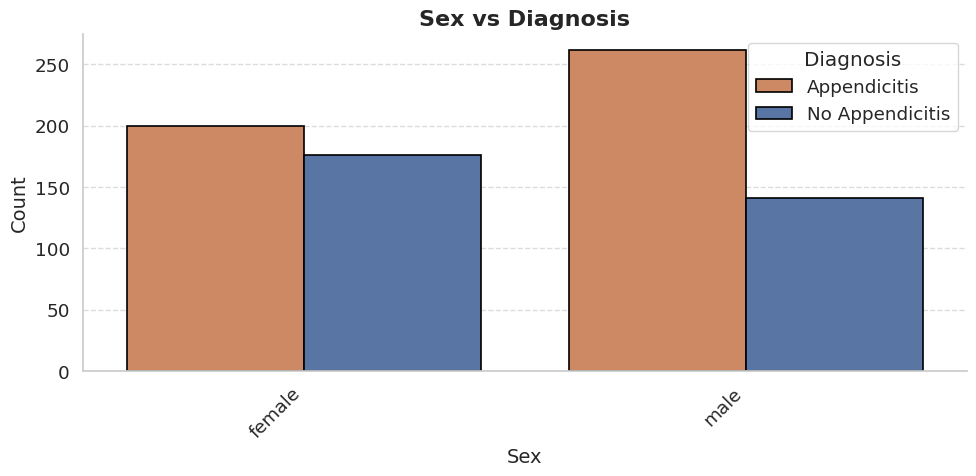

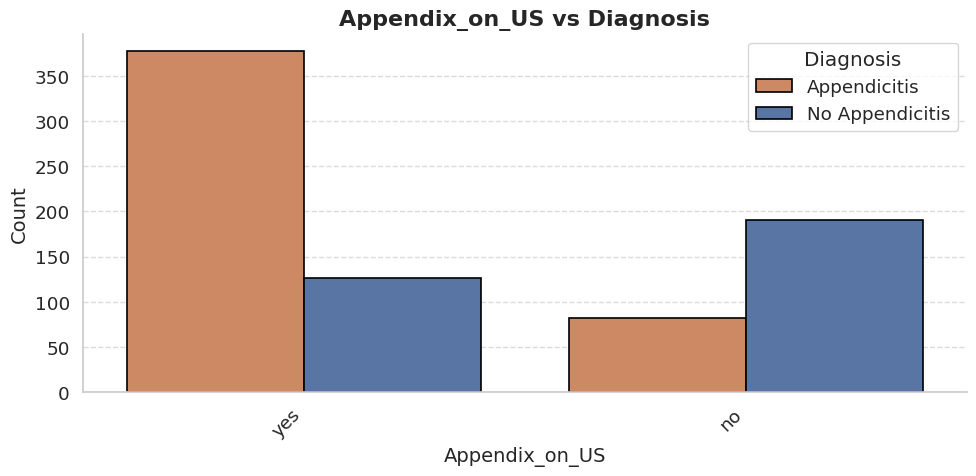

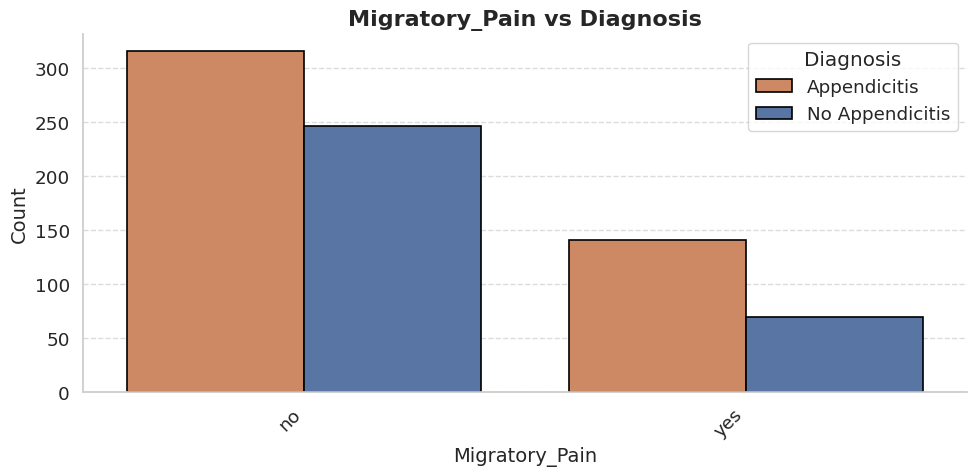

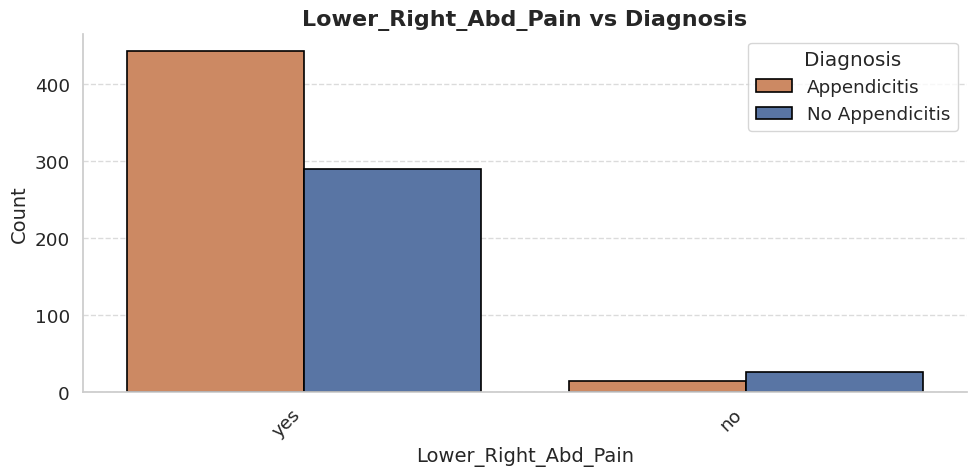

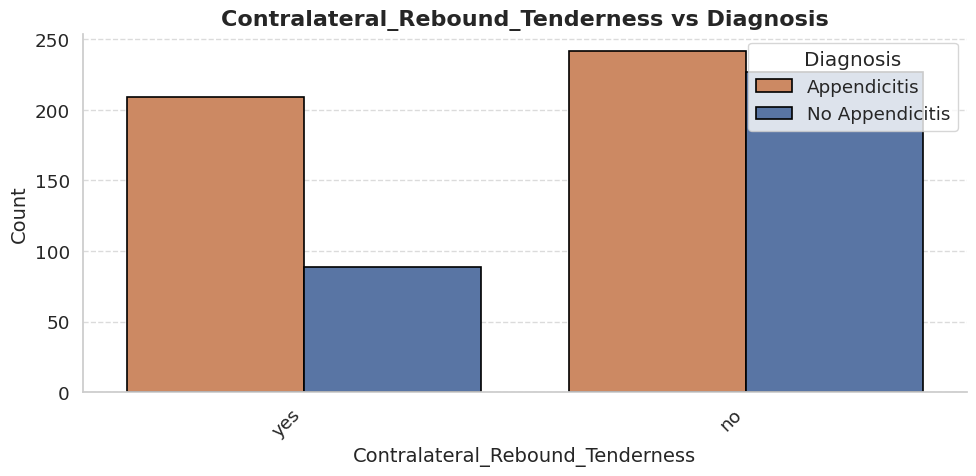

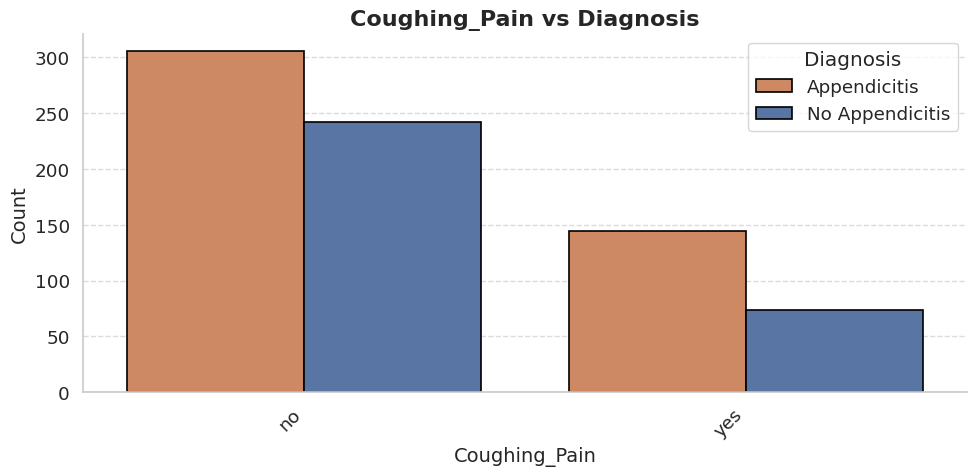

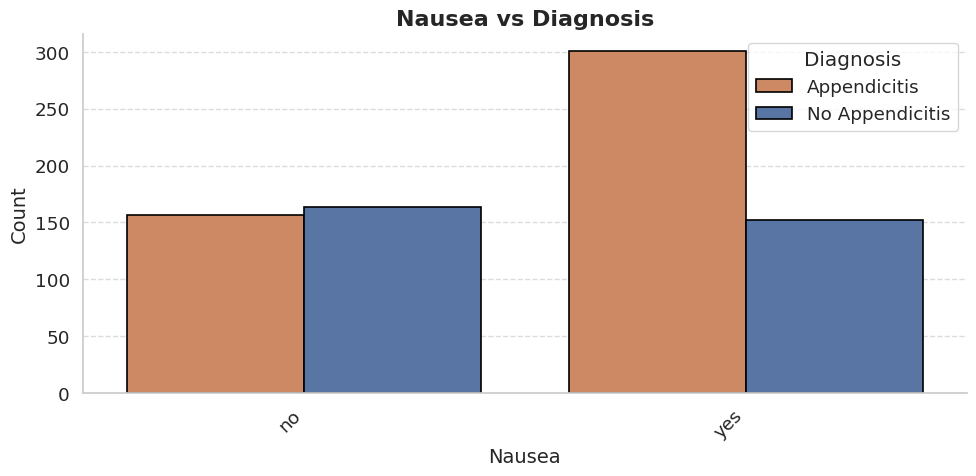

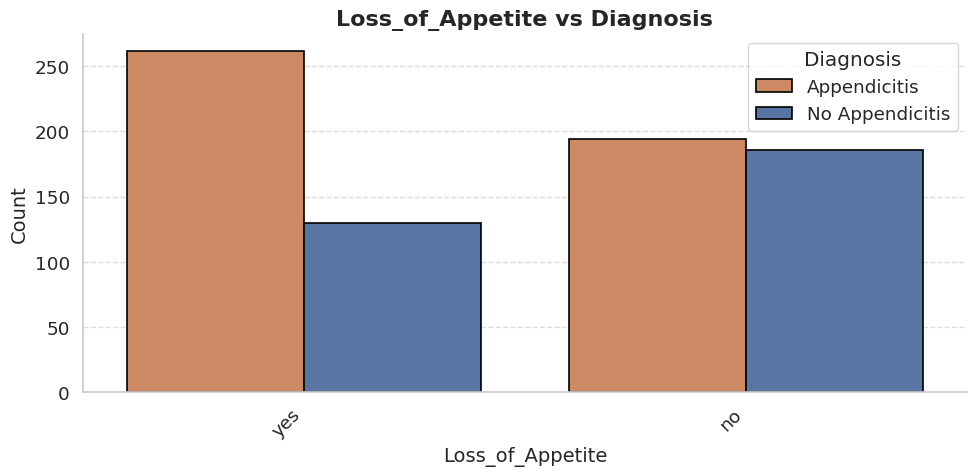

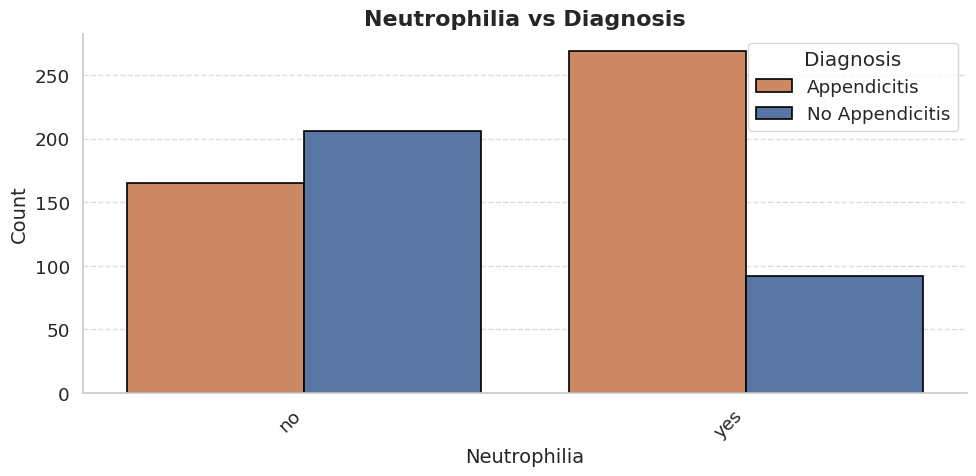

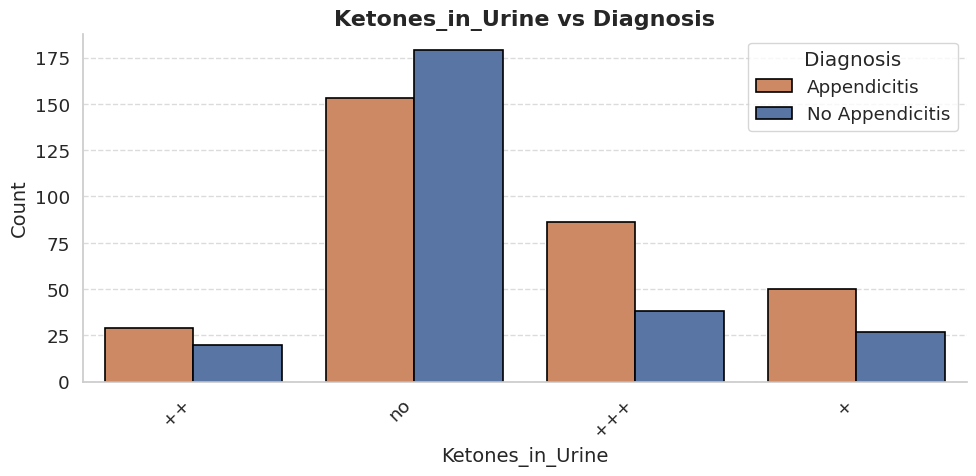

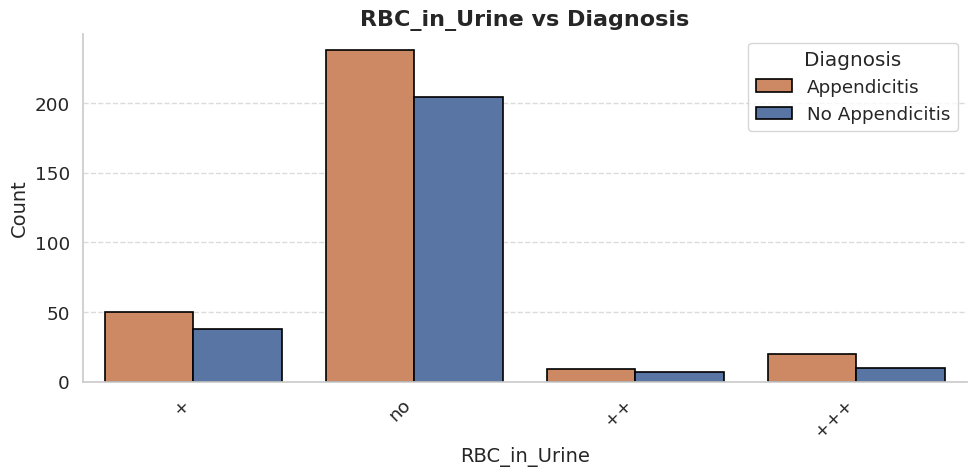

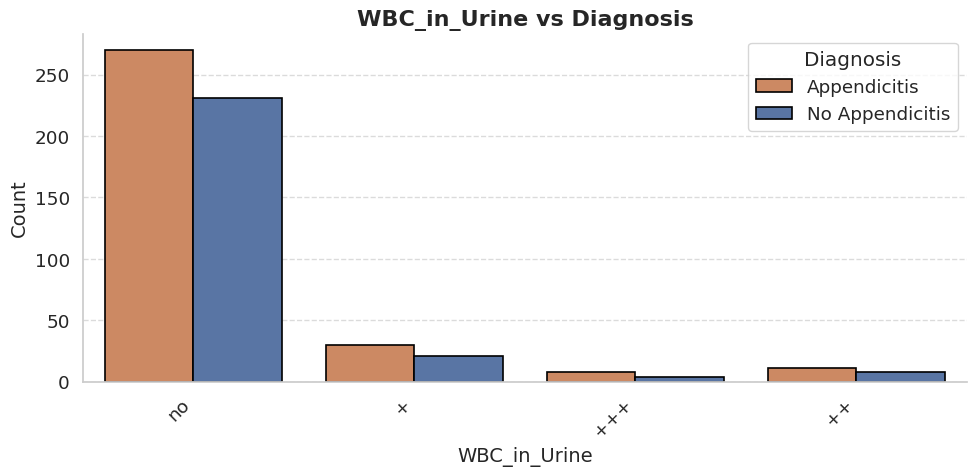

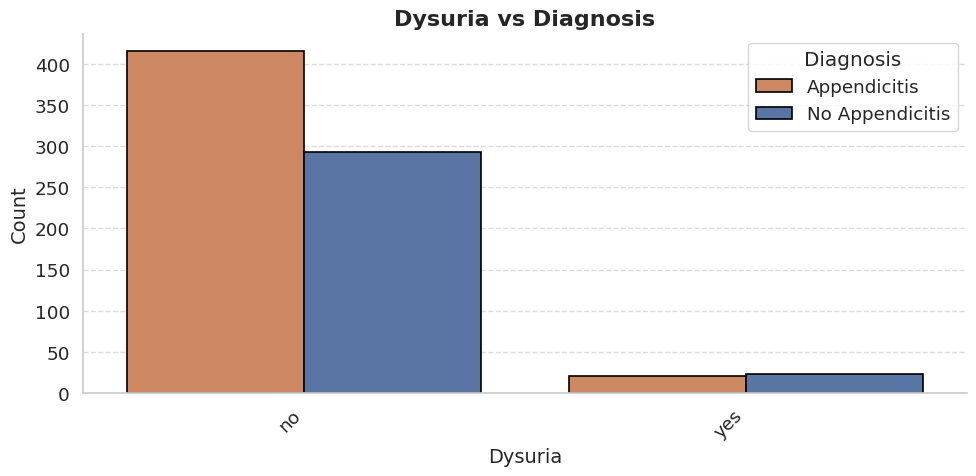

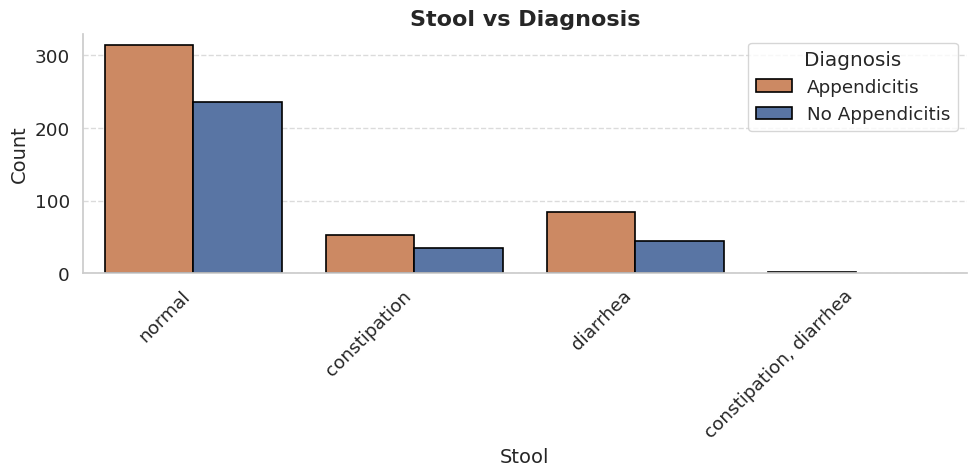

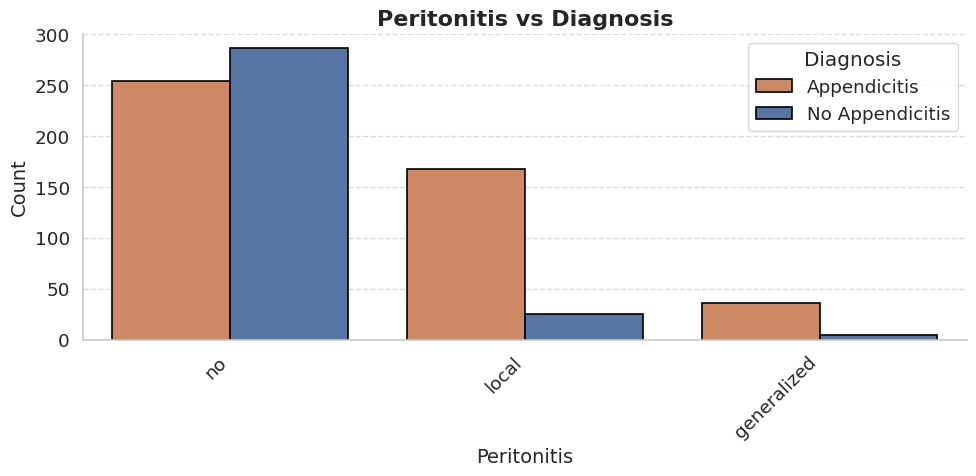

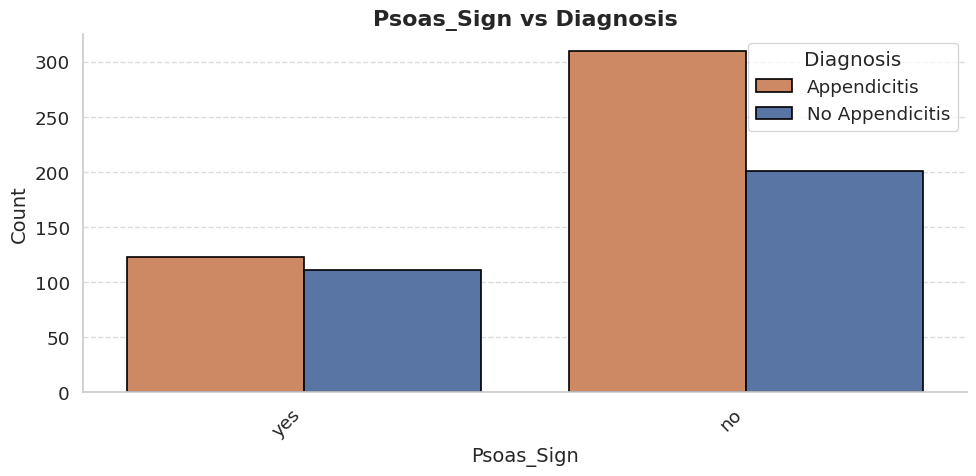

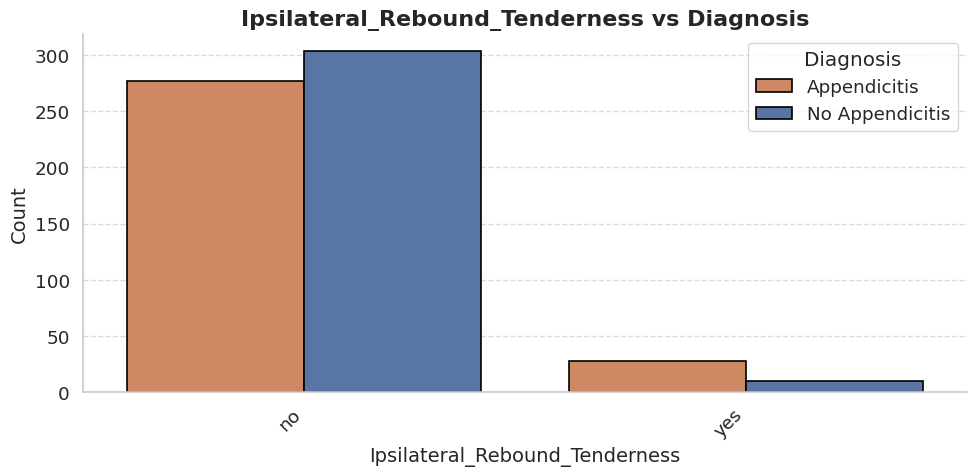

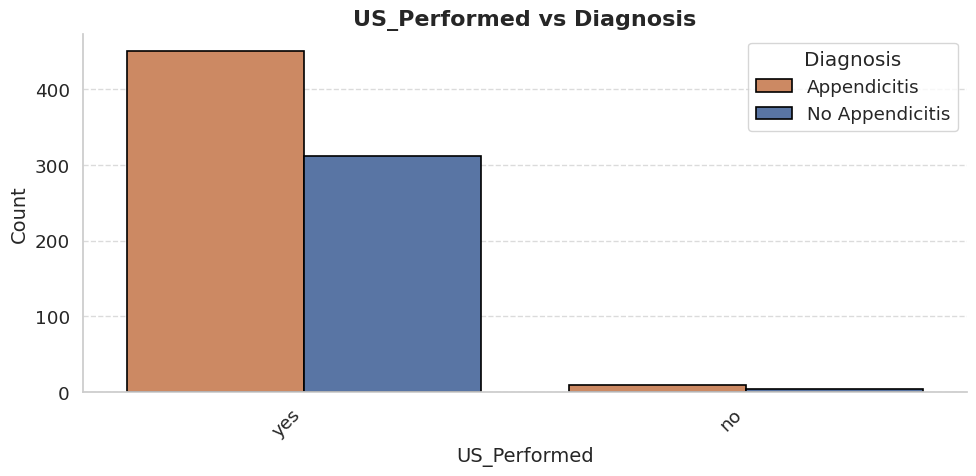

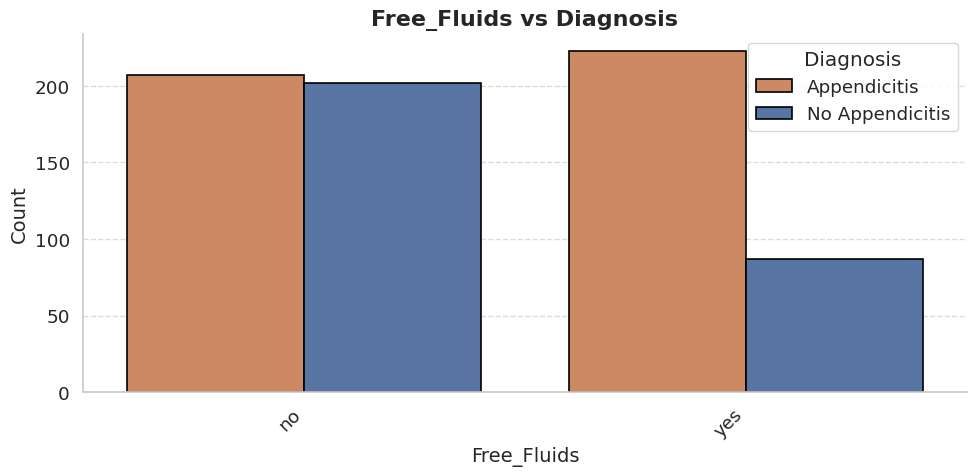

In [14]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
custom_palette = {
    'no appendicitis': "#4C72B0",  # Blue for "No Appendicitis"
    'appendicitis': "#DD8452"   # Orange for "Appendicitis"
}
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(
        x=X[col],
        hue=y,
        palette=custom_palette,
        edgecolor='black',  # Adds nice separation
        linewidth=1.2
    )

    plt.title(f'{col} vs Diagnosis', fontsize=16, weight='bold')
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Diagnosis', labels=['Appendicitis', 'No Appendicitis'])

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    sns.despine()

    plt.tight_layout()
    plt.show()


The "Appendix_on_US" (detectibility of appendix on ultrasound) variable stands out in the graphs, as cases where the appendix was visible were more frequently associated with appendicitis diagnoses (orange bar), while cases of the appendix not being visible on the ultrasound was more often linked to the absence of appendicitis (blue bar).

Removed Variables: ['Height', 'Weight', 'Paedriatic_Appendicitis_Score']


<Axes: >

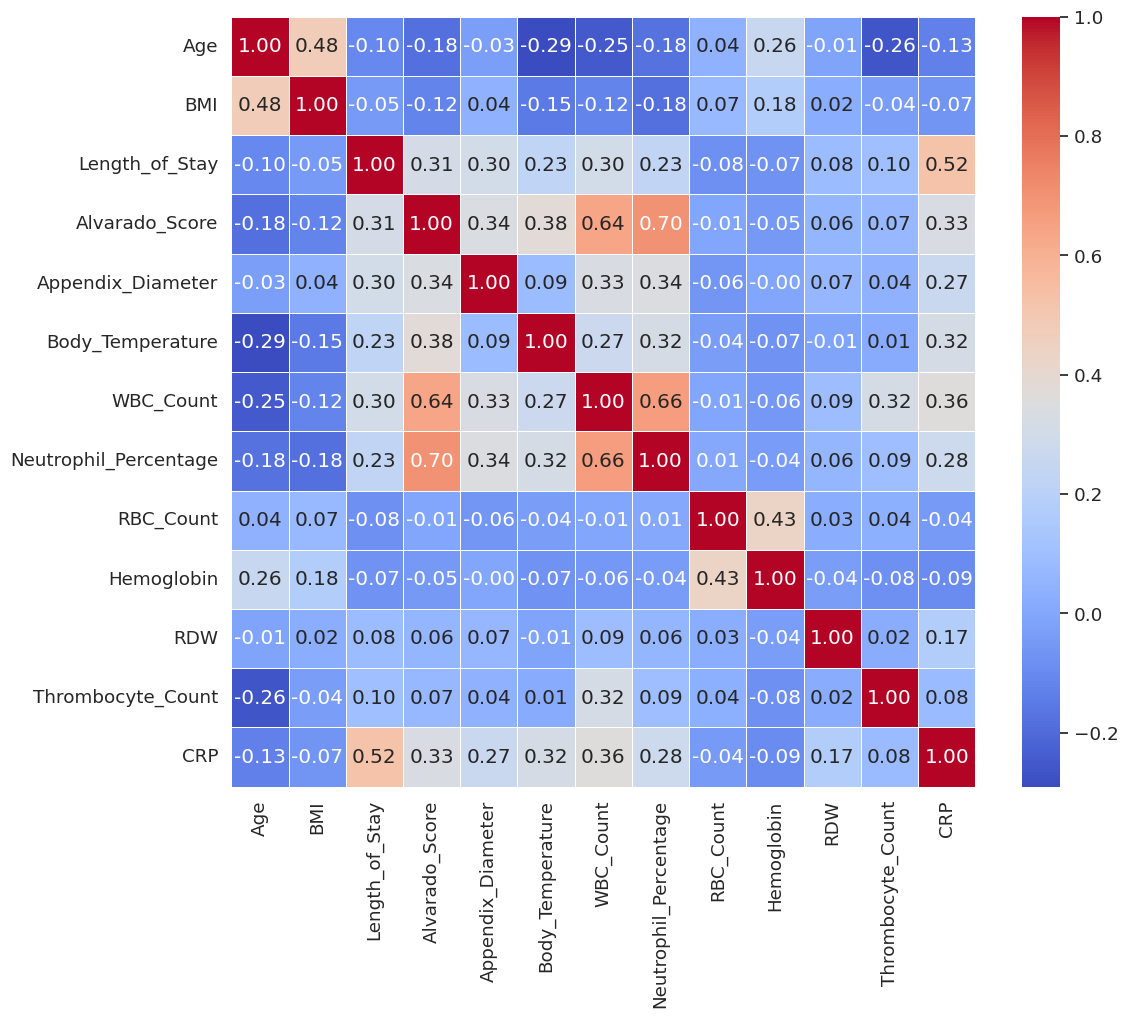

In [23]:
corr_matrix = num_x .corr().abs()  # Get absolute value of correlations
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # Upper triangle matrix of correlations

# Find features with correlation above the threshold
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
# Drop the selected features
x_reduced = num_x.drop(columns=to_drop)

print("Removed Variables:", to_drop)

f,ax = plt.subplots(figsize=(12, 10))
sns.heatmap(x_reduced.corr(), annot=True, linewidths=.5, cmap='coolwarm',fmt= '.2f',ax=ax)

Removed the following variables as they had a correlation >.8 with anohter variable ('Height', 'Weight', 'Paedriatic_Appendicitis_Score').
After removing variables with pairwise correlations above 0.8, the reduced set of features was used specifically for logistic regression, as it is sensitive to multicollinearity. For the other machine learning models, the full set of features was retained, since algorithms like random forests, and boosting methods are not impacted in the same way by highly correlated predictors.

In [24]:
X_REDUCED = pd.concat([x_reduced, X.select_dtypes(include=['object', 'category'])], axis=1)
X_REDUCED

Age    BMI  Length_of_Stay  Alvarado_Score  Appendix_Diameter  \
0    12.68  16.90             3.0             4.0                7.1   
1    14.10  31.90             2.0             5.0                NaN   
2    14.14  23.30             4.0             5.0                NaN   
3    16.37  20.60             3.0             7.0                NaN   
4    11.08  16.90             3.0             5.0                7.0   
..     ...    ...             ...             ...                ...   
777  12.41  25.25             4.0             8.0                7.5   
778  17.09  20.43             6.0             5.0                NaN   
779  14.99  19.91             4.0             5.0                NaN   
780   7.20  14.30             5.0             9.0               14.0   
781  11.51  18.17             4.0             2.0                8.0   

     Body_Temperature  WBC_Count  Neutrophil_Percentage  RBC_Count  \
0                37.0        7.7                   68.2       5.27   
1                36.9        8.1                   64.8       5.26   
2                36.6       13.2                   74.8       3.98   
3                36.0       11.4                   63.0       4.64   
4                36.9        8.1                   44.0       4.44   
..                ...        ...                    ...        ...   
777              39.4       11.4                   76.6       4.95   
778              37.8       17.4                   89.2       4.52   
779              37.3       14.6                   68.5       4.49   
780              37.5       17.8                   77.0       4.97   
781              36.8        9.3                   70.0       4.64   

     Hemoglobin  ...  Ketones_in_Urine  RBC_in_Urine  WBC_in_Urine Dysuria  \
0          14.8  ...                ++             +            no      no   
1          15.7  ...                no            no            no     yes   
2          11.4  ...                no            no            no      no   
3          13.6  ...                no            no            no     yes   
4          12.6  ...                no            no            no      no   
..          ...  ...               ...           ...           ...     ...   
777        13.7  ...               NaN           NaN           NaN      no   
778        13.1  ...               NaN           NaN           NaN      no   
779        12.7  ...                no            no            no     yes   
780        14.3  ...               +++            no            no      no   
781        13.2  ...                no            no            no      no   

            Stool Peritonitis Psoas_Sign Ipsilateral_Rebound_Tenderness  \
0          normal          no        yes                             no   
1          normal          no        yes                             no   
2    constipation          no        yes                             no   
3          normal          no        yes                             no   
4    constipation          no        yes                             no   
..            ...         ...        ...                            ...   
777      diarrhea       local        yes                            NaN   
778        normal       local         no                            NaN   
779        normal          no         no                             no   
780        normal       local         no                             no   
781        normal       local         no                            NaN   

    US_Performed Free_Fluids  
0            yes          no  
1            yes          no  
2            yes          no  
3            yes          no  
4            yes          no  
..           ...         ...  
777          yes          no  
778          yes          no  
779          yes         yes  
780          yes         yes  
781          yes          no  

[782 rows x 32 columns]

## 1.3 Outcome Variables

In [25]:
y_full

Management       Severity        Diagnosis
0          conservative  uncomplicated     appendicitis
1          conservative  uncomplicated  no appendicitis
2          conservative  uncomplicated  no appendicitis
3          conservative  uncomplicated  no appendicitis
4          conservative  uncomplicated     appendicitis
..                  ...            ...              ...
777    primary surgical  uncomplicated     appendicitis
778  secondary surgical    complicated     appendicitis
779    primary surgical  uncomplicated     appendicitis
780    primary surgical  uncomplicated     appendicitis
781    primary surgical  uncomplicated     appendicitis

[782 rows x 3 columns]

In [26]:
y_full.describe().T

count unique            top freq
Management   781      4   conservative  483
Severity     781      2  uncomplicated  662
Diagnosis    780      2   appendicitis  463

Diagnosis missing one value, therefore removed that row from the dataset.

In [ ]:
valid_idx = y.notnull()

# Filter both X and y
X = X[valid_idx]
y = y[valid_idx]
y_full = y_full[valid_idx]
X_REDUCED = X_REDUCED[valid_idx]

#### Imbalanced classification

**Diagnosis**


Number of appendicitis: 463 ||| Proportion: 59.4%
Number of no appendicitis: 317 ||| Proportion: 40.6%


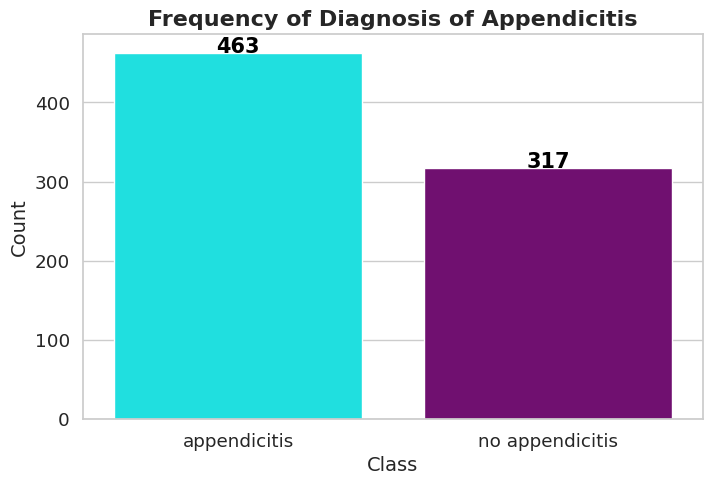

In [28]:
class_distribution(y, target_name="Diagnosis of Appendicitis")

- The diagnosis has a moderate class imbalance, with 463 cases of appendicitis and 317 non-appendicitis cases (approximately 59% vs. 41%).
- This imbalance can bias classification models toward the majority class, resulting in misleadingly high accuracy that fails to reflect performance on the minority class.
- In medical diagnosis, such bias is critical, as false negatives (missed diagnoses) can have serious clinical consequences.
- Accuracy is therefore insufficient as a standalone metric in this setting.
- Class-sensitive metrics such as **precision**, **recall**, and the **F1-score** are more appropriate for evaluating performance.
- The **F1-score**, which balances precision and recall, is particularly suitable when both false positives and false negatives are costly.


**Severity**



Number of uncomplicated: 661 ||| Proportion: 84.7%
Number of complicated: 119 ||| Proportion: 15.3%


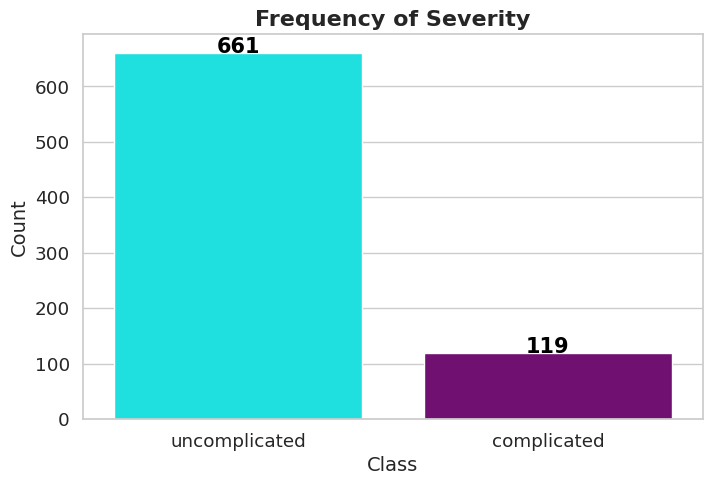

In [30]:
class_distribution(y_full["Severity"], target_name="Severity")

To accurately analyse severity, only patients diagnosed with appendicitis were included, as those without appendicitis were automatically labelled as uncomplicated; the data were therefore sampled accordingly to reflect true severity classification between uncomplicated and complicated appendicitis.

Number of uncomplicated: 345 ||| Proportion: 74.5%
Number of complicated: 118 ||| Proportion: 25.5%


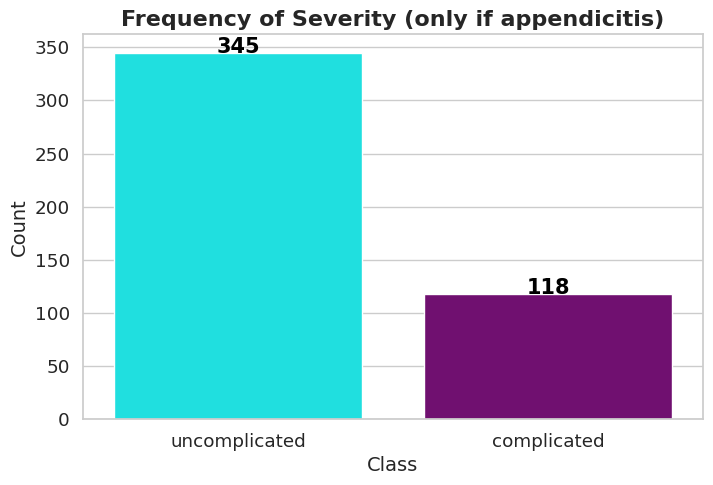

In [31]:
has_appendicitis = y_full["Diagnosis"] == 'appendicitis'
class_distribution(y_full.loc[has_appendicitis, "Severity"], target_name="Severity (only if person has appendicitis)")


The severity classification is also imbalanced (74.5% uncomplicated vs. 25.5% complicated). This imbalance is more extreme and so the need to prioritise metrics like the F1-score over accuracy is even greater in this case to ensure reliable performance across both classes.

# **2. METHODOLOGY**



## 2.1 Machine learning Models

In this project, a range of machine learning models were evaluated for the tasks of diagnosing appendicitis and predicting severity. Models were selected based on their historical success in healthcare applications, their interpretability, and their ability to manage tabular clinical data with mixed feature types.

To ensure appropriate model deployment, implementation was guided by both academic literature and practical resources. Key references include:

* Group sessions and lab-based feedback
* [Aurelien Géron - *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)
* [Max Kuhn, Kjell Johnson - *Applied Predictive Modeling*](https://link.springer.com/book/10.1007/978-1-4614-6849-3)
* [Frank E. Harrell, Jr - *Regression Modeling Strategies*](https://link.springer.com/book/10.1007/978-3-319-19425-7)
* [Kevin P. Murphy - *Machine Learning: A Probabilistic Perspective*](https://mitpress.mit.edu/9780262018029/machine-learning/)
* [Gareth James, Daniela Witten, Trevor Hastie - *An Introduction to Statistical Learning*](https://www.statlearning.com/)
* [Ewout W. Steyerberg - *Clinical Prediction Models*](https://link.springer.com/book/10.1007/978-3-030-16399-0)

Each model was developed using a structured workflow, including preprocessing, feature selection, model tuning, and evaluation through metrics suitable for imbalanced medical data (F1-score, precision, recall). The methodology prioritised reproducibility and practical relevance in a clinical context.



#### **Statistical Models**

**Logistic Regression**  
Logistic regression is a simple baseline for binary classification, especially valued in clinical settings for its clear interpretability. It models the probability of appendicitis using a weighted combination of predictors, allowing straightforward interpretation of each feature's contribution. However, it assumes linear relationships and can struggle with complex patterns or interactions.

$$
P(y = 1 \mid X) = \frac{1}{1 + \exp\left(-(\beta_0 + \sum_{i=1}^{n} \beta_i X_i)\right)}
$$

**Elastic Net Regularisation**  
Elastic Net improves logistic regression by combining L1 and L2 penalties to reduce overfitting and handle correlated predictors. It encourages simpler models while retaining important features.
$$
L_{\text{class}} = -\sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right] + \lambda_1 \sum_{j=1}^{n} |\beta_j| + \lambda_2 \sum_{j=1}^{n} \beta_j^2
$$  
The mixing parameter $\alpha \in [0, 1]$ controls the balance between L1 and L2. Elastic Net is used in this project for both tasks to penalise the use of unnecessary parameters and reduce overfitting.


---

#### **Ensemble Models**

**Random Forest**  
Random Forest combines multiple decision trees to improve predictive stability and reduce overfitting. It handles non-linear relationships and noisy features well, making it suitable for complex clinical data. However, it can be less interpretable than simpler models.

<img src="https://miro.medium.com/v2/resize:fit:1400/0*Ga2SY3cwKnkCRCTZ.jpg" alt="Model Comparison Chart" width="600"/>


**XGBoost**  
XGBoost is a powerful gradient boosting algorithm that builds decision trees sequentially, with each new tree learning to correct the errors of the previous ones. Boosting is particularly valuable in tabular clinical data where capturing subtle patterns can significantly improve predictive performance. XGBoost internally handles missing values and applies regularisation to prevent overfitting, making it highly effective for structured data. Achieving optimal performance required careful tuning of several hyperparameters, including learning rate, maximum tree depth, and regularisation terms. The main drawbacks are reduced interpretability compared to simpler models and the increased computational cost associated with the amount of hyperparameter to be tuned.




---

#### **Ensemble Models**

**Random Forest**  
Random Forest combines multiple decision trees to improve predictive stability and reduce overfitting. It handles non-linear relationships and noisy features well, making it suitable for complex clinical data. However, it can be less interpretable than simpler models.

<img src="https://miro.medium.com/v2/resize:fit:1400/0*Ga2SY3cwKnkCRCTZ.jpg" alt="Model Comparison Chart" width="600"/>


**XGBoost**  
XGBoost is a powerful gradient boosting algorithm that builds decision trees sequentially, with each new tree learning to correct the errors of the previous ones. Boosting is particularly valuable in tabular clinical data where capturing subtle patterns can significantly improve predictive performance. XGBoost internally handles missing values and applies regularisation to prevent overfitting, making it highly effective for structured data. Achieving optimal performance required careful tuning of several hyperparameters, including learning rate, maximum tree depth, and regularisation terms. The main drawbacks are reduced interpretability compared to simpler models and the increased computational cost associated with the amount of hyperparameter to be tuned.


---

#### **Advanced Models**

**Multilayer Perceptron (MLP)**  
In addition to tree-based models, a simple neural network was explored to capture potential non-linear patterns in the data. A Multilayer Perceptron (MLP) can model complex feature interactions but typically requires careful regularisation and tuning to prevent overfitting.

**Model Structure**  
- Implemented in PyTorch using `nn.Sequential`.
- Architecture:
  - Two hidden layers with ReLU activations.
  - Dropout applied between layers for regularisation.
  - Output layer with a single neuron for binary classification.

**Training and Validation**  
- Binary cross-entropy loss (`BCEWithLogitsLoss`) was used.
- The optimiser was Adam, with a batch size of 32.
- Early stopping was applied based on validation loss to mitigate overfitting.
- Preprocessing (imputation, scaling, encoding) was performed separately for each train-test split to avoid data leakage.

**Evaluation**  
- Final performance metrics (F1-Score, Precision, Recall, Accuracy, AUC) were reported as averages across Monte Carlo cross-validation splits.
- The MLP was compared against strong baselines such as XGBoost and Random Forest.


---

Each model was evaluated using Monte Carlo cross-validation, optimising for F1-Score for diagnosis and severity.


## 2.2 Classification Metrics

- **Accuracy**  
  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$
  Measures overall correctness, but can be misleading with imbalanced classes.

- **Precision**  
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$
  Reflects the proportion of positive predictions that are actually correct.

- **Recall (Sensitivity)**  
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$
  Measures the model's ability to identify all actual positives. In medical screening, high recall helps avoid missing true cases.

- **F1 Score**  
  $$
  \text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$
  Balances precision and recall, making it especially useful when false positives and false negatives are both costly.

- **ROC Curve (Receiver Operating Characteristic)**  
  Plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** across thresholds:
  $$
  \text{TPR} = \frac{TP}{TP + FN}, \quad \text{FPR} = \frac{FP}{FP + TN}
  $$
  A perfect model reaches the top-left corner. This project used the **"top-left method"** to select the threshold closest to ideal performance at (0, 1).

- **AUC (Area Under the ROC Curve)**  
  Represents the likelihood that a randomly chosen positive case is ranked above a negative one.

- **Mean Precision-Recall Curve**  
  Plots mean precision against mean recall across thresholds to highlight trade-offs in imbalanced datasets.

In this setting, a true positive (TP) refers to correctly identifying a patient with appendicitis. Since both missed diagnoses and unnecessary surgeries carry clinical risks, the F1-score is prioritised to balance sensitivity (recall) and precision, ensuring the model performs well across both types of error.


## 2.3 Monte Carlo Cross-Validation (MC CV)
> **Important Note:**  
> A generalisable Python function developed in the first coursework has been adapted and reused in this project. The function supports binary classification tasks by performing Monte Carlo cross-validation (MCCV), hyperparameter tuning, and automated visualisation for any selected model. Building on this, additional improvements were made for the current project. Reusing and this function provided efficiency, aligning with the goal of creating reusable tools for future machine learning work.

Monte Carlo Cross-Validation (MC CV) is a repeated random subsampling technique used to evaluate model performance. In contrast to k-fold cross-validation, which systematically partitions the dataset into equal folds, MC CV generates multiple random train-test splits, offering increased flexibility and better insights into performance variability.

In this project, an initial hyperparameter search was conducted with a lower number of Monte Carlo iterations ($M = 20$) to efficiently identify promising parameter grids. Once suitable parameters were selected, the number of repetitions was expanded to $M = 200$ to obtain more reliable performance estimates without significantly increasing computational demands.

Each MC CV iteration followed the structured pipeline outlined below, with Steps 1-7 repeated for each randomly shuffled split:

1. **Random Stratified Split**: The dataset was randomly divided into an 80% training set and a 20% testing set, maintaining class balance for classification tasks. (Outer for-loop)
2. **Numerical Imputation**: Missing values in numerical features were imputed using a K-Nearest Neighbors (KNN) approach to preserve data integrity. (k=5)
3. **Encoding of Categorical Features**: Categorical variables were transformed into numerical format using one-hot encoding, enabling compatibility with the learning algorithms.
4. **Feature Normalisation**: Numerical features were standardised using z-score normalisation to ensure a consistent scale across inputs.
5. **Hyperparameter Search**: For models requiring tuning, a grid search within each iteration was performed to optimise parameters based on validation F1-score. (Inner for-loop)
6. **Model Training and Testing**: Models were trained on the training set and evaluated on the test set for each iteration.
7. **Performance Evaluation**: Key metrics, including Accuracy, Precision, Recall, F1-score, and AUC, were computed. The results were aggregated by reporting the mean and standard deviation across all $M$ iterations.
8. **Visualisation of Results**: Aggregated performance graphs were produced, including mean ROC curves with 95% confidence intervals, mean Precision-Recall curves, and averaged confusion matrices.

**MC CV Metric Aggregation Formulas**

- **Accuracy**:
$$
MC\text{-}CV_{\text{test}} = \frac{1}{M} \sum_{m=1}^{M} \text{Accuracy}_{m,\text{test}}
$$

- **Precision, Recall, F1-score**:
$$
MC\text{-}CV_{\text{test}} = \frac{1}{M} \sum_{m=1}^{M} \text{Metric}_{m,\text{test}}
$$
Where $\text{Metric}$ refers to either Precision, Recall, or F1-score.

This methodology provides stable and reliable performance estimates by incorporating variability across multiple random splits. Due to class imbalance considerations, F1-score was prioritised during hyperparameter optimisation.  
The figure below illustrates the Monte Carlo Cross-Validation process implemented in the project's evaluation framework. Models with hyperparameters were automatically tuned via internal grid search at each iteration.

<img src="https://drive.google.com/uc?export=view&id=1Km58lTSUR4PVS4bWMZtq1ezeczqXyqQz" alt="Monte Carlo CV Pipeline" width="600">


## 2.4 Gradio Deployment  
The final models for diagnosis and severity were deployed using the Gradio library to create an interactive web interface. Gradio allows users to input clinical features and receive real-time predictions along with class probabilities, enabling accessible model testing and demonstration without requiring backend development. This setup supports both clinical exploration and future integration into healthcare workflows.


# **3. MODEL TRAINING & EVALUATION**

**Encoding**

>'appendicitis'    : 1  
>'no appendicitis' : 0


In [32]:
def encode_binary_labels(y):
    if isinstance(y, (pd.Series, np.ndarray)):
        unique_labels = np.unique(y)
        if "appendicitis" in unique_labels and "no appendicitis" in unique_labels:
            print("🔁 Converting 'appendicitis' to 1 and 'no appendicitis' to 0...")
            return pd.Series(y).replace({"appendicitis": 1, "no appendicitis": 0})
        elif sorted(unique_labels) == [0, 1]:
            print("✔ Labels are already correctly encoded (0=No Appendicitis, 1=Appendicitis).")
            return pd.Series(y)
        else:
            print(f"⚠ Warning: Unexpected labels {unique_labels}. Please check!")
            return pd.Series(y)
    else:
        raise TypeError("Input must be a pandas Series or numpy array.")


In [33]:
y = encode_binary_labels(y)


🔁 Converting 'appendicitis' to 1 and 'no appendicitis' to 0...


In [34]:
df = pd.concat([X, y], axis=1)


## 3.1 Baseline Accuracy

In [35]:
# Most frequent class
most_common = y.value_counts().idxmax()

# Baseline accuracy: how often you'd be right if you always guessed that class
baseline_accuracy = (y == most_common).mean()

print(f"Always predicting Appendicitis: {baseline_accuracy:.3f}")


Always predicting Appendicitis: 0.594


Slight class imbalance. This means, other metrics like precision, recall and F1 score will be a better metric to improve our model's on.  

## 3.2 Monte Carlo Cross-Validation Function

Function for monte carlo cross-validation. See more in methodology for explanation.

In [42]:
# Storing results
model_results = {}       # trained models & results
monte_carlo_results = {} # all iteration results for each model
confusion_matrices = {}  # confusion matrices for each iteration

feature_importance_dict = defaultdict(list)
pr_curves = defaultdict(list)
roc_curves = defaultdict(list)
best_hyperparams_counter = defaultdict(int)  # Tracks best hyperparameters

# Categorical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
# Numerical columns
num_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()


def monte_carlo_cv_with_plot(model, param_grid, X, y, model_name, num_iterations=100, test_size=0.2, n_neighbors=5, cv_folds=5, track_feature_importance=True):
    scaler = StandardScaler()
    results = []
    best_models = []
    validation_results = {}

    best_overall_model = None
    best_f1_score = 0
    cm_sum = np.zeros((2, 2))

    all_pr_curves = []
    best_thresholds = []
    roc_distances = []

    for i in trange(num_iterations, desc=f"Monte Carlo CV - {model_name}"):
        if num_iterations <= 20 or (i + 1) % (num_iterations // 4) == 0 or i == 0:
            print(f"\n Monte Carlo Iteration {i+1}/{num_iterations}...")

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=i)

        knn_imputer = KNNImputer(n_neighbors=n_neighbors)
        X_train[num_cols] = knn_imputer.fit_transform(X_train[num_cols])
        X_test[num_cols] = knn_imputer.transform(X_test[num_cols])

        preprocessor = ColumnTransformer([
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
        ])

        X_train_processed = preprocessor.fit_transform(X_train)
        X_test_processed = preprocessor.transform(X_test)

        feature_names = preprocessor.get_feature_names_out()
        X_train = pd.DataFrame(X_train_processed, columns=feature_names)
        X_test = pd.DataFrame(X_test_processed, columns=feature_names)

        if param_grid and len(param_grid) >= 1:
            if num_iterations <= 20 or (i + 1) % (num_iterations // 4) == 0 or i == 0:
                print(f"\n Hyperparameter tuning for {model_name} (Optimizing F1-Score)...")

            grid_search = GridSearchCV(model, param_grid, cv=cv_folds, scoring="f1", n_jobs=-1, return_train_score=True)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_params = frozenset(grid_search.best_params_.items())
            best_hyperparams_counter[best_params] += 1

            if num_iterations <= 20 or (i + 1) % (num_iterations // 4) == 0 or i == 0:
                print(f" Best Parameters: {grid_search.best_params_}")
                print(f" Best Cross-Validation F1 Score: {grid_search.best_score_:.4f}")

            validation_results = {
                "Model": model,
                "Hyperparameters": grid_search.cv_results_["params"],
                "Validation F1-Score": grid_search.cv_results_["mean_test_score"],
                "Training F1-Score": grid_search.cv_results_["mean_train_score"]
            }
        else:
            if num_iterations <= 20 or (i + 1) % (num_iterations // 4) == 0 or i == 0:
                print(f"\n Training {model.__class__.__name__} with Monte Carlo CV (No Hyperparameter)...")
            model.fit(X_train, y_train)
            best_model = model

        best_models.append(best_model)

        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
        f1 = f1_score(y_test, y_pred, pos_label=1)
        precision = precision_score(y_test, y_pred, pos_label=1)
        recall = recall_score(y_test, y_pred, pos_label=1)

        cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
        cm_sum += cm

        if f1 > best_f1_score:
            best_f1_score = f1
            best_overall_model = best_model
            best_y_test = y_test
            best_y_probs = y_prob
            best_y_pred = y_pred

        results.append({
            "Iteration": i+1,
            "Accuracy": accuracy, "AUC": auc, "Precision": precision,
            "Recall": recall, "F1-Score": f1
        })

        if y_prob is not None:
            precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
            f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-6)
            best_threshold = thresholds[np.argmax(f1_scores)]
            best_thresholds.append(best_threshold)
            all_pr_curves.append((precisions, recalls, thresholds))

            if track_feature_importance:
                if hasattr(best_model, "coef_"):
                    feature_importance_dict[model_name].append(best_model.coef_[0])
                elif hasattr(best_model, "feature_importances_"):
                    feature_importance_dict[model_name].append(best_model.feature_importances_)

            fpr, tpr, thresholds = roc_curve(y_test, y_prob)
            roc_curves[model_name].append((fpr, tpr, thresholds))
            distances = np.sqrt(fpr**2 + (1 - tpr)**2)
            roc_distances.append((thresholds[np.argmin(distances)], fpr[np.argmin(distances)], tpr[np.argmin(distances)]))

    monte_carlo_results[model_name] = pd.DataFrame(results)

    results_df = pd.DataFrame(results).drop(columns=["Iteration"])
    mean_metrics = results_df.mean()
    std_metrics = results_df.std()

    final_results = pd.DataFrame({
        "Mean Accuracy": mean_metrics["Accuracy"], "Std Accuracy": std_metrics["Accuracy"],
        "Mean AUC": mean_metrics["AUC"], "Std AUC": std_metrics["AUC"],
        "Mean Precision": mean_metrics["Precision"], "Std Precision": std_metrics["Precision"],
        "Mean Recall": mean_metrics["Recall"], "Std Recall": std_metrics["Recall"],
        "Mean F1": mean_metrics["F1-Score"], "Std F1": std_metrics["F1-Score"]
    }, index=["Results"])

    print("\n Monte Carlo CV Results")
    display(round(final_results, 3))

    if best_hyperparams_counter:
        print("\n🏆 Most Common Best Hyperparameters:")
        sorted_params = Counter(best_hyperparams_counter).most_common()
        for i, (params, count) in enumerate(sorted_params, 1):
            print(f"{i}. Params: {dict(params)} | Chosen: {count} out of {num_iterations} times")
    best_hyperparams_counter.clear()

    mean_cm = cm_sum / num_iterations
    confusion_matrices[model_name] = mean_cm

    model_results[model_name] = {
        "model": best_overall_model,
        "y_test": best_y_test,
        "y_probs": best_y_probs,
        "y_pred": best_y_pred
    }

    plot_precision_recall_tradeoff_with_ci(all_pr_curves, best_thresholds, model_name)
    plot_avg_roc_with_ci(model_name, roc_distances)
    #plot_calibration_curve(model_name)
    plot_mean_confusion_matrix(model_name)

    if param_grid and len(param_grid) == 1:
        plot_validation_trends(validation_results)

    return final_results, best_overall_model


## Function for ROC curve
def plot_avg_roc_with_ci(model_name, roc_distances, force_origin=True):
    curves = roc_curves[model_name]
    all_interp = []
    fpr_grid = np.linspace(0, 1, 100)
    for fpr, tpr, _ in curves:
        interp = np.interp(fpr_grid, fpr, tpr, left=0, right=1)
        all_interp.append(interp)

    all_interp = np.array(all_interp)
    mean_tpr = np.mean(all_interp, axis=0)
    with warnings.catch_warnings():
      warnings.simplefilter("ignore", category=RuntimeWarning)
      ci_lower, ci_upper = st.t.interval(0.95, len(all_interp)-1, loc=mean_tpr, scale=st.sem(all_interp, axis=0))

    if force_origin:
        fpr_grid = np.insert(fpr_grid, 0, 0.0)
        mean_tpr = np.insert(mean_tpr, 0, 0.0)
        ci_lower = np.insert(ci_lower, 0, 0.0)
        ci_upper = np.insert(ci_upper, 0, 0.0)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_grid, mean_tpr, label="Mean ROC Curve", color="darkorange")
    plt.fill_between(fpr_grid, ci_lower, ci_upper, color="orange", alpha=0.2, label="95% CI")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

    if roc_distances:
        top_lefts = np.array([[fpr, tpr] for _, fpr, tpr in roc_distances])
        avg_top_left = top_lefts.mean(axis=0)
        ci_top_left = st.t.interval(0.95, len(top_lefts)-1, loc=avg_top_left, scale=st.sem(top_lefts, axis=0))

        plt.errorbar(
            x=avg_top_left[0],
            y=avg_top_left[1],
            xerr=[[avg_top_left[0] - ci_top_left[0][0]], [ci_top_left[1][0] - avg_top_left[0]]],
            yerr=[[avg_top_left[1] - ci_top_left[0][1]], [ci_top_left[1][1] - avg_top_left[1]]],
            fmt='o', color='green', ecolor='darkgreen', capsize=5, label="Top-Left Threshold ± 95% CI"
        )

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Mean ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    if roc_distances:
        best_thresholds = [t for t, _, _ in roc_distances]
        mean_threshold = np.mean(best_thresholds)
        ci_threshold = st.t.interval(0.95, len(best_thresholds)-1, loc=mean_threshold, scale=st.sem(best_thresholds))
        print(f"\n Mean Top-Left Threshold (ROC): {mean_threshold:.2f} ± {(ci_threshold[1] - ci_threshold[0])/2:.2f} (95% CI)")

## Function for precision recall tradeoff
def plot_precision_recall_tradeoff_with_ci(all_pr_curves, best_thresholds, model_name):
    common_thresholds = np.linspace(0, 1, 100)
    precisions_interp = []
    recalls_interp = []

    for precisions, recalls, thresholds in all_pr_curves:
        recall_interp = np.interp(common_thresholds, thresholds, recalls[:-1], left=recalls[0], right=recalls[-1])
        precision_interp = np.interp(common_thresholds, thresholds, precisions[:-1], left=precisions[0], right=precisions[-1])
        recalls_interp.append(recall_interp)
        precisions_interp.append(precision_interp)

    precisions_interp = np.array(precisions_interp)
    recalls_interp = np.array(recalls_interp)

    mean_prec = np.mean(precisions_interp, axis=0)
    mean_rec = np.mean(recalls_interp, axis=0)
    with warnings.catch_warnings():
      warnings.simplefilter("ignore", category=RuntimeWarning)
      ci_prec = st.t.interval(0.95, len(precisions_interp)-1, loc=mean_prec, scale=st.sem(precisions_interp, axis=0))
      ci_rec = st.t.interval(0.95, len(recalls_interp)-1, loc=mean_rec, scale=st.sem(recalls_interp, axis=0))

    plt.figure(figsize=(10, 6))
    plt.plot(common_thresholds, mean_prec, label="Precision", color="cyan")
    plt.fill_between(common_thresholds, ci_prec[0], ci_prec[1], color="cyan", alpha=0.2)
    plt.plot(common_thresholds, mean_rec, label="Recall", color="purple")
    plt.fill_between(common_thresholds, ci_rec[0], ci_rec[1], color="purple", alpha=0.2)

    best_mean = np.mean(best_thresholds)
    best_ci = st.t.interval(0.95, len(best_thresholds)-1, loc=best_mean, scale=st.sem(best_thresholds))
    plt.axvline(best_mean, color="green", linestyle="--", label=f"Best F1 Cutoff: {best_mean:.2f} ± {(best_ci[1] - best_ci[0])/2:.2f} (95% CI)")
    plt.fill_betweenx([0, 1], best_ci[0], best_ci[1], color="green", alpha=0.15)

    plt.xlabel("Decision Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision-Recall Tradeoff (w/ CI) - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

  # Plot Hyperparameter Tuning Trends (Validation & Training F1 Score)
def plot_validation_trends(validation_results):
    """
    Plots validation and training F1 Score trends if only one hyperparameter is tuned.
    """
    if not validation_results:
        print("No validation results available.")
        return

    params = validation_results["Hyperparameters"]
    val_f1 = validation_results["Validation F1-Score"]
    train_f1 = validation_results["Training F1-Score"]  # Extract training F1 scores

    param_name = list(params[0].keys())[0]  # Extract hyperparameter name
    param_values = [p[param_name] for p in params]  # Get values

    # Plot Validation & Training F1 Score vs Hyperparameter
    plt.figure(figsize=(10, 6))
    plt.plot(param_values, train_f1, marker='s', linestyle='--', color="purple", label="Training F1 Score")
    plt.plot(param_values, val_f1, marker='o', linestyle='-', color="cyan", label="Validation F1 Score")

    plt.xlabel(f"{param_name} Values", fontsize=12)
    plt.ylabel("F1 Score", fontsize=12)
    plt.title(f"Training vs Validation F1 Score for {param_name}", fontsize=14, fontweight="bold")
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

## Function for mean confusion matrix
def plot_mean_confusion_matrix(model_name):
    cm = confusion_matrices[model_name]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm.T, annot=True, fmt=".2f", cmap="Greens",
                xticklabels=["Appendicitis", "No Appendicitis"], yticklabels=["Appendicitis", "No Appendicitis"])
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
    plt.title(f"Mean Confusion Matrix - {model_name}")
    plt.show()



>**NOTE: FOR ALL MODELS IF YOU SCROLL TO THE BOTTOM OF THE OUTPUT YOU CAN SEE THE RESULTS AND GRAPHS**

## 3.3 Logistic Regression

**Diagnosis**

Monte Carlo CV - Logistic Regression:   0%|          | 0/200 [00:00<?, ?it/s]


 Monte Carlo Iteration 1/200...

 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...


Monte Carlo CV - Logistic Regression:  26%|██▌       | 51/200 [00:06<00:14,  9.95it/s]


 Monte Carlo Iteration 50/200...

 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...


Monte Carlo CV - Logistic Regression:  50%|█████     | 100/200 [00:11<00:10,  9.74it/s]


 Monte Carlo Iteration 100/200...

 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...


Monte Carlo CV - Logistic Regression:  75%|███████▌  | 150/200 [00:18<00:05,  9.50it/s]


 Monte Carlo Iteration 150/200...

 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...


Monte Carlo CV - Logistic Regression: 100%|██████████| 200/200 [00:23<00:00,  8.41it/s]


 Monte Carlo Iteration 200/200...

 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

 Monte Carlo CV Results


Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.893         0.024     0.958    0.013           0.918   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results          0.024        0.901       0.033    0.909   0.021

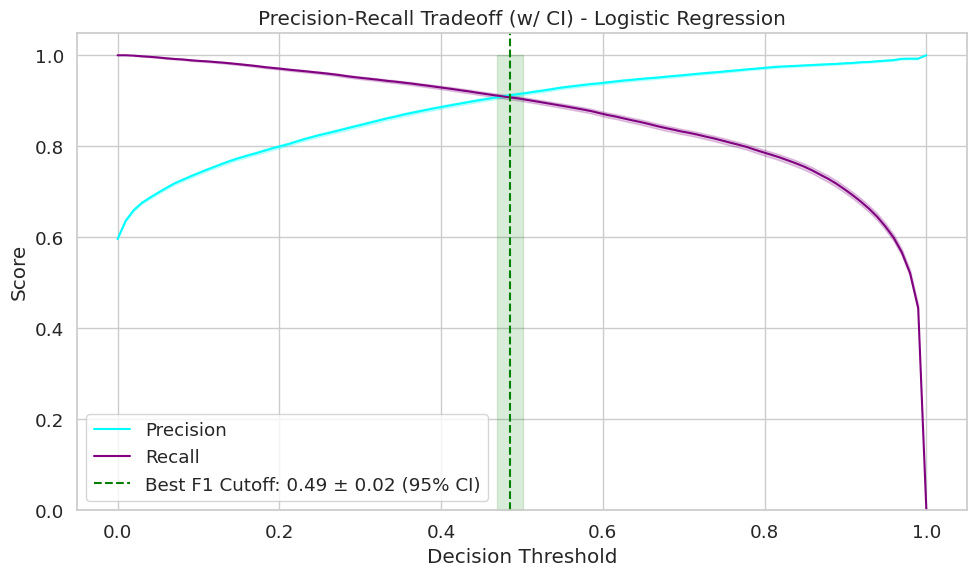

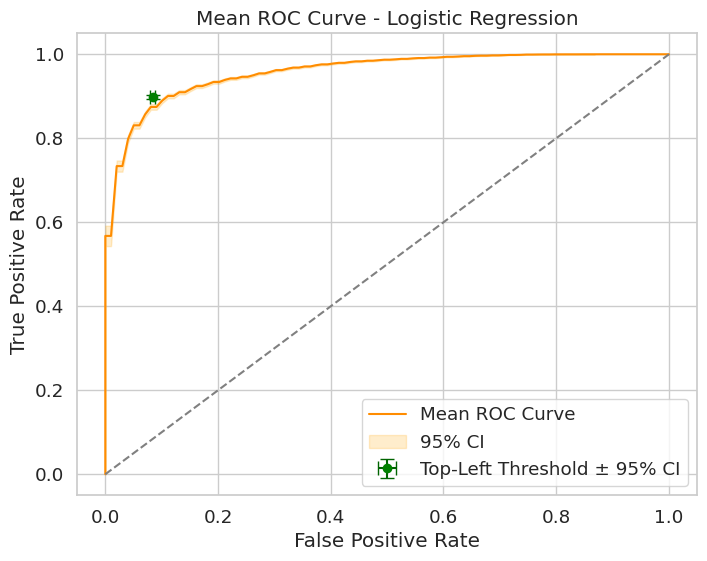


 Mean Top-Left Threshold (ROC): 0.56 ± 0.01 (95% CI)


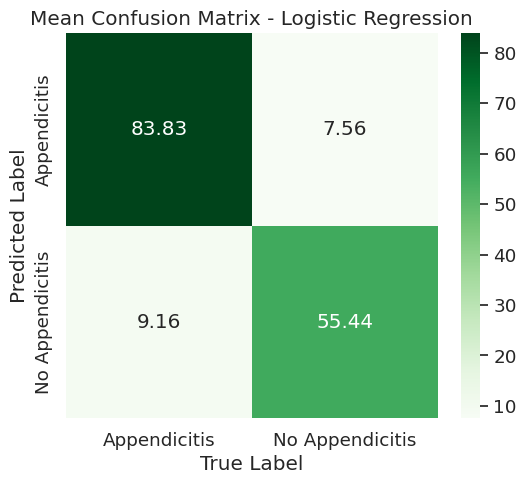

In [48]:
num_cols = X_REDUCED.select_dtypes(exclude=['object', 'category']).columns.tolist()

logreg_model = LogisticRegression(max_iter=10000, random_state=2025)

logreg_results, best_logreg = monte_carlo_cv_with_plot(
    model=logreg_model,
    param_grid=None,  # No tuning
    X=X_REDUCED,
    y=y,
    model_name="Logistic Regression",
    num_iterations=200
)

# Save results
monte_carlo_results["Logistic Regression"].to_csv(f"{save_path_c_f}/logistic_regression_mccv_results.csv", index=False)
logreg_results.to_csv(f"{save_path_c_f}/logistic_regression_summary.csv")


- **Features Used:**
  - Reduced predictors from the correlation analysis.
  - `Age`, `BMI`, `Length_of_Stay`, `Alvarado_Score`, `Appendix_Diameter`, `Body_Temperature`, `WBC_Count`, `Neutrophil_Percentage`, `RBC_Count`, `Hemoglobin`, `RDW`, `Thrombocyte_Count`, `CRP`, `Sex`, `Appendix_on_US`, `Migratory_Pain`, `Lower_Right_Abd_Pain`, `Contralateral_Rebound_Tenderness`, `Coughing_Pain`, `Nausea`, `Loss_of_Appetite`, `Neutrophilia`, `Ketones_in_Urine`, `RBC_in_Urine`, `WBC_in_Urine`, `Dysuria`, `Stool`, `Peritonitis`, `Psoas_Sign`, `Ipsilateral_Rebound_Tenderness`, `US_Performed`, `Free_Fluids`
  - These features encompass a broad clinical picture, combining patient demographics, clinical symptoms, laboratory findings, and ultrasound imaging results.

- **Best Hyperparameters:**
  - No hyperparameter tuning was necessary for Logistic Regression.

- **Mean F1 Score (Optimal Threshold = 0.49 ± 0.02):**
  - **F1 Score:** 0.909 ± 0.021

- **Precision-Recall Trade-off Discussion:**
  - The Precision-Recall curve identified an optimal decision threshold around 0.49.
  - Precision and recall were well-balanced near this threshold, with **recall slightly favoured** — a clinically appropriate choice in appendicitis diagnosis where **missing a true case (false negative)** could have serious consequences.
  - The model's behaviour suggests a low rate of missed diagnoses while maintaining a strong ability to rule out patients without appendicitis.

- **Mean ROC Curve and AUC Discussion:**
  - The ROC curve was strong and smooth, achieving a **Mean AUC of 0.958 ± 0.013**, indicating excellent discriminative performance.
  - The Top-Left threshold selected by ROC analysis was close to 0.56, aligning reasonably with the F1-optimal threshold found from Precision-Recall tradeoff.
  - This indicates that the model is not only accurate, but also    well-calibrated for clinical use.

- **Other Metrics (at F1-optimal threshold ~0.49):**
  - **Accuracy:** 0.893 ± 0.024
  - **Precision:** 0.918 ± 0.024
  - **Recall:** 0.901 ± 0.033

- **Confusion Matrix Insights:**
  - On average across Monte Carlo iterations:
    - 83.8% of patients with appendicitis were correctly identified.
    - Only 7.6% of patients without appendicitis were incorrectly diagnosed.
    - The false negative rate was kept low (~9%), supporting the model's use in
     screening setting where sensitivity is critical.

- **Advantages of Logistic Regression:**
  - High interpretability: coefficients provide direct insight into feature importance.
  - Probabilistic output allows for flexible decision threshold adjustment based on clinical risk tolerance.
  - Computationally efficient and easy to deploy in real-time hospital settings.
  - Particularly useful when needing transparency for clinical adoption and auditing.

- **Disadvantages of Logistic Regression:**
  - Assumes a linear relationship between features and log-odds, which may oversimplify complex clinical presentations.
  - May underperform compared to more flexible models when important feature interactions exist.
  - Performance can still be influenced by multicollinearity between laboratory and imaging variables if not properly regularised.

> **Note:**  
> The green marker on the ROC curve denotes the mean Top-Left threshold — the average point closest to ideal sensitivity and specificity across all Monte Carlo iterations.  
> Threshold optimization was important for balancing sensitivity (recall) and specificity in the appendicitis diagnosis setting, where false negatives carry greater clinical risk.


**Severtiy**

In [52]:
# Select only patients who were diagnosed with appendicitis
appendicitis_patients = y_full["Diagnosis"] == "appendicitis"

# Filter X and y for severity task
X_severity = X[appendicitis_patients]
X_severity_reduced = X_REDUCED[appendicitis_patients]
y_severity = y_full["Severity"][appendicitis_patients]


In [53]:
y2=y_severity
def encode_binary_labels(y):
    if isinstance(y, (pd.Series, np.ndarray)):
        unique_labels = np.unique(y)
        if "complicated" in unique_labels and "uncomplicated" in unique_labels:
            print("🔁 Converting 'complicated' to 1 and 'uncomplicated' to 0...")
            return pd.Series(y).replace({"complicated": 1, "uncomplicated": 0})
        elif sorted(unique_labels) == [0, 1]:
            print("✔ Labels are already correctly encoded (0=uncomplicated, 1=complicated).")
            return pd.Series(y)
        else:
            print(f"⚠ Warning: Unexpected labels {unique_labels}. Please check!")
            return pd.Series(y)
    else:
        raise TypeError("Input must be a pandas Series or numpy array.")

y2 = encode_binary_labels(y2)


🔁 Converting 'complicated' to 1 and 'uncomplicated' to 0...


Monte Carlo CV - Logistic Regression M:   1%|          | 2/200 [00:00<00:12, 15.44it/s]


 Monte Carlo Iteration 1/200...

 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...


Monte Carlo CV - Logistic Regression M:  25%|██▌       | 50/200 [00:03<00:10, 14.98it/s]


 Monte Carlo Iteration 50/200...

 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...


Monte Carlo CV - Logistic Regression M:  51%|█████     | 102/200 [00:06<00:06, 15.72it/s]


 Monte Carlo Iteration 100/200...

 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...


Monte Carlo CV - Logistic Regression M:  75%|███████▌  | 150/200 [00:10<00:04, 11.24it/s]


 Monte Carlo Iteration 150/200...

 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...


Monte Carlo CV - Logistic Regression M: 100%|██████████| 200/200 [00:14<00:00, 13.75it/s]


 Monte Carlo Iteration 200/200...

 Training LogisticRegression with Monte Carlo CV (No Hyperparameter)...

 Monte Carlo CV Results


Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.876          0.03     0.933    0.025           0.798   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results          0.076        0.705       0.097    0.744   0.068

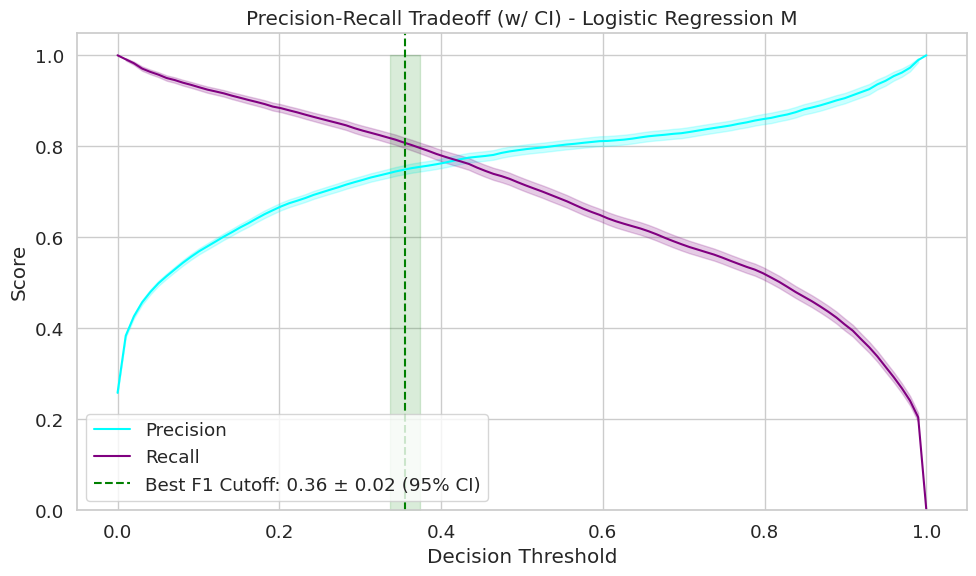

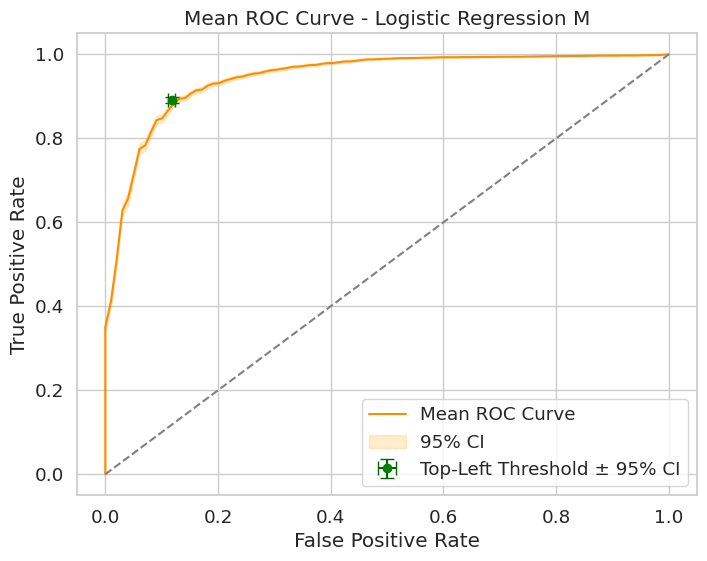


 Mean Top-Left Threshold (ROC): 0.27 ± 0.01 (95% CI)


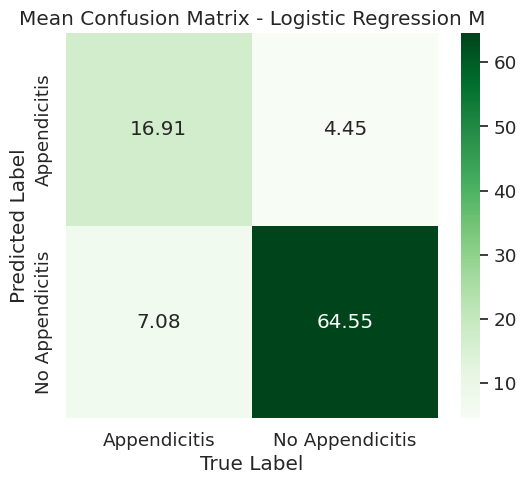

In [54]:
num_cols = X_severity_reduced.select_dtypes(exclude=['object', 'category']).columns.tolist()

logreg_model = LogisticRegression(max_iter=1000, random_state=2025)

logreg_resultsM, best_logregM = monte_carlo_cv_with_plot(
    model=logreg_model,
    param_grid=None,  # No tuning
    X=X_severity_reduced,
    y=y2,
    model_name="Logistic Regression M",
    num_iterations=200
)

# Save results
monte_carlo_results["Logistic Regression M"].to_csv(f"{save_path_c_m}/logistic_regression_mccv_results.csv", index=False)
logreg_resultsM.to_csv(f"{save_path_c_m}/logistic_regression_summary.csv")


**Appendicitis Severity Prediction**

- **Clinical Motivation:**
  - Predicting the severity of appendicitis (complicated vs non-complicated) is important to optimise clinical management.
  - Complicated appendicitis often requires urgent surgical intervention, aggressive antibiotics, and careful perioperative monitoring to prevent serious complications such as sepsis or peritonitis.
  - Early identification allows clinicians to prioritise high-risk patients, allocate surgical resources appropriately, and improve patient outcomes.

- **Features Used:**
  - The same structured clinical, laboratory, and imaging-derived features used in the diagnosis model were applied for severity prediction.
  - These variables were expected to carry additional signal related to disease severity (raised inflammatory markers, ultrasound findings).

- **Best Hyperparameters:**
  - No hyperparameter tuning for this model.

- **Mean F1 Score (Optimal Threshold = 0.36 ± 0.02):**
  - **F1 Score:** 0.744 ± 0.068

- **Precision-Recall Trade-off Discussion:**
  - The Precision-Recall curve identified an optimal threshold of approximately 0.36.
  - This threshold prioritised **higher recall**, which is clinically justified: missing a case of complicated appendicitis is riskier than incorrectly classifying a non-complicated case.
  - However, the tradeoff led to a reduction in precision, meaning some non-complicated cases were overclassified as complicated. This is not ideal, as it may lead to unnecessary invasive surgery, which carries its own risks and patient burden.

- **Mean ROC Curve and AUC Discussion:**
  - The model demonstrated strong class separation with a **Mean AUC of 0.933 ± 0.025**.
  - The ROC curve showed a smooth and consistent separation across Monte Carlo splits, suggesting reliable performance.
  - The Top-Left threshold was similar to the F1-optimal threshold, reinforcing the decision to prioritise recall.

- **Other Metrics (at F1-optimal threshold ~0.33):**
  - **Mean Accuracy:** 0.876 ± 0.03
  - **Precision:** 0.798 ± 0.076
  - **Recall:** 0.705 ± 0.097

- **Advantages of Logistic Regression for Severity Prediction:**
  - Transparent and interpretable output, allowing clinical insight into feature contributions.
  - Fast and computationally lightweight, suitable for clinical decision support tools in real-time hospital systems.

- **Challenges and Limitations:**
  - Overlap in clinical presentation between complicated and non-complicated cases inherently limits model discriminability.
  - Some complicated appendicitis cases present with mild symptoms, leading to missed cases despite model tuning.
  - Future improvements could involve using dynamic trends or advanced imaging modalities (CT findings) to better capture subtle severity signals.



## 3.4 Elastic Net & Lasso reguralisation

**Diagnosis**

Monte Carlo CV - Elastic Net:   0%|          | 0/200 [00:00<?, ?it/s]


 Monte Carlo Iteration 1/200...

 Hyperparameter tuning for Elastic Net (Optimizing F1-Score)...
 Best Parameters: {'C': 0.1, 'l1_ratio': 0.95}
 Best Cross-Validation F1 Score: 0.9229


Monte Carlo CV - Elastic Net:  24%|██▍       | 49/200 [09:30<30:43, 12.21s/it]


 Monte Carlo Iteration 50/200...

 Hyperparameter tuning for Elastic Net (Optimizing F1-Score)...
 Best Parameters: {'C': 0.1, 'l1_ratio': 1.0}
 Best Cross-Validation F1 Score: 0.9175


Monte Carlo CV - Elastic Net:  50%|████▉     | 99/200 [20:39<23:10, 13.77s/it]


 Monte Carlo Iteration 100/200...

 Hyperparameter tuning for Elastic Net (Optimizing F1-Score)...
 Best Parameters: {'C': 1.0, 'l1_ratio': 0.95}
 Best Cross-Validation F1 Score: 0.9114


Monte Carlo CV - Elastic Net:  74%|███████▍  | 149/200 [29:56<10:51, 12.77s/it]


 Monte Carlo Iteration 150/200...

 Hyperparameter tuning for Elastic Net (Optimizing F1-Score)...


Monte Carlo CV - Elastic Net:  75%|███████▌  | 150/200 [30:08<10:18, 12.36s/it]

 Best Parameters: {'C': 0.1, 'l1_ratio': 0.95}
 Best Cross-Validation F1 Score: 0.9053


Monte Carlo CV - Elastic Net: 100%|█████████▉| 199/200 [39:25<00:10, 10.90s/it]


 Monte Carlo Iteration 200/200...

 Hyperparameter tuning for Elastic Net (Optimizing F1-Score)...
 Best Parameters: {'C': 1.0, 'l1_ratio': 1.0}
 Best Cross-Validation F1 Score: 0.9086


Monte Carlo CV - Elastic Net: 100%|██████████| 200/200 [39:35<00:00, 11.88s/it]


 Monte Carlo CV Results


Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.898         0.022     0.961    0.012           0.924   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results          0.023        0.904       0.032    0.914   0.019


🏆 Most Common Best Hyperparameters:
1. Params: {'C': 1.0, 'l1_ratio': 1.0} | Chosen: 61 out of 200 times
2. Params: {'C': 1.0, 'l1_ratio': 0.95} | Chosen: 51 out of 200 times
3. Params: {'C': 1.0, 'l1_ratio': 0.8} | Chosen: 39 out of 200 times
4. Params: {'C': 0.1, 'l1_ratio': 1.0} | Chosen: 27 out of 200 times
5. Params: {'C': 0.1, 'l1_ratio': 0.95} | Chosen: 16 out of 200 times
6. Params: {'C': 0.1, 'l1_ratio': 0.8} | Chosen: 6 out of 200 times


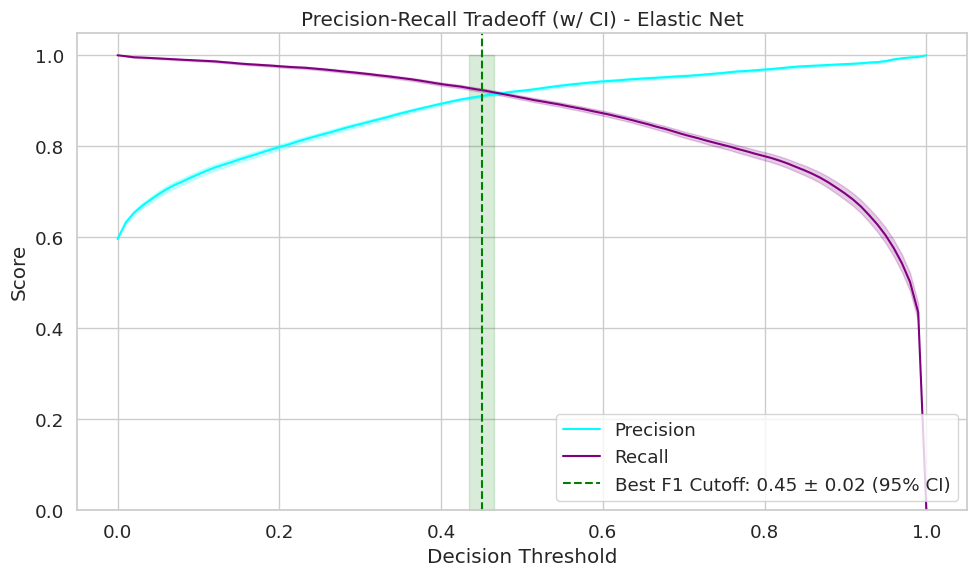

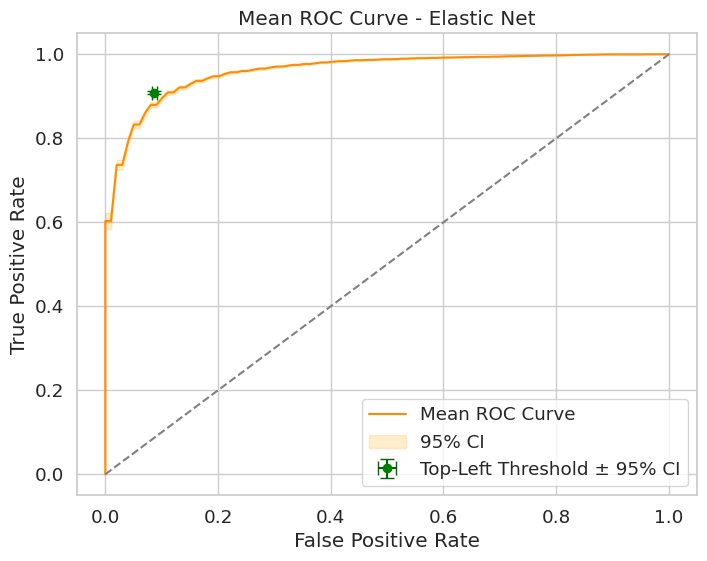


 Mean Top-Left Threshold (ROC): 0.54 ± 0.01 (95% CI)


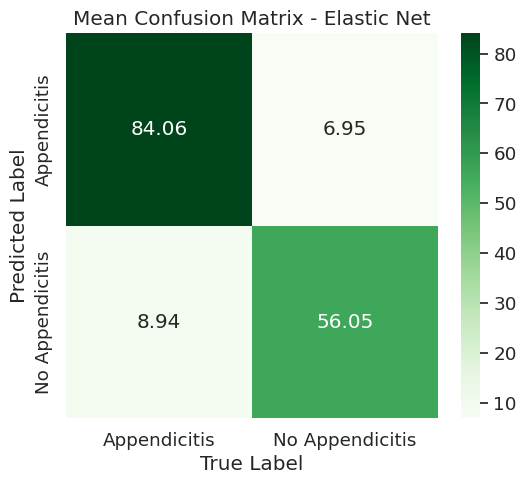

In [51]:
num_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()
best_hyperparams_counter = defaultdict(int)  # Tracks best hyperparameters

elastic_model = LogisticRegression(
    penalty="elasticnet",solver="saga",
    random_state=2025,max_iter=10000)

elastic_param_grid = {
    "l1_ratio": [.8,.95,1.0],  # 0=L2 only, 1=L1 only
    "C": [0.1, 1.0],     # Lower = stronger regularization
}

elastic_results, best_elastic = monte_carlo_cv_with_plot(
    elastic_model,
    elastic_param_grid,
    X=X,
    y=y,
    model_name="Elastic Net",
    num_iterations=200
)
elastic_results.to_csv(f"{save_path_c_f}/elastic_net_summary.csv")
monte_carlo_results["Elastic Net"].to_csv(f"{save_path_c_f}/elastic_net_mccv_results.csv", index=False)

Lasso (L1-Regularised Logistic Regression) - Appendicitis Diagnosis

> **Note on Hyperparameter Tuning:**  
> An initial Monte Carlo Cross-Validation run with **20 iterations** was performed across a wide hyperparameter grid.  
> After review, the most commonly selected combinations were retained for the final **200-iteration** evaluation.
>
> **Most Common Best Hyperparameters:**
> - `C = 1.0`, `l1_ratio = 1.0` (chosen 61/200 times) — pure Lasso
> - `C = 1.0`, `l1_ratio = 0.95` (chosen 51/200 times)

- **Clinical Motivation:**
  - Lasso regularisation encourages sparsity by shrinking less important feature coefficients to zero, offering a simpler, more interpretable model.
  - In clinical settings, this helps prioritise the most relevant features for appendicitis diagnosis while controlling overfitting.

- **Features Used:**
  - All available features were retained, with L1 regularisation naturally performing feature selection during model fitting.

- **Performance Overview (Optimal Threshold ≈ 0.45 ± 0.02):**
  - **F1 Score:** 0.914 ± 0.019
  - **AUC:** 0.961 ± 0.012
  - **Accuracy:** 0.898 ± 0.022
  - **Precision:** 0.924 ± 0.023
  - **Recall:** 0.904 ± 0.032

- **Precision-Recall and ROC Analysis:**
  - The optimal threshold (≈0.45) balanced precision and recall effectively.
  - High AUC indicated excellent overall discrimination, with minimal compromise between sensitivity and specificity.

- **Confusion Matrix Insights:**
  - The model correctly identified 84.1% of appendicitis cases on average.
  - False positive and false negative rates remained low.



**Severity**

Monte Carlo CV - Elastic Net M:   0%|          | 0/200 [00:00<?, ?it/s]


 Monte Carlo Iteration 1/200...

 Hyperparameter tuning for Elastic Net M (Optimizing F1-Score)...


Monte Carlo CV - Elastic Net M:   0%|          | 1/200 [00:04<14:58,  4.51s/it]

 Best Parameters: {'C': 1.0, 'l1_ratio': 0.8}
 Best Cross-Validation F1 Score: 0.7659


Monte Carlo CV - Elastic Net M:  24%|██▍       | 49/200 [04:13<10:49,  4.30s/it]


 Monte Carlo Iteration 50/200...

 Hyperparameter tuning for Elastic Net M (Optimizing F1-Score)...


Monte Carlo CV - Elastic Net M:  25%|██▌       | 50/200 [04:16<09:39,  3.86s/it]

 Best Parameters: {'C': 1.0, 'l1_ratio': 0.95}
 Best Cross-Validation F1 Score: 0.7555


Monte Carlo CV - Elastic Net M:  50%|████▉     | 99/200 [08:09<11:27,  6.81s/it]


 Monte Carlo Iteration 100/200...

 Hyperparameter tuning for Elastic Net M (Optimizing F1-Score)...
 Best Parameters: {'C': 1.0, 'l1_ratio': 1.0}
 Best Cross-Validation F1 Score: 0.8298


Monte Carlo CV - Elastic Net M:  74%|███████▍  | 149/200 [11:51<04:40,  5.49s/it]


 Monte Carlo Iteration 150/200...

 Hyperparameter tuning for Elastic Net M (Optimizing F1-Score)...
 Best Parameters: {'C': 1.0, 'l1_ratio': 1.0}
 Best Cross-Validation F1 Score: 0.7413


Monte Carlo CV - Elastic Net M: 100%|█████████▉| 199/200 [15:48<00:04,  4.43s/it]


 Monte Carlo Iteration 200/200...

 Hyperparameter tuning for Elastic Net M (Optimizing F1-Score)...
 Best Parameters: {'C': 1.0, 'l1_ratio': 0.95}
 Best Cross-Validation F1 Score: 0.7985


Monte Carlo CV - Elastic Net M: 100%|██████████| 200/200 [15:51<00:00,  4.76s/it]


 Monte Carlo CV Results


Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.878         0.031     0.937    0.024           0.801   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results          0.082        0.714       0.098     0.75   0.069


🏆 Most Common Best Hyperparameters:
1. Params: {'C': 1.0, 'l1_ratio': 0.8} | Chosen: 76 out of 200 times
2. Params: {'C': 1.0, 'l1_ratio': 0.95} | Chosen: 70 out of 200 times
3. Params: {'C': 1.0, 'l1_ratio': 1.0} | Chosen: 38 out of 200 times
4. Params: {'C': 0.1, 'l1_ratio': 0.8} | Chosen: 9 out of 200 times
5. Params: {'C': 0.1, 'l1_ratio': 0.95} | Chosen: 5 out of 200 times
6. Params: {'C': 0.1, 'l1_ratio': 1.0} | Chosen: 2 out of 200 times


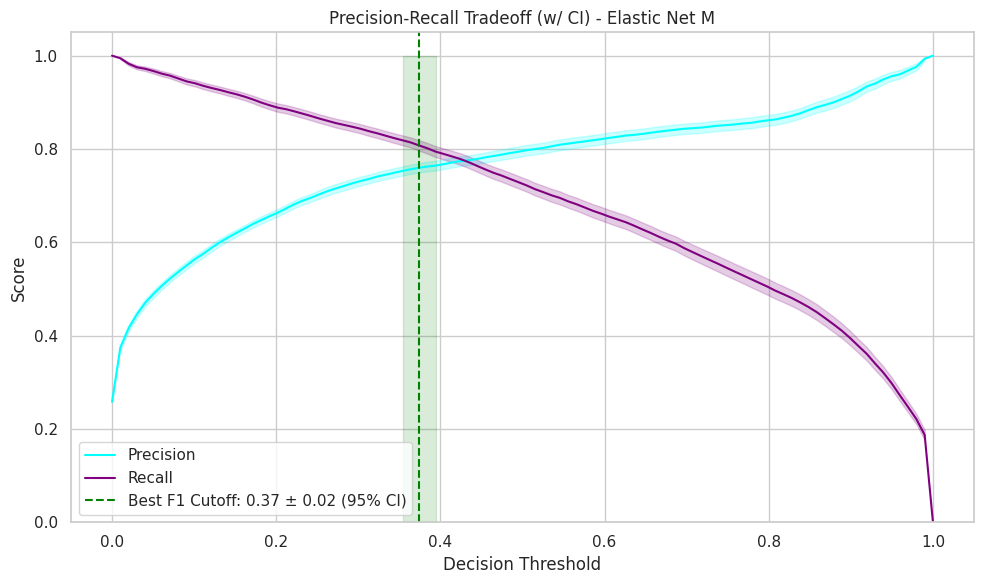

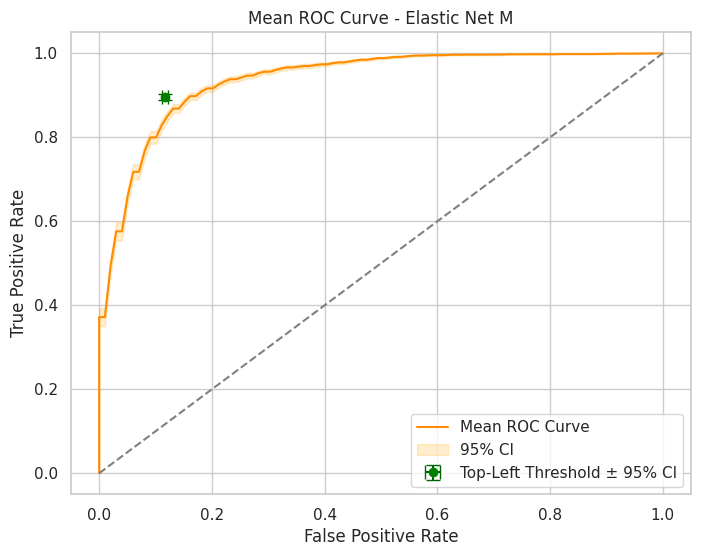


 Mean Top-Left Threshold (ROC): 0.28 ± 0.02 (95% CI)


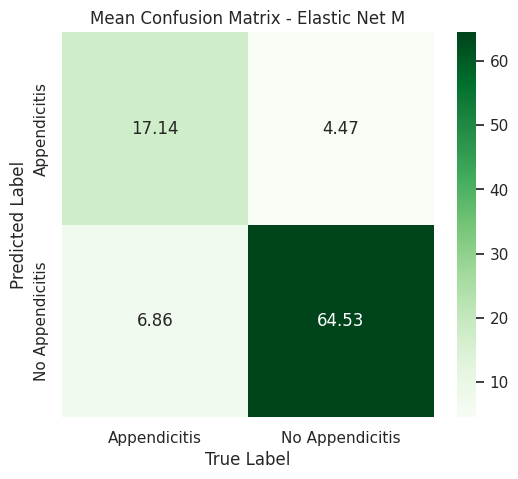

In [107]:
elastic_model = LogisticRegression(
    penalty="elasticnet",solver="saga",
    random_state=2025,max_iter=3000)
best_hyperparams_counter = defaultdict(int)  # Tracks best hyperparameters

elastic_resultsM, best_elasticM = monte_carlo_cv_with_plot(
    elastic_model,
    elastic_param_grid,
    X=X_severity,
    y=y2,
    model_name="Elastic Net M",
    num_iterations=200
)
elastic_resultsM.to_csv(f"{save_path_c_m}/elastic_net_summary.csv")
monte_carlo_results["Elastic Net M"].to_csv(f"{save_path_c_m}/elastic_net_mccv_results.csv", index=False)

Elastic Net - Appendicitis Severity Classification

> **Note on Hyperparameter Tuning:**  
> A Monte Carlo Cross-Validation (200 iterations) was used for model evaluation.  
> An initial wider hyperparameter search found that the following combinations were most commonly selected:
> - `C = 1.0`, `l1_ratio = 0.8` (chosen 76 times)
> - `C = 1.0`, `l1_ratio = 0.95` (chosen 70 times)

- **Clinical Motivation:**  
  Elastic Net combines L1 (Lasso) and L2 (Ridge) penalties, providing regularisation that can handle correlated predictors while still allowing for feature selection.  
  This is valuable in clinical data where some predictors may overlap in informational content.

- **Features Used:**  
  All available clinical features were included.  
  Elastic Net's regularisation inherently reduces overfitting by shrinking less important coefficients towards zero.

- **Best Hyperparameters:**  
  The model predominantly favoured mild to moderate L1 regularisation (`l1_ratio ≈ 0.8`), suggesting that some feature sparsity helped improve generalisation without discarding useful predictors.

- **Performance Metrics (Optimal Threshold = 0.37 ± 0.02):**
  - **Mean F1 Score:** 0.750 ± 0.069
  - **Mean Accuracy:** 0.878 ± 0.031
  - **Mean AUC:** 0.937 ± 0.024
  - **Mean Precision:** 0.801 ± 0.082
  - **Mean Recall:** 0.714 ± 0.098

- **Precision-Recall Trade-off Discussion:**  
  - The optimal threshold (0.37) shifted lower than 0.5, favouring improved sensitivity to complicated cases.
  - Precision remained slightly higher than recall across thresholds, indicating a cautious model with a lower false positive rate.

- **Mean ROC Curve and AUC Discussion:**  
  - The ROC curve achieved a **Mean AUC of 0.937**, demonstrating strong discriminative ability between uncomplicated and complicated appendicitis cases.
  - The ROC optimal threshold aligned closely with the F1-optimal point.

- **Confusion Matrix Insights:**
  - True complicated cases were correctly identified ~71% of the time.
  - Misclassifications skewed towards false negatives (complicated cases missed) rather than false positives.

- **Advantages of Elastic Net:**
  - Good generalisation to unseen data.
  - Provides interpretable coefficients important for clinical explainability.
  - Handles multicollinearity between symptoms/lab findings effectively.

- **Challenges and Limitations:**
  - Linear decision boundary may limit detection of subtle non-linear patterns.
  - Recall for complicated cases, while reasonable, could still be improved.


## 3.5 Random Forest

**Diagnosis**

Monte Carlo CV - Random Forest:   0%|          | 0/200 [00:00<?, ?it/s]


 Monte Carlo Iteration 1/200...

 Hyperparameter tuning for Random Forest (Optimizing F1-Score)...


Monte Carlo CV - Random Forest:   0%|          | 1/200 [00:01<05:41,  1.72s/it]

 Best Parameters: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 80}
 Best Cross-Validation F1 Score: 0.9516


Monte Carlo CV - Random Forest:  24%|██▍       | 49/200 [01:34<04:57,  1.97s/it]


 Monte Carlo Iteration 50/200...

 Hyperparameter tuning for Random Forest (Optimizing F1-Score)...


Monte Carlo CV - Random Forest:  25%|██▌       | 50/200 [01:35<04:42,  1.88s/it]

 Best Parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 80}
 Best Cross-Validation F1 Score: 0.9417


Monte Carlo CV - Random Forest:  50%|████▉     | 99/200 [03:09<03:34,  2.12s/it]


 Monte Carlo Iteration 100/200...

 Hyperparameter tuning for Random Forest (Optimizing F1-Score)...


Monte Carlo CV - Random Forest:  50%|█████     | 100/200 [03:11<03:23,  2.04s/it]

 Best Parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 80}
 Best Cross-Validation F1 Score: 0.9210


Monte Carlo CV - Random Forest:  74%|███████▍  | 149/200 [04:46<01:48,  2.12s/it]


 Monte Carlo Iteration 150/200...

 Hyperparameter tuning for Random Forest (Optimizing F1-Score)...


Monte Carlo CV - Random Forest:  75%|███████▌  | 150/200 [04:48<01:44,  2.09s/it]

 Best Parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 80}
 Best Cross-Validation F1 Score: 0.9382


Monte Carlo CV - Random Forest: 100%|█████████▉| 199/200 [06:27<00:02,  2.04s/it]


 Monte Carlo Iteration 200/200...

 Hyperparameter tuning for Random Forest (Optimizing F1-Score)...


Monte Carlo CV - Random Forest: 100%|██████████| 200/200 [06:28<00:00,  1.94s/it]

 Best Parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 80}
 Best Cross-Validation F1 Score: 0.9325

 Monte Carlo CV Results


Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.939         0.019     0.981    0.009           0.947   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results          0.021        0.951       0.024    0.949   0.016


🏆 Most Common Best Hyperparameters:
1. Params: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 80} | Chosen: 113 out of 200 times
2. Params: {'max_depth': 8, 'n_estimators': 80, 'min_samples_split': 2} | Chosen: 87 out of 200 times


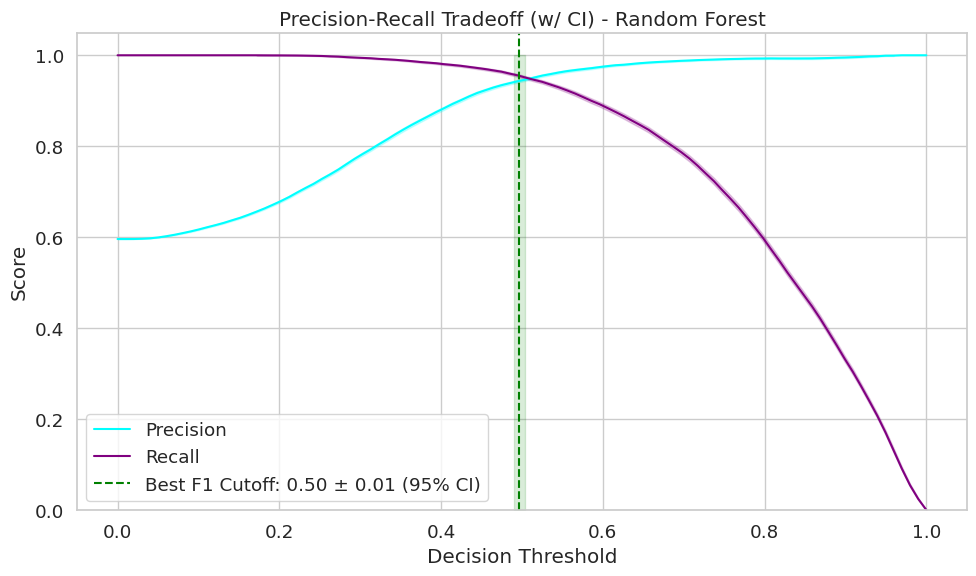

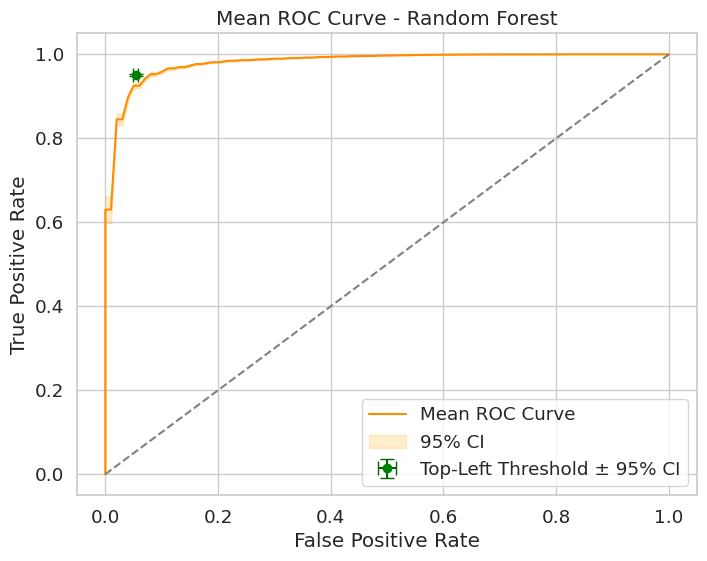


 Mean Top-Left Threshold (ROC): 0.53 ± 0.01 (95% CI)


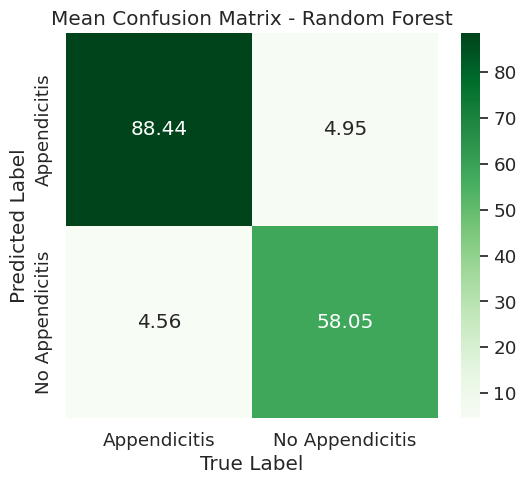

In [57]:
rf_param_grid = {
    "n_estimators": [80],
    "max_depth": [8],
    "min_samples_split": [2, 5]
}
best_hyperparams_counter = defaultdict(int)  # Tracks best hyperparameters

rf_model = RandomForestClassifier(random_state=2025)
rf_results, best_rf_model = monte_carlo_cv_with_plot(rf_model,
                                                     rf_param_grid,
                                                     X, y, model_name="Random Forest",
                                                     num_iterations=200)

monte_carlo_results["Random Forest"].to_csv(f"{save_path_c_f}/random_forest_mccv_results.csv", index=False)
rf_results.to_csv(f"{save_path_c_f}/random_forest_summary.csv")

Random Forest - Appendicitis Diagnosis

> **Note on Hyperparameter Tuning:**  
> An initial Monte Carlo Cross-Validation run with **20 iterations** was performed to explore a broad hyperparameter space.  
> Based on early results, the two most common parameter combinations were selected for the final **200-iteration** evaluation.
>
> **Most Common Best Hyperparameters:**
> - `max_depth=8`, `min_samples_split=5`, `n_estimators=80` (chosen 113/200 times)
> - `max_depth=8`, `min_samples_split=2`, `n_estimators=80` (chosen 87/200 times)


- **Clinical Motivation:**
  - Random Forests are highly effective for structured clinical data, handling non-linearities, and automatic feature selection.
  - They are particularly well-suited for appendicitis diagnosis, where complex interactions between symptoms, lab values, and imaging findings exist.

- **Features Used:**
  - All available clinical, laboratory, and imaging-derived features were included.

- **Performance Overview (Optimal Threshold ≈ 0.50 ± 0.01):**
  - **F1 Score:** 0.949 ± 0.016
  - **AUC:** 0.981 ± 0.009
  - **Accuracy:** 0.939 ± 0.019
  - **Precision:** 0.947 ± 0.021
  - **Recall:** 0.951 ± 0.024

- **Precision-Recall and ROC Analysis:**
  - The F1-optimal threshold was approximately 0.50, suggesting excellent balance between precision and recall.
  - The ROC curve showed near-perfect separation, with a very high AUC indicating strong discriminative power.

- **Confusion Matrix Insights:**
  - The model correctly identified 88.4% of appendicitis cases on average.
  - False positive and false negative rates were both extremely low.

- **Advantages of Random Forest:**
  - Captures complex non-linear relationships without heavy preprocessing.
  - Naturally handles feature interactions.
  - Resistant to overfitting when tuned correctly.

- **Challenges and Limitations:**
  - Less interpretable compared to logistic regression or lasso models.
  - Important features could be harder to extract without further feature importance analysis.



**Severity**

Monte Carlo CV - Random Forest M:   0%|          | 0/200 [00:00<?, ?it/s]


 Monte Carlo Iteration 1/200...

 Hyperparameter tuning for Random Forest M (Optimizing F1-Score)...


Monte Carlo CV - Random Forest M:   0%|          | 1/200 [00:01<05:17,  1.60s/it]

 Best Parameters: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 80}
 Best Cross-Validation F1 Score: 0.7672


Monte Carlo CV - Random Forest M:  24%|██▍       | 49/200 [01:24<04:17,  1.70s/it]


 Monte Carlo Iteration 50/200...

 Hyperparameter tuning for Random Forest M (Optimizing F1-Score)...


Monte Carlo CV - Random Forest M:  25%|██▌       | 50/200 [01:26<04:06,  1.64s/it]

 Best Parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 80}
 Best Cross-Validation F1 Score: 0.7445


Monte Carlo CV - Random Forest M:  50%|████▉     | 99/200 [02:49<02:47,  1.66s/it]


 Monte Carlo Iteration 100/200...

 Hyperparameter tuning for Random Forest M (Optimizing F1-Score)...


Monte Carlo CV - Random Forest M:  50%|█████     | 100/200 [02:51<02:40,  1.60s/it]

 Best Parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 80}
 Best Cross-Validation F1 Score: 0.7976


Monte Carlo CV - Random Forest M:  74%|███████▍  | 149/200 [04:14<01:24,  1.66s/it]


 Monte Carlo Iteration 150/200...

 Hyperparameter tuning for Random Forest M (Optimizing F1-Score)...


Monte Carlo CV - Random Forest M:  75%|███████▌  | 150/200 [04:15<01:20,  1.61s/it]

 Best Parameters: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 80}
 Best Cross-Validation F1 Score: 0.7565


Monte Carlo CV - Random Forest M: 100%|█████████▉| 199/200 [05:39<00:01,  1.68s/it]


 Monte Carlo Iteration 200/200...

 Hyperparameter tuning for Random Forest M (Optimizing F1-Score)...


Monte Carlo CV - Random Forest M: 100%|██████████| 200/200 [05:40<00:00,  1.70s/it]

 Best Parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 80}
 Best Cross-Validation F1 Score: 0.7737

 Monte Carlo CV Results


Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.887         0.028     0.934    0.029           0.866   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results          0.071        0.669       0.096     0.75   0.071


🏆 Most Common Best Hyperparameters:
1. Params: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 80} | Chosen: 107 out of 200 times
2. Params: {'max_depth': 8, 'n_estimators': 80, 'min_samples_split': 2} | Chosen: 93 out of 200 times


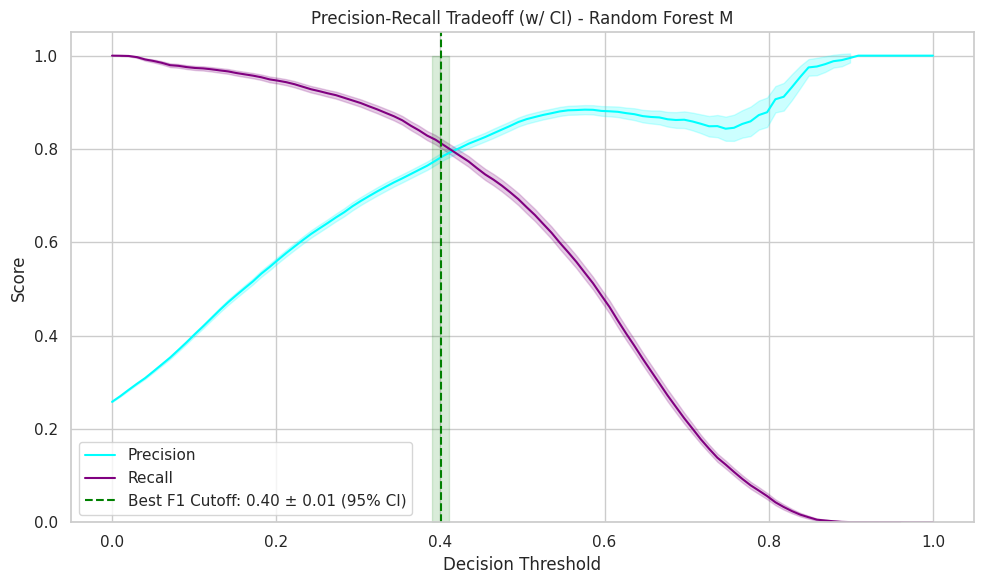

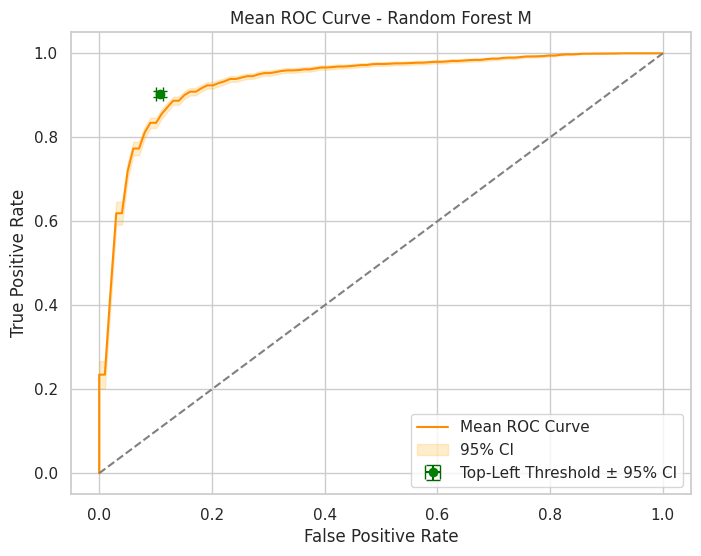


 Mean Top-Left Threshold (ROC): 0.34 ± 0.01 (95% CI)


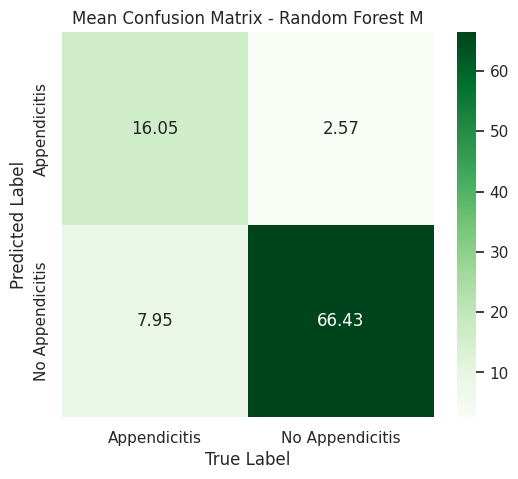

In [108]:
rf_model = RandomForestClassifier(random_state=2025)
best_hyperparams_counter = defaultdict(int)  # Tracks best hyperparameters

rf_resultsM, best_rf_modelM = monte_carlo_cv_with_plot(rf_model,
                                                     rf_param_grid,
                                                     X_severity, y2, model_name="Random Forest M",
                                                     num_iterations=200)

monte_carlo_results["Random Forest M"].to_csv(f"{save_path_c_m}/random_forest_mccv_results.csv", index=False)
rf_resultsM.to_csv(f"{save_path_c_m}/random_forest_summary.csv")


Random Forest - Severity Classification

> **Hyperparameter Tuning:**  
> An initial 20-iteration Monte Carlo CV was performed to explore a broad hyperparameter grid. The two most commonly selected combinations for the final 200-iteration evaluation were:
> - `max_depth=8`, `min_samples_split=5`, `n_estimators=80` (chosen 107/200 times)
> - `max_depth=8`, `n_estimators=80`, `min_samples_split=2` (chosen 93/200 times)

> **Features Used:**  
> All available features were included.

> **Performance Summary (Threshold ≈ 0.40 ± 0.01):**
> - **F1 Score:** 0.750 ± 0.071
> - **Accuracy:** 0.887 ± 0.028
> - **AUC:** 0.934 ± 0.029
> - **Precision:** 0.866 ± 0.071
> - **Recall:** 0.669 ± 0.096

> **Discussion:**  
> Random Forest achieved a strong trade-off between precision and recall, with excellent discrimination performance (AUC > 0.93). The model effectively captured nonlinear relationships and feature interactions important for severity classification. However, interpretability was reduced compared to simpler models like Elastic Net, and recall variability across splits indicated some sensitivity in identifying complicated cases.


## 3.6 XGBoost

**Diagnosis**

Monte Carlo CV - XGBoost:   0%|          | 0/200 [00:00<?, ?it/s]


 Monte Carlo Iteration 1/200...

 Hyperparameter tuning for XGBoost (Optimizing F1-Score)...


Monte Carlo CV - XGBoost:   0%|          | 1/200 [00:01<05:18,  1.60s/it]

 Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
 Best Cross-Validation F1 Score: 0.9580


Monte Carlo CV - XGBoost:  24%|██▍       | 49/200 [01:09<04:17,  1.71s/it]


 Monte Carlo Iteration 50/200...

 Hyperparameter tuning for XGBoost (Optimizing F1-Score)...


Monte Carlo CV - XGBoost:  25%|██▌       | 50/200 [01:10<03:52,  1.55s/it]

 Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
 Best Cross-Validation F1 Score: 0.9552


Monte Carlo CV - XGBoost:  50%|████▉     | 99/200 [02:19<02:27,  1.46s/it]


 Monte Carlo Iteration 100/200...

 Hyperparameter tuning for XGBoost (Optimizing F1-Score)...


Monte Carlo CV - XGBoost:  50%|█████     | 100/200 [02:20<02:18,  1.38s/it]

 Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
 Best Cross-Validation F1 Score: 0.9552


Monte Carlo CV - XGBoost:  74%|███████▍  | 149/200 [03:29<01:15,  1.49s/it]


 Monte Carlo Iteration 150/200...

 Hyperparameter tuning for XGBoost (Optimizing F1-Score)...


Monte Carlo CV - XGBoost:  75%|███████▌  | 150/200 [03:30<01:10,  1.42s/it]

 Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
 Best Cross-Validation F1 Score: 0.9540


Monte Carlo CV - XGBoost: 100%|█████████▉| 199/200 [04:40<00:01,  1.37s/it]


 Monte Carlo Iteration 200/200...

 Hyperparameter tuning for XGBoost (Optimizing F1-Score)...


Monte Carlo CV - XGBoost: 100%|██████████| 200/200 [04:41<00:00,  1.41s/it]

 Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
 Best Cross-Validation F1 Score: 0.9533

 Monte Carlo CV Results


Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.952         0.017     0.988    0.006           0.963   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results          0.018        0.957       0.024     0.96   0.014


🏆 Most Common Best Hyperparameters:
1. Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1} | Chosen: 128 out of 200 times
2. Params: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1} | Chosen: 72 out of 200 times


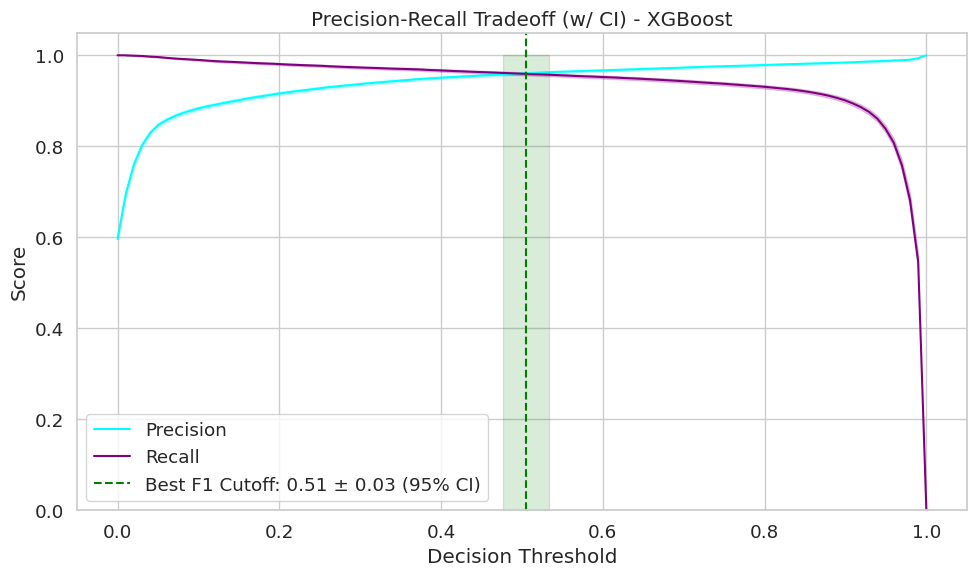

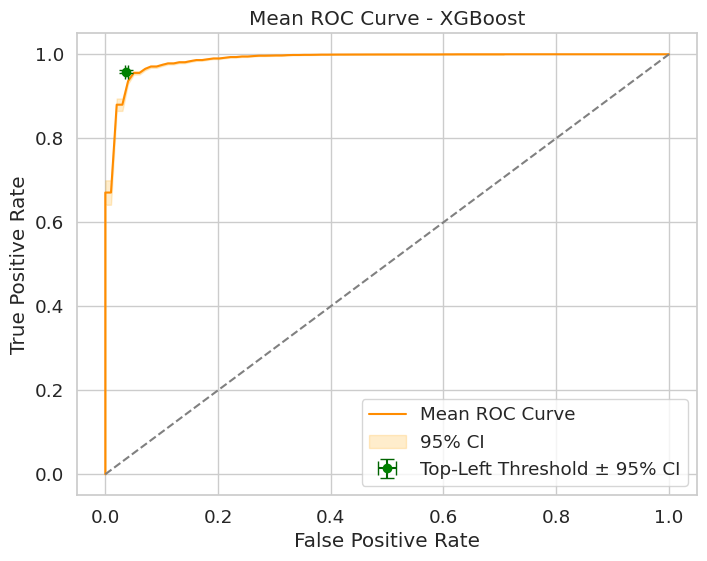


 Mean Top-Left Threshold (ROC): 0.61 ± 0.02 (95% CI)


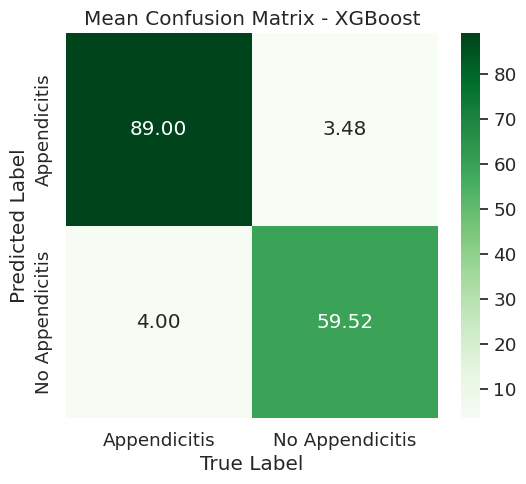

In [58]:
xgb_param_grid = {
    "n_estimators": [100],
    "max_depth": [3, 6],
    "learning_rate": [0.1],
}

xgb_model = XGBClassifier(eval_metric="aucpr", random_state=2025)
best_hyperparams_counter = defaultdict(int)  # Tracks best hyperparameters

xgb_results, best_xgb = monte_carlo_cv_with_plot(
    xgb_model, xgb_param_grid, X, y,
    model_name="XGBoost",
    num_iterations=200
)

monte_carlo_results["XGBoost"].to_csv(f"{save_path_c_f}/XGBoost_mccv_results.csv", index=False)
xgb_results.to_csv(f"{save_path_c_f}/XGBoost_summary.csv")

XGBoost - Appendicitis Diagnosis

> **Note on Hyperparameter Tuning:**  
> An initial Monte Carlo Cross-Validation run with **20 iterations** was done to explore a wide range of hyperparameters.  
> Based on performance, the two most frequently selected parameter sets were retained for the final **200-iteration** evaluation.
>
> **Most Common Best Hyperparameters:**
> - `n_estimators=100`, `max_depth=3`, `learning_rate=0.1` (chosen 128/200 times)
> - `n_estimators=100`, `max_depth=6`, `learning_rate=0.1` (chosen 72/200 times)

- **Clinical Motivation:**
  - XGBoost is a state-of-the-art boosting algorithm that excels on structured tabular data, capturing complex non-linear feature interactions.
  - In appendicitis diagnosis, where subtle patterns across clinical, laboratory, and imaging features must be detected, XGBoost is highly suited.

- **Features Used:**
  - All clinical features were included without prior feature selection, relying on XGBoost's internal structure to manage feature relevance.

- **Performance Overview (Optimal Threshold ≈ 0.51 ± 0.03):**
  - **F1 Score:** 0.960 ± 0.014
  - **AUC:** 0.988 ± 0.006
  - **Accuracy:** 0.952 ± 0.017
  - **Precision:** 0.963 ± 0.018
  - **Recall:** 0.957 ± 0.024

- **Precision-Recall and ROC Analysis:**
  - The F1-optimal threshold was near 0.51, maintaining a very high balance between precision and recall.
  - The shaded area around the mean precision and mean recall lines is almost completely on the lines showing stable results.
  - The ROC curve approached the ideal top-left corner, demonstrating outstanding discriminative ability with minimal false positives and false negatives.


- **Confusion Matrix Insights:**
  - Across all Monte Carlo iterations:
    - Mean TP - 89.0 of appendicitis cases were correctly identified.
    - Mean FP was very low (3.48).
    - Mean FN was minimal (4), important in emergency clinical settings where missing cases can have severe consequences.

- **Advantages of XGBoost:**
  - Captures intricate feature interactions that linear models cannot.
  - Built-in regularisation (shrinkage and column subsampling) prevents overfitting.
  - High predictive accuracy across random train-test splits.

- **Challenges and Limitations:**
  - Model explainability can be limited compared to simpler models like logistic regression.
  - Requires careful hyperparameter tuning for optimal performance.


**Severity**

Monte Carlo CV - XGBoost M:   0%|          | 0/200 [00:00<?, ?it/s]


 Monte Carlo Iteration 1/200...

 Hyperparameter tuning for XGBoost M (Optimizing F1-Score)...


Monte Carlo CV - XGBoost M:   0%|          | 1/200 [00:00<02:34,  1.28it/s]

 Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
 Best Cross-Validation F1 Score: 0.7585


Monte Carlo CV - XGBoost M:  24%|██▍       | 49/200 [00:35<02:00,  1.26it/s]


 Monte Carlo Iteration 50/200...

 Hyperparameter tuning for XGBoost M (Optimizing F1-Score)...


Monte Carlo CV - XGBoost M:  25%|██▌       | 50/200 [00:36<01:50,  1.36it/s]

 Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
 Best Cross-Validation F1 Score: 0.7509


Monte Carlo CV - XGBoost M:  50%|████▉     | 99/200 [01:09<01:01,  1.65it/s]


 Monte Carlo Iteration 100/200...

 Hyperparameter tuning for XGBoost M (Optimizing F1-Score)...


Monte Carlo CV - XGBoost M:  50%|█████     | 100/200 [01:10<01:00,  1.65it/s]

 Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
 Best Cross-Validation F1 Score: 0.7987


Monte Carlo CV - XGBoost M:  74%|███████▍  | 149/200 [01:45<00:32,  1.56it/s]


 Monte Carlo Iteration 150/200...

 Hyperparameter tuning for XGBoost M (Optimizing F1-Score)...


Monte Carlo CV - XGBoost M:  75%|███████▌  | 150/200 [01:46<00:31,  1.60it/s]

 Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
 Best Cross-Validation F1 Score: 0.7780


Monte Carlo CV - XGBoost M: 100%|█████████▉| 199/200 [02:21<00:01,  1.02s/it]


 Monte Carlo Iteration 200/200...

 Hyperparameter tuning for XGBoost M (Optimizing F1-Score)...


Monte Carlo CV - XGBoost M: 100%|██████████| 200/200 [02:22<00:00,  1.41it/s]

 Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
 Best Cross-Validation F1 Score: 0.7919

 Monte Carlo CV Results


Mean Accuracy  Std Accuracy  Mean AUC  Std AUC  Mean Precision  \
Results          0.888         0.028      0.94    0.025           0.795   

         Std Precision  Mean Recall  Std Recall  Mean F1  Std F1  
Results           0.07        0.768       0.082    0.778   0.058


🏆 Most Common Best Hyperparameters:
1. Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1} | Chosen: 200 out of 200 times


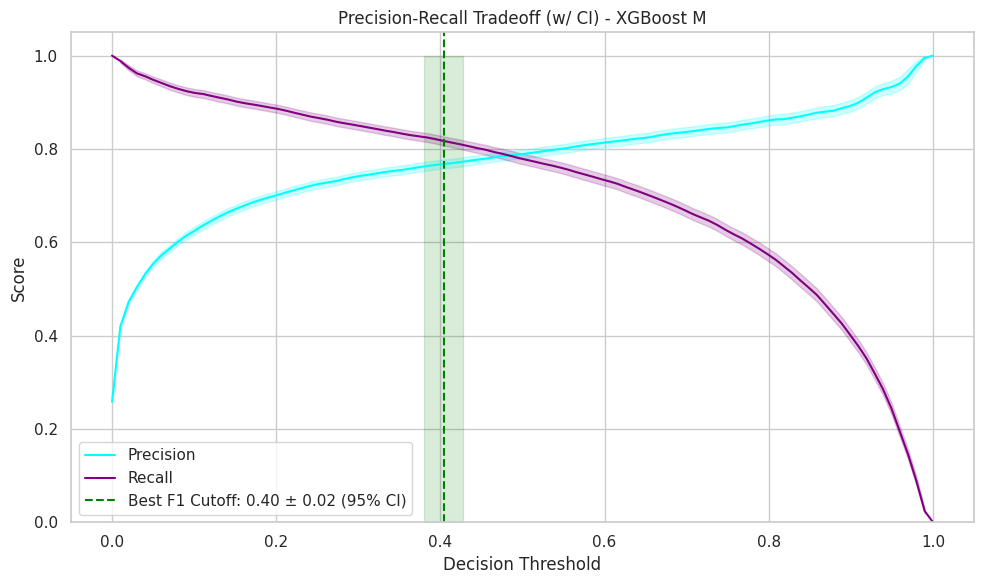

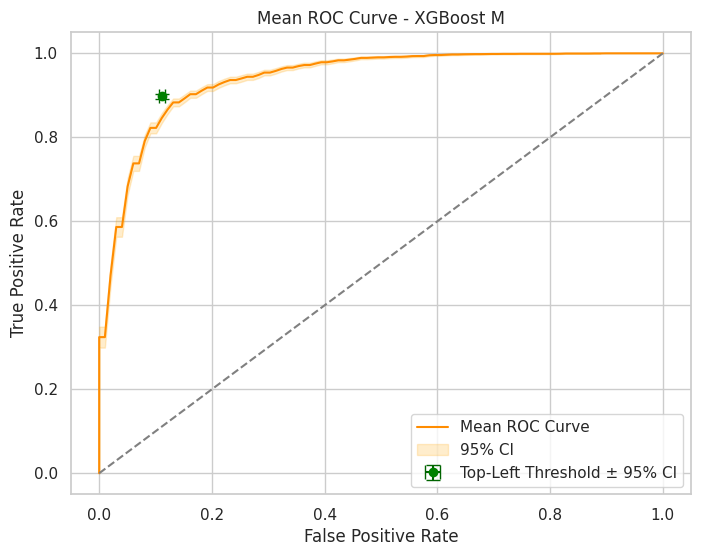


 Mean Top-Left Threshold (ROC): 0.27 ± 0.02 (95% CI)


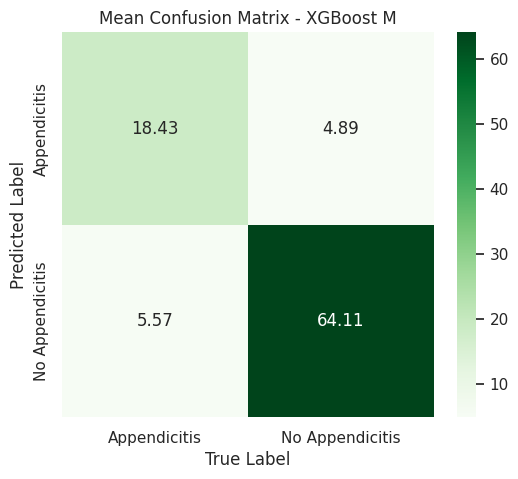

In [109]:
xgb_model = XGBClassifier(eval_metric="aucpr", random_state=2025)
best_hyperparams_counter = defaultdict(int)  # Tracks best hyperparameters
xgb_param_grid = {
    "n_estimators": [100],
    "max_depth": [3],
    "learning_rate": [0.1],
}
xgb_resultsM, best_xgbM = monte_carlo_cv_with_plot(
    xgb_model, xgb_param_grid, X_severity, y2,
    model_name="XGBoost M",
    num_iterations=200
)

monte_carlo_results["XGBoost M"].to_csv(f"{save_path_c_m}/XGBoost_mccv_results.csv", index=False)
xgb_resultsM.to_csv(f"{save_path_c_m}/XGBoost_summary.csv")

XGBoost - Severity Prediction

> **Note on Hyperparameter Tuning:**  
> `n_estimators=100`, `max_depth=3`, and `learning_rate=0.1` were selected consistently across all 20 Monte Carlo iterations so for the run through of 200 iterations these hyperparamters were chosen.

- **Features Used:** All clinical and ultrasound-derived features.

- **Best Hyperparameters:**  
  - `n_estimators = 100`
  - `max_depth = 3`
  - `learning_rate = 0.1`

- **Precision-Recall and ROC Analysis:**
  - The shaded region represents the 95% confidence interval around the optimal F1 threshold (≈ 0.40), which lies close to the intersection of the mean precision and mean recall curves—indicating a well-balanced decision point that is stable across resampling.
  - Strong separability observed on the ROC curve.


- **Performance (Optimal Threshold ≈ 0.40 ± 0.02):**
  - **Accuracy:** 0.888 ± 0.028
  - **AUC:** 0.940 ± 0.025
  - **Precision:** 0.795 ± 0.070
  - **Recall:** 0.768 ± 0.082
  - **F1 Score:** 0.778 ± 0.058




## 3.7 Neural Network

A reusable PyTorch function for binary classification was developed in Coursework 1 and was adapted for this project to evaluate a Multi-Layer Perceptron (MLP). Given the higher computational cost of training neural networks, standard nested cross-validation was used instead of Monte Carlo cross-validation to more efficiently make use of the available data while supporting hyperparameter tuning and model assessment.


In [59]:
# ---- Define MLP Model Class ---- #
class MLP(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, dropout=0.2):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.net(x)

# ---- Training & Evaluation Function with Threshold Search ---- #
def train_evaluate_model(X_train, y_train, X_val, y_val, params, return_preds=False):
    model = MLP(input_dim=X_train.shape[1], **params)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)

    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

    best_model = None
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(500):
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        epoch_train_loss /= len(train_loader)

        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            val_loss = criterion(y_val_pred, y_val_tensor).item()

        train_losses.append(epoch_train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = deepcopy(model)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model = best_model
    model.eval()
    with torch.no_grad():
        y_val_logits = model(X_val_tensor).numpy().flatten()
        y_val_probs = 1 / (1 + np.exp(-y_val_logits))

    # Threshold selection based on F1
    thresholds = np.linspace(0.01, 0.99, 99)
    f1s = [f1_score(y_val, y_val_probs >= t) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1s)]

    y_val_preds = (y_val_probs >= best_threshold).astype(int)
    auc = roc_auc_score(y_val, y_val_probs)

    if return_preds:
        return y_val, y_val_preds, y_val_probs, best_threshold

    return {
        'F1': f1_score(y_val, y_val_preds),
        'Precision': precision_score(y_val, y_val_preds),
        'Recall': recall_score(y_val, y_val_preds),
        'Accuracy': accuracy_score(y_val, y_val_preds),
        'AUC': auc,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_threshold': best_threshold,
        'roc_curve': roc_curve(y_val, y_val_probs)
    }

# ---- Nested CV ---- #
def run_nested_cv_classifier(X_raw, y_raw, param_grid):
    outer_kf = KFold(n_splits=10, shuffle=True, random_state=42)
    inner_kf = KFold(n_splits=5, shuffle=True, random_state=1)

    X_raw = X_raw.reset_index(drop=True)
    y_raw = y_raw.reset_index(drop=True).values

    results = []
    fpr_all, tpr_all = [], []
    thresholds_all = []
    train_loss_curves, val_loss_curves = [], []

    for fold, (train_idx, test_idx) in enumerate(outer_kf.split(X_raw)):
        print(f"\n🔁 Outer Fold {fold+1}")
        X_outer_train_raw, X_outer_test_raw = X_raw.iloc[train_idx], X_raw.iloc[test_idx]
        y_outer_train_raw, y_outer_test_raw = y_raw[train_idx], y_raw[test_idx]

        categorical_cols = X_outer_train_raw.select_dtypes(include='object').columns.tolist()
        numerical_cols = X_outer_train_raw.select_dtypes(include=[np.number]).columns.tolist()

        preprocessor = ColumnTransformer(transformers=[
            ('num', Pipeline([
                ('imputer', KNNImputer(n_neighbors=5)),
                ('scaler', StandardScaler())
            ]), numerical_cols),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
        ])

        X_outer_train = preprocessor.fit_transform(X_outer_train_raw)
        X_outer_test = preprocessor.transform(X_outer_test_raw)

        best_score = -np.inf
        best_params = None

        for params in param_grid:
            inner_scores = []
            for inner_train_idx, val_idx in inner_kf.split(X_outer_train):
                X_train_inner, X_val_inner = X_outer_train[inner_train_idx], X_outer_train[val_idx]
                y_train_inner, y_val_inner = y_outer_train_raw[inner_train_idx], y_outer_train_raw[val_idx]
                score = train_evaluate_model(X_train_inner, y_train_inner, X_val_inner, y_val_inner, params)
                inner_scores.append(score['F1'])

            avg_score = np.mean(inner_scores)
            if avg_score > best_score:
                best_score = avg_score
                best_params = params

        print(f"✅ Best Params: {best_params}")

        outer_result = train_evaluate_model(X_outer_train, y_outer_train_raw, X_outer_test, y_outer_test_raw, best_params)
        y_true, y_pred, y_prob, best_thresh = train_evaluate_model(X_outer_train, y_outer_train_raw, X_outer_test, y_outer_test_raw, best_params, return_preds=True)
        fpr, tpr, _ = roc_curve(y_true, y_prob)

        fpr_all.append(fpr)
        tpr_all.append(tpr)
        thresholds_all.append(best_thresh)
        train_loss_curves.append(outer_result['train_losses'])
        val_loss_curves.append(outer_result['val_losses'])

        results.append({k: outer_result[k] for k in ['F1', 'Precision', 'Recall', 'Accuracy', 'AUC']})
        print(f"📊 Outer Fold F1: {outer_result['F1']:.4f}, AUC: {outer_result['AUC']:.4f}")

    return results, fpr_all, tpr_all, thresholds_all, train_loss_curves, val_loss_curves

# ---- Function: Plot Mean ROC Curve ---- #
def plot_mean_roc(fpr_all, tpr_all):
    from sklearn.utils import resample
    tpr_interp = []
    fpr_mean = np.linspace(0, 1, 100)

    for fpr, tpr in zip(fpr_all, tpr_all):
        tpr_interp.append(np.interp(fpr_mean, fpr, tpr))

    tpr_interp = np.array(tpr_interp)
    tpr_mean = tpr_interp.mean(axis=0)
    tpr_std = tpr_interp.std(axis=0)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr_mean, tpr_mean, label='Mean ROC', color='cyan')
    plt.fill_between(fpr_mean, tpr_mean - tpr_std, tpr_mean + tpr_std, alpha=0.2, color='cyan')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Average ROC Curve with Confidence Interval")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


**Diagnosis**


🔁 Outer Fold 1
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold F1: 0.9388, AUC: 0.9657

🔁 Outer Fold 2
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2}
📊 Outer Fold F1: 0.8913, AUC: 0.9425

🔁 Outer Fold 3
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.1}
📊 Outer Fold F1: 0.9070, AUC: 0.9495

🔁 Outer Fold 4
✅ Best Params: {'hidden1': 32, 'hidden2': 16, 'dropout': 0.1}
📊 Outer Fold F1: 0.9278, AUC: 0.9545

🔁 Outer Fold 5
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2}
📊 Outer Fold F1: 0.9438, AUC: 0.9835

🔁 Outer Fold 6
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2}
📊 Outer Fold F1: 0.9070, AUC: 0.9579

🔁 Outer Fold 7
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.1}
📊 Outer Fold F1: 0.9600, AUC: 0.9864

🔁 Outer Fold 8
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.1}
📊 Outer Fold F1: 0.9375, AUC: 0.9485

🔁 Outer Fold 9
✅ Best Params: {'hidden1': 32, 'hidden2': 16, 'dropout': 0.1}
📊

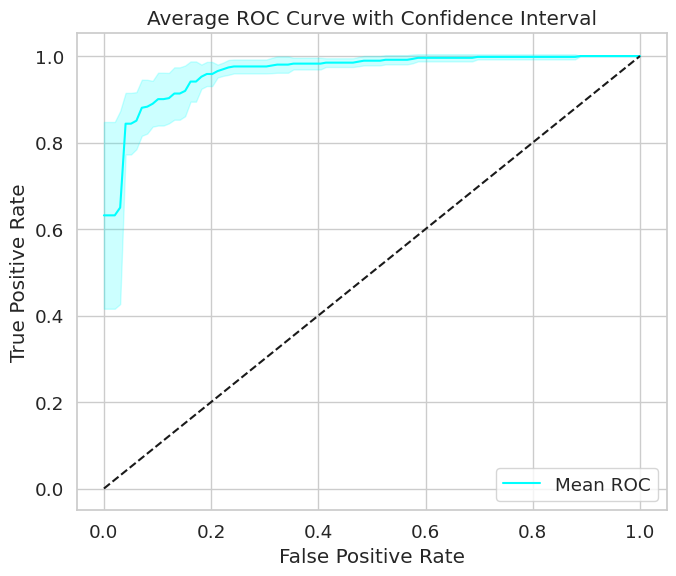

In [61]:
# Define parameter grid
param_grid = [
    {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2},
    {'hidden1': 32, 'hidden2': 16, 'dropout': 0.1},
    {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3},
    {'hidden1': 64, 'hidden2': 32, 'dropout': 0.1}]

# Run Nested CV
results_class, fpr_all, tpr_all, thresholds_all, train_loss_curves, val_loss_curves = run_nested_cv_classifier(X, y, param_grid)

# Summarise Metrics
f1s = [r['F1'] for r in results_class]
precs = [r['Precision'] for r in results_class]
recalls = [r['Recall'] for r in results_class]
accs = [r['Accuracy'] for r in results_class]
aucs = [r['AUC'] for r in results_class]

print("\n📊 Final MLP Classification Results:")
print(f"F1:       {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
print(f"Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}")
print(f"Recall:    {np.mean(recalls):.3f} ± {np.std(recalls):.3f}")
print(f"Accuracy:  {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"AUC:       {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")

# Plot ROC
plot_mean_roc(fpr_all, tpr_all)


MLP (Multilayer Perceptron) - Appendicitis Diagnosis

- **Clinical Motivation:**
  - Neural networks, particularly MLPs, are capable of modelling complex non-linear relationships between features. Given the heterogeneous nature of clinical, laboratory, and imaging variables in appendicitis, an MLP offers the potential to capture subtle predictive patterns that simpler models might miss.

- **Features Used:**
  - All available clinical features were used as inputs. The model's structure, including dropout layers, mitigated overfitting despite the large feature set.

- **Performance Overview (Nested Cross-Validation):**
  - **Mean F1 Score:** 0.931 ± 0.021
  - **Mean AUC:** 0.962 ± 0.014
  - **Mean Accuracy:** 0.918 ± 0.022
  - **Mean Precision:** 0.923 ± 0.049
  - **Mean Recall:** 0.942 ± 0.036

- **ROC Curve and Generalisation:**
  - The mean ROC curve displayed excellent discriminative ability with a tight confidence band.
  - Very high true positive rates were achieved even at low false positive rates, crucial for clinical decision support.

- **Advantages of the MLP:**
  - Able to model complex feature interactions beyond linear or tree-based splits.
  - Regularisation via dropout and early stopping prevented overfitting in a high-dimensional space.
  - Strong balance between sensitivity (recall) and precision, supporting both safe triage and avoidance of unnecessary surgeries.

- **Challenges and Limitations:**
  - Lower interpretability compared to linear models or decision trees.
  - Requires careful hyperparameter tuning and computationally more intensive training.
  - More prone to overfitting if not properly regularised or if too many layers are added.

> **Note:**  
> Final results were derived from a **nested cross-validation** setup, optimising hyperparameters within inner folds and reporting unbiased performance estimates from outer test folds.


**Severity**


🔁 Outer Fold 1
✅ Best Params: {'hidden1': 32, 'hidden2': 16, 'dropout': 0.1}
📊 Outer Fold F1: 0.9000, AUC: 0.9676

🔁 Outer Fold 2
✅ Best Params: {'hidden1': 32, 'hidden2': 16, 'dropout': 0.1}
📊 Outer Fold F1: 0.6667, AUC: 0.9429

🔁 Outer Fold 3
✅ Best Params: {'hidden1': 32, 'hidden2': 16, 'dropout': 0.1}
📊 Outer Fold F1: 0.9091, AUC: 0.9545

🔁 Outer Fold 4
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2}
📊 Outer Fold F1: 0.7742, AUC: 0.8516

🔁 Outer Fold 5
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold F1: 0.6364, AUC: 0.8709

🔁 Outer Fold 6
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold F1: 0.8205, AUC: 0.9062

🔁 Outer Fold 7
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2}
📊 Outer Fold F1: 0.9032, AUC: 0.9634

🔁 Outer Fold 8
✅ Best Params: {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
📊 Outer Fold F1: 0.8333, AUC: 0.9510

🔁 Outer Fold 9
✅ Best Params: {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2}

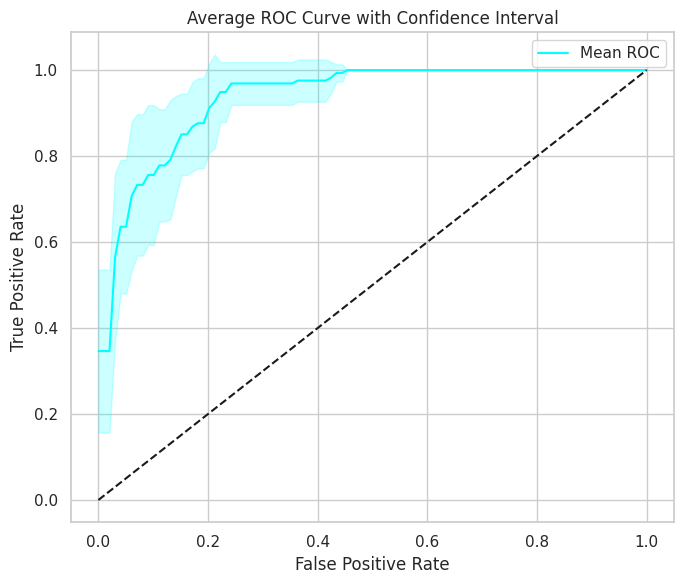

In [110]:
param_grid = [
    {'hidden1': 32, 'hidden2': 16, 'dropout': 0.1},
    {'hidden1': 64, 'hidden2': 32, 'dropout': 0.2},
    {'hidden1': 128, 'hidden2': 64, 'dropout': 0.3}
]

resultsM, fpr_allM, tpr_allM, thresholds_allM, train_loss_curvesM, val_loss_curvesM = run_nested_cv_classifier(X_severity, y2, param_grid)

# Summarise Metrics
f1s = [r['F1'] for r in resultsM]
precs = [r['Precision'] for r in resultsM]
recalls = [r['Recall'] for r in resultsM]
accs = [r['Accuracy'] for r in resultsM]
aucs = [r['AUC'] for r in resultsM]

print("\n📊 Final MLP Classification Results:")
print(f"F1:       {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
print(f"Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}")
print(f"Recall:    {np.mean(recalls):.3f} ± {np.std(recalls):.3f}")
print(f"Accuracy:  {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"AUC:       {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")


plot_mean_roc(fpr_allM, tpr_allM)


**Neural Network - Severity Prediction**

- **Features Used:** All clinical and ultrasound-derived features.

- **Architecture:**  
  - Two hidden layers with hyperparameter tuning:
    - Hidden layer sizes ranged from 32 to 128 units.
    - Dropout rates between 0.1 and 0.3.

- **Best Hyperparameters:**  
  - The most frequently selected architecture across folds was **64–32** and **128–64** with **dropout = 0.2–0.3**, indicating a preference for deeper networks with moderate regularisation.

- **Performance (Nested Cross-Validation):**
  - **Mean Accuracy:** 0.902 ± 0.047  
  - **Mean AUC:** 0.930 ± 0.039  
  - **Mean Precision:** 0.796 ± 0.117  
  - **Mean Recall:** 0.835 ± 0.105  
  - **Mean F1 Score:** 0.809 ± 0.091  

- **Interpretation:**  
  - Performance varied across folds, with some instability in F1 score (e.g., fold 2 = 0.667 vs. fold 3 = 0.909). This reflects potential variability in severity label quality or data distribution, highlighting the value of nested CV.
  - Higher dropout (0.3) combined with larger hidden layers tended to perform well in later folds, suggesting regularisation was important in reducing overfitting for this task.

- **ROC Curve:**  
  - The MLP achieved a consistently strong ROC curve, with the mean line showing high true positive rates and a narrow confidence interval, indicating stable classification performance across folds.
---

# **4. RESULTS**

Load in the results

In [111]:
def load_mccv_results(folder_path, keyword="mccv"):
    mccv_files = [f for f in os.listdir(folder_path) if keyword in f and f.endswith(".csv")]
    results_list = []

    for fname in mccv_files:
        model_name = re.split(r"_mc|_s", fname)[0]
        df = pd.read_csv(os.path.join(folder_path, fname))
        df["model"] = model_name
        results_list.append(df)

    combined_df = pd.concat(results_list, ignore_index=True)
    return combined_df


In [112]:
# Load MCCV results for Diagnosis and Severity tasks
Diagnosis_results_df = load_mccv_results(save_path_c_f)   # 'Diagnosis'
Severity_results_df = load_mccv_results(save_path_c_m)    # 'Severity'

# Display results
print("Diagnosis Results")
display(Diagnosis_results_df)

print("Severity Results")
display(Severity_results_df)


Diagnosis Results


Iteration  Accuracy       AUC  Precision    Recall  F1-Score  \
0            1  0.897436  0.958525   0.913978  0.913978  0.913978   
1            2  0.923077  0.972862   0.917526  0.956989  0.936842   
2            3  0.865385  0.929510   0.860000  0.924731  0.891192   
3            4  0.878205  0.963475   0.902174  0.892473  0.897297   
4            5  0.903846  0.954258   0.943182  0.892473  0.917127   
..         ...       ...       ...        ...       ...       ...   
795        196  0.961538  0.992320   0.967742  0.967742  0.967742   
796        197  0.967949  0.993344   0.968085  0.978495  0.973262   
797        198  0.948718  0.993173   0.967033  0.946237  0.956522   
798        199  0.967949  0.989418   0.978261  0.967742  0.972973   
799        200  0.948718  0.982420   0.947368  0.967742  0.957447   

                   model  
0    logistic_regression  
1    logistic_regression  
2    logistic_regression  
3    logistic_regression  
4    logistic_regression  
..                   ...  
795              XGBoost  
796              XGBoost  
797              XGBoost  
798              XGBoost  
799              XGBoost  

[800 rows x 7 columns]

Severity Results


Iteration  Accuracy       AUC  Precision    Recall  F1-Score  \
0            1  0.881720  0.948671   0.760000  0.791667  0.775510   
1            2  0.870968  0.942029   0.714286  0.833333  0.769231   
2            3  0.881720  0.939614   0.760000  0.791667  0.775510   
3            4  0.870968  0.911836   0.833333  0.625000  0.714286   
4            5  0.881720  0.911232   0.933333  0.583333  0.717949   
..         ...       ...       ...        ...       ...       ...   
795        196  0.860215  0.890097   0.720000  0.750000  0.734694   
796        197  0.903226  0.948068   0.857143  0.750000  0.800000   
797        198  0.827957  0.937198   0.722222  0.541667  0.619048   
798        199  0.860215  0.926932   0.720000  0.750000  0.734694   
799        200  0.870968  0.898551   0.772727  0.708333  0.739130   

                   model  
0    logistic_regression  
1    logistic_regression  
2    logistic_regression  
3    logistic_regression  
4    logistic_regression  
..                   ...  
795              XGBoost  
796              XGBoost  
797              XGBoost  
798              XGBoost  
799              XGBoost  

[800 rows x 7 columns]

In [113]:
# For classification results - Summary
Diagnosis_results_summary = load_mccv_results(save_path_c_f, "summary").iloc[:, 1:]
Severity_results_summary = load_mccv_results(save_path_c_m, "summary").iloc[:, 1:]

# Round for easier reading
Diagnosis_results_summary = Diagnosis_results_summary.round(3)
Severity_results_summary = Severity_results_summary.round(3)



ADD Neural Networks to summary Table

In [114]:
# MLP results (Diagnosis Task)
mlp_summary_diag = pd.DataFrame({
    "Mean Accuracy": [np.mean([r['Accuracy'] for r in results_class])],
    "Std Accuracy": [np.std([r['Accuracy'] for r in results_class])],
    "Mean AUC": [np.mean([r['AUC'] for r in results_class])],
    "Std AUC": [np.std([r['AUC'] for r in results_class])],
    "Mean Precision": [np.mean([r['Precision'] for r in results_class])],
    "Std Precision": [np.std([r['Precision'] for r in results_class])],
    "Mean Recall": [np.mean([r['Recall'] for r in results_class])],
    "Std Recall": [np.std([r['Recall'] for r in results_class])],
    "Mean F1": [np.mean([r['F1'] for r in results_class])],
    "Std F1": [np.std([r['F1'] for r in results_class])],
})
mlp_summary_diag["model"] = "Neural Network"
# Add MLP to Diagnosis table
Diagnosis_results_summary["model"] = Diagnosis_results_summary["model"].astype(str)
Diagnosis_results_summary = pd.concat([Diagnosis_results_summary, mlp_summary_diag], ignore_index=True)


# Neural Network (Severity Task)
mlp_summary_severity = pd.DataFrame({
    "Mean Accuracy": [np.mean([r['Accuracy'] for r in resultsM])],
    "Std Accuracy": [np.std([r['Accuracy'] for r in resultsM])],
    "Mean AUC": [np.mean([r['AUC'] for r in resultsM])],
    "Std AUC": [np.std([r['AUC'] for r in resultsM])],
    "Mean Precision": [np.mean([r['Precision'] for r in resultsM])],
    "Std Precision": [np.std([r['Precision'] for r in resultsM])],
    "Mean Recall": [np.mean([r['Recall'] for r in resultsM])],
    "Std Recall": [np.std([r['Recall'] for r in resultsM])],
    "Mean F1": [np.mean([r['F1'] for r in resultsM])],
    "Std F1": [np.std([r['F1'] for r in resultsM])],
})

mlp_summary_severity["model"] = "Neural Network"

# Add MLP to Severity table
Severity_results_summary["model"] = Severity_results_summary["model"].astype(str)  # Ensure string type
Severity_results_summary = pd.concat([Severity_results_summary, mlp_summary_severity], ignore_index=True)


### 4.1 Model Comparison - Tables

In [115]:
# Display Diagnosis summary nicely
print("Diagnosis Results Summary")
display(Diagnosis_results_summary.style
    .set_caption("Diagnosis Model Performance Summary")
    .format(precision=3)
    .background_gradient(cmap="Blues")
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]}
    ])
)

# Display Severity summary nicely
print("Severity Results Summary")
display(Severity_results_summary.style
    .set_caption("Severity Model Performance Summary")
    .format(precision=3)
    .background_gradient(cmap="Purples")
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]}
    ])
)


Diagnosis Results Summary


Severity Results Summary


**Diagnosis Results Summary**

XGBoost delivered the strongest overall performance across all metrics, achieving the highest mean accuracy (0.952), AUC (0.988), and F1 score (0.960), with low variability across folds, making it a reliable and high-performing choice for appendicitis diagnosis.

Random Forest also performed very well, slightly below XGBoost, with a strong balance between precision (0.947) and recall (0.951), and high AUC (0.981), indicating excellent discriminatory power.

Neural Network achieved strong recall (0.942) and a competitive F1 score (0.931), suggesting it is effective at capturing complex patterns. However, it showed slightly higher variability in precision and may require more computational resources and tuning.

Elastic Net and Logistic Regression performed well for interpretable models, with F1 scores around 0.91. While less accurate than tree-based and neural models, they offer transparency.

**Severity Results Summary**

Neural Network achieved the highest mean accuracy (0.902) and F1 score (0.809), indicating strong overall performance in severity classification. It also had the best recall (0.835), which is critical for detecting complicated cases, though its precision showed more variability, suggesting sensitivity to threshold or sample distribution.

XGBoost offered a strong balance between precision (0.795) and recall (0.768), with a competitive F1 score (0.778) and the highest AUC (0.940), suggesting it is highly capable at distinguishing between severity classes with consistent performance across folds.

Random Forest produced high precision (0.866), indicating strong confidence in predicted complicated cases, but this came at the cost of lower recall (0.669), which may lead to more missed cases of severe appendicitis.

Elastic Net and Logistic Regression had nearly identical performance, with moderate F1 scores (0.75) and lower recall than other models. However, they remain strong options for their simplicity and transparency, particularly in clinical environments where model explainability is a priority.

## 4.2 Performance Metrics

In [120]:
def plot_monte_carlo_boxplots(monte_carlo_df, model_name="Model"):
    """
    Plots box plots for Accuracy, AUC, Precision, Recall, and F1-Score from Monte Carlo results.

    Args:
        monte_carlo_df (pd.DataFrame): DataFrame of Monte Carlo results for a given model.
        model_name (str): Name of the model (used in the title).
    """
    if not isinstance(monte_carlo_df, pd.DataFrame):
        print("Input must be a pandas DataFrame.")
        return

    if not {"Accuracy", "AUC", "Precision", "Recall", "F1-Score"}.issubset(monte_carlo_df.columns):
        print("DataFrame must include: Accuracy, AUC, Precision, Recall, and F1-Score columns.")
        return

    melted = monte_carlo_df.melt(
        id_vars="Iteration",
        value_vars=["Accuracy", "AUC", "Precision", "Recall", "F1-Score"],
        var_name="Metric",
        value_name="Score"
    )

    # Plot
    plt.figure(figsize=(8, 6))
    sns.boxplot(x="Metric", y="Score", data=melted, palette="bright", width=0.5, showmeans=True,
                meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"})

    plt.title(f"Monte Carlo Performance Distribution - {model_name}", fontsize=15, fontweight='bold')
    plt.xlabel("Performance Metric", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    #plt.ylim(.6, 1.05)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()


XGBoost - Diagnosis


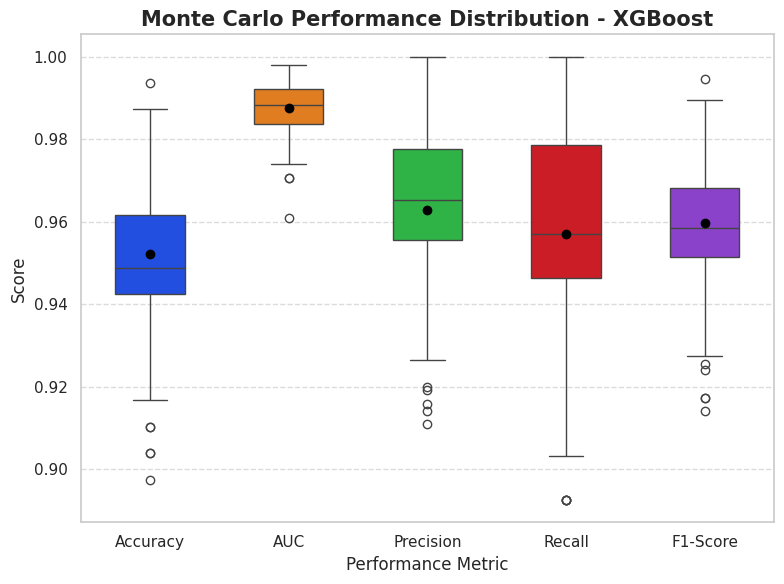

---------------------------------------------------------------------------------------------------------
XGBoost - Severity


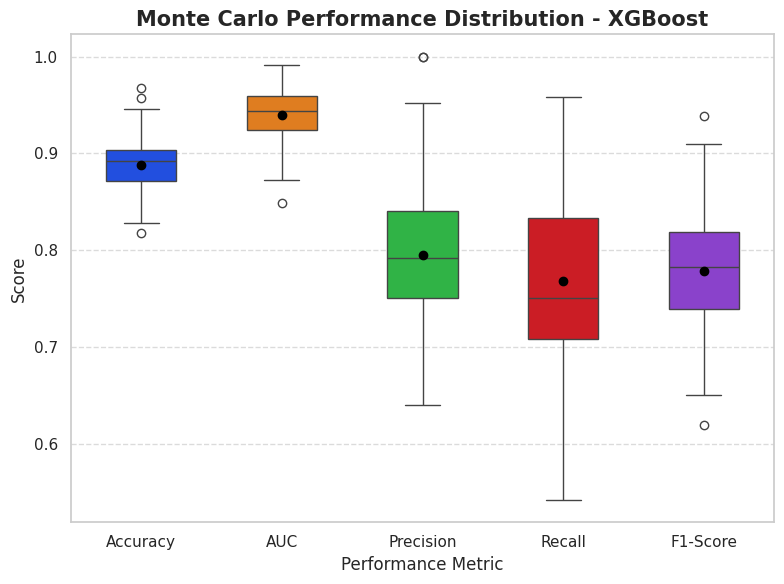

In [121]:
print("XGBoost - Diagnosis")
plot_monte_carlo_boxplots(
    monte_carlo_df=Diagnosis_results_df[Diagnosis_results_df["model"] == "XGBoost"],
    model_name="XGBoost"
)

print("---------------------------------------------------------------------------------------------------------")


print("XGBoost - Severity")
plot_monte_carlo_boxplots(
    monte_carlo_df=Severity_results_df[Severity_results_df["model"] == "XGBoost"],
    model_name="XGBoost"
)


In [122]:
def plot_metric_boxplot_comparison(monte_carlo_results_dict, metric_name="F1-Score"):
    """
    Plots a boxplot comparing a specified metric across multiple classification models.

    Args:
        monte_carlo_results_dict (dict): Dictionary of {model_name: DataFrame}
        metric_name (str): Column name of the metric to compare (e.g., 'F1-Score', 'Accuracy')
    """
    metric_data = []

    for model_name, df in monte_carlo_results_dict.items():
        if metric_name not in df.columns:
            print(f"⚠️ Skipping {model_name} (no '{metric_name}' column found).")
            continue

        for score in df[metric_name]:
            metric_data.append({"Model": model_name, "Score": score})

    if not metric_data:
        print(f"❌ No valid '{metric_name}' data found to plot.")
        return

    combined_df = pd.DataFrame(metric_data)

    plt.figure(figsize=(11, 7))

    sns.set_theme(style="whitegrid")  # Use whitegrid style globally
    sns.boxplot(
        x="Model",
        y="Score",
        data=combined_df,
        palette="bright",  # Brighter, softer pastel colors
        showmeans=True,
        meanprops={
            "marker": "D",  # Diamond shape for mean
            "markerfacecolor": "black",
            "markeredgecolor": "black",
            "markersize": 6
        }
    )

    # Titles and labels
    plt.title(f"{metric_name} Distribution by Model (Monte Carlo CV)", fontsize=16, fontweight="bold", pad=15)
    plt.xlabel("Model", fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.xticks(rotation=30, ha="right", fontsize=12)
    plt.yticks(fontsize=12)

    # Grid improvements
    plt.grid(True, linestyle="--", linewidth=0.6, alpha=0.7, axis="y")

    # Border and layout
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()



## 4.3 Model Comparison - Boxplots

**Diagnosis**

Diagnosis Results


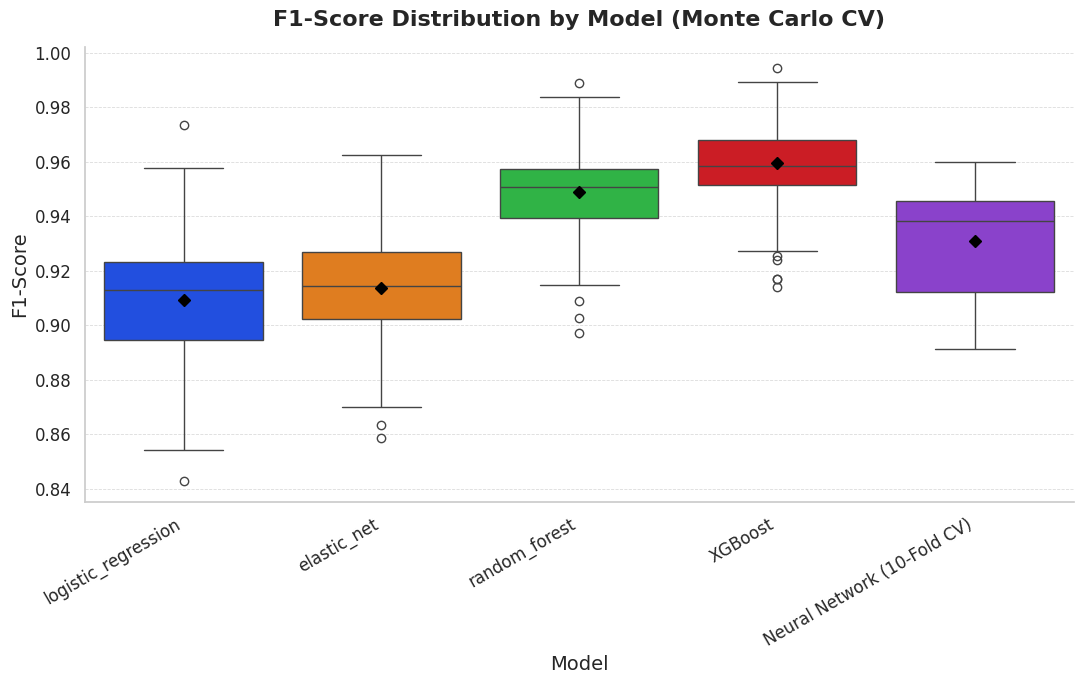

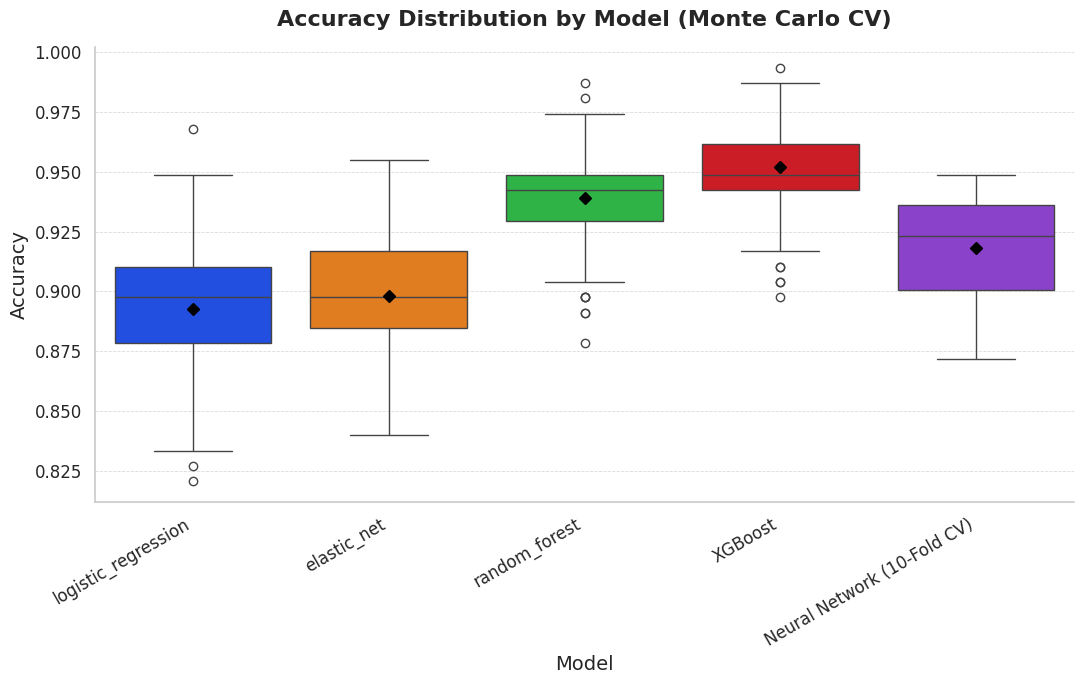

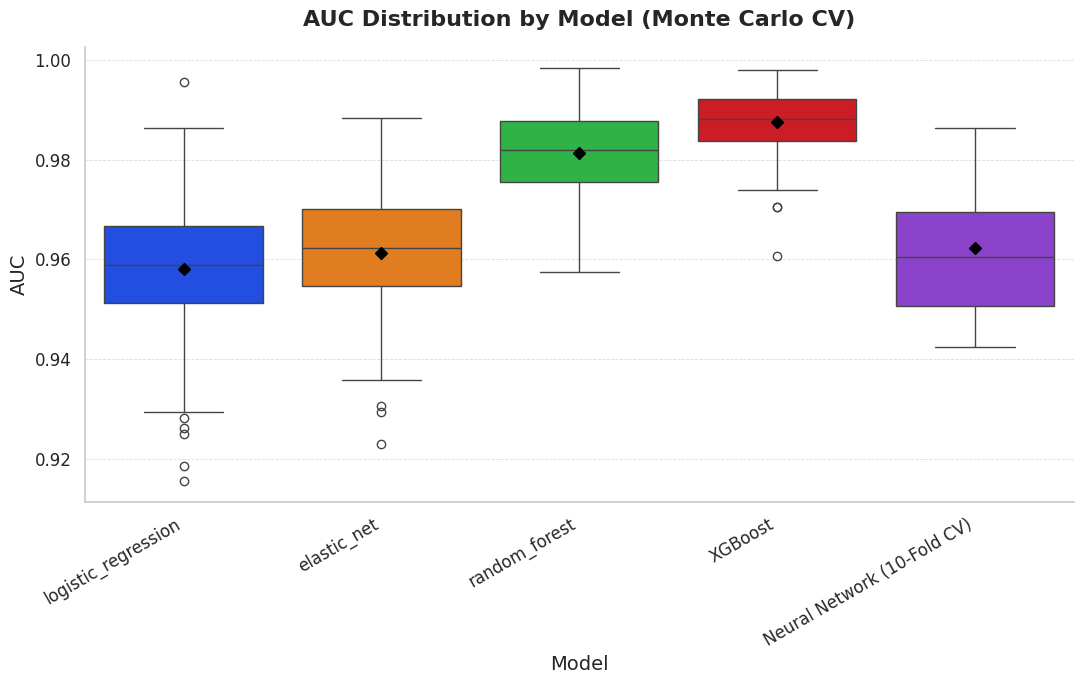

In [123]:
diagnosis_model_results = {
    model: Diagnosis_results_df[Diagnosis_results_df["model"] == model]
    for model in Diagnosis_results_df["model"].unique()
}

mlp_diag_df = pd.DataFrame({
    "Accuracy": [r["Accuracy"] for r in results_class],
    "AUC": [r["AUC"] for r in results_class],
    "Precision": [r["Precision"] for r in results_class],
    "Recall": [r["Recall"] for r in results_class],
    "F1-Score": [r["F1"] for r in results_class],
    "model": ["Neural Network (10-Fold CV)"] * len(results_class)  # same label
})

# Concatenate Neural Network results into the Diagnosis full results
Diagnosis_results_df = pd.concat([Diagnosis_results_df, mlp_diag_df], ignore_index=True)

diagnosis_model_results = {
    model: Diagnosis_results_df[Diagnosis_results_df["model"] == model]
    for model in Diagnosis_results_df["model"].unique()
}

print("Diagnosis Results")
plot_metric_boxplot_comparison(diagnosis_model_results, metric_name="F1-Score")
plot_metric_boxplot_comparison(diagnosis_model_results, metric_name="Accuracy")
plot_metric_boxplot_comparison(diagnosis_model_results, metric_name="AUC")




**Severity**

Severity Results


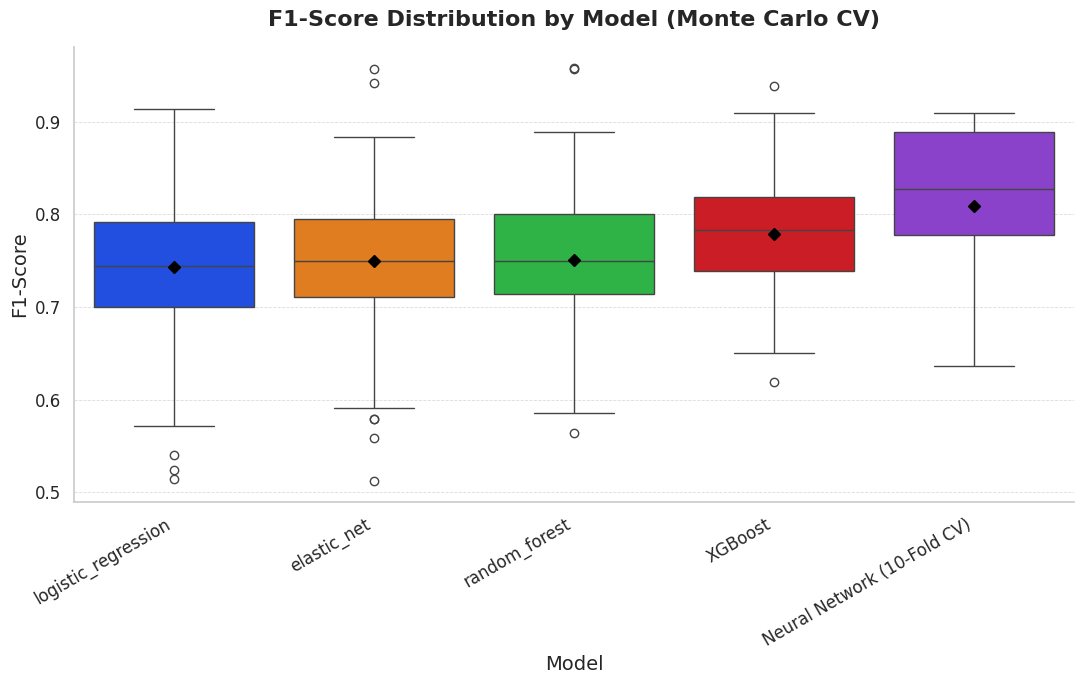

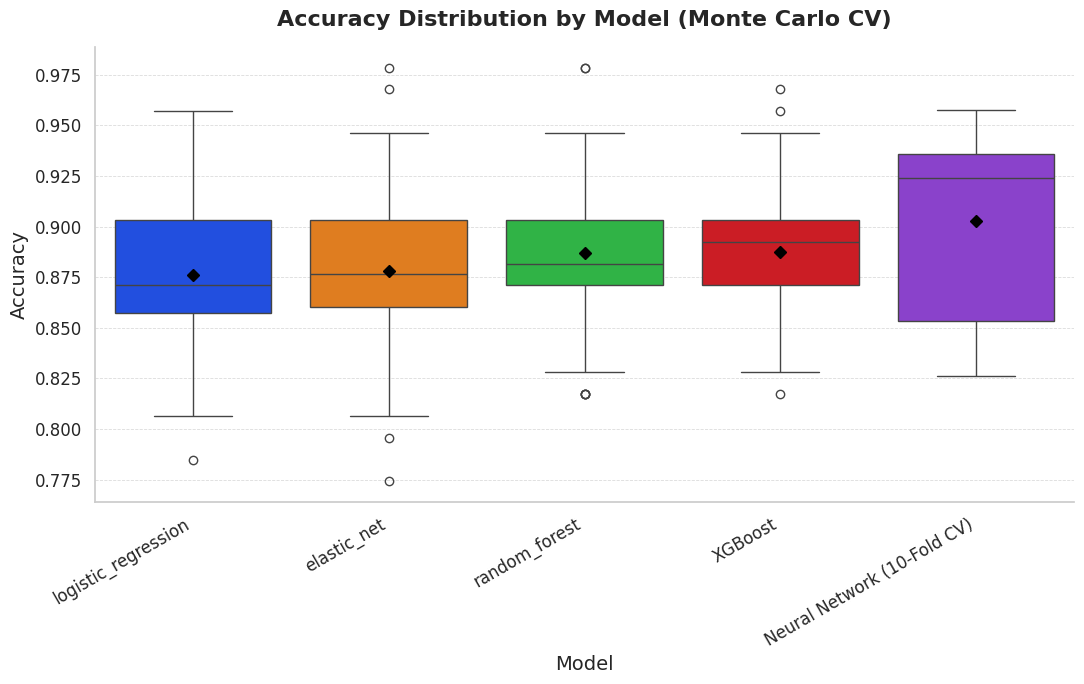

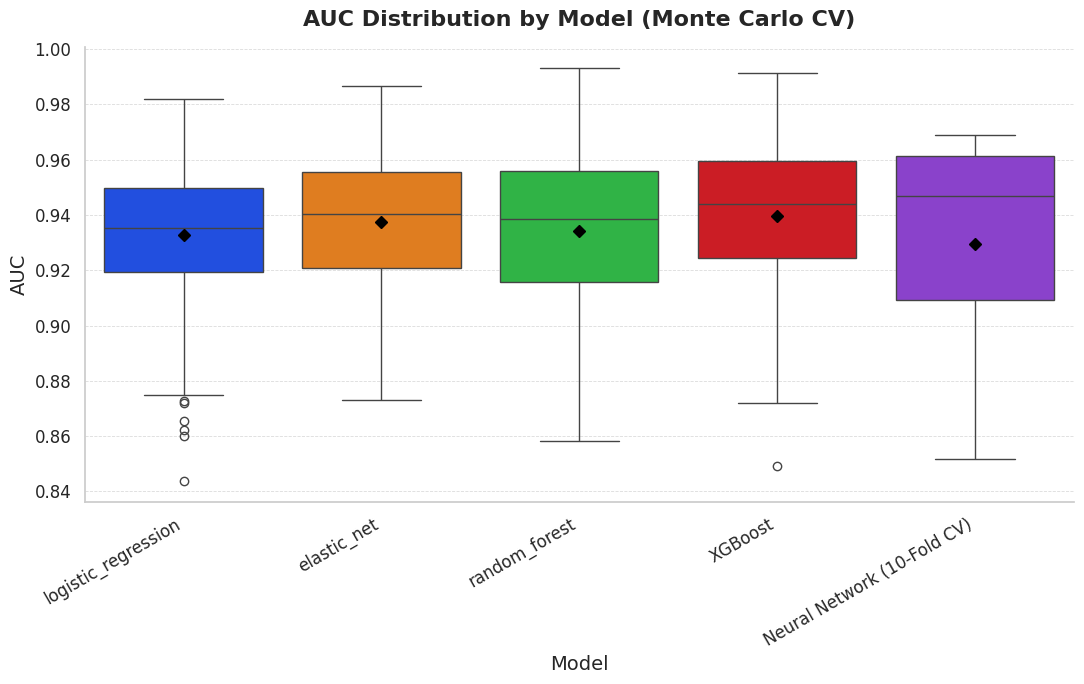

In [124]:
# Create a dictionary of Severity results grouped by model
severity_model_results = {
    model: Severity_results_df[Severity_results_df["model"] == model]
    for model in Severity_results_df["model"].unique()
}
mlp_severity_df = pd.DataFrame({
    "Accuracy": accs,
    "AUC": aucs,
    "Precision": precs,
    "Recall": recalls,
    "F1-Score": f1s,
    "model": ["Neural Network (10-Fold CV)"] * len(f1s)
})

Severity_results_df = pd.concat([Severity_results_df, mlp_severity_df], ignore_index=True)

severity_model_results = {
    model: Severity_results_df[Severity_results_df["model"] == model]
    for model in Severity_results_df["model"].unique()
}

# Plot metrics for Severity
print("Severity Results")
plot_metric_boxplot_comparison(severity_model_results, metric_name="F1-Score")
plot_metric_boxplot_comparison(severity_model_results, metric_name="Accuracy")
plot_metric_boxplot_comparison(severity_model_results, metric_name="AUC")


## 4.4 Model Selection

Model performance was compared across both tasks using F1-score distributions from Monte Carlo cross-validation. As shown in the box plots, XGBoost consistently achieved the highest median F1-score for diagnosis classification, with a narrow interquartile range and minimal outliers. This indicates strong and stable predictive performance, justifying its selection for deployment in the diagnostic setting.

For severity prediction, the Neural Network produced the highest mean F1-score, suggesting its ability to capture complex patterns within the data. However, its wider spread and several low outliers indicate greater variability across validation folds, reflecting sensitivity to training data and hyperparameter configuration. In contrast, XGBoost offered a more balanced trade-off, with slightly lower average performance but greater consistency and fewer extreme values.

Given the clinical importance of stable and reliable model behaviour, especially in real-world deployment scenarios, XGBoost was selected as the final model for both diagnosis and severity classification.

## 4.5 Feature Importance

In [125]:
def clean_feature_name(name):
    # Remove prefixes like 'cat__', 'num__', 'ohe__' if they exist
    for prefix in ["cat__", "num__", "ohe__"]:
        if name.startswith(prefix):
            name = name[len(prefix):]
    # Replace underscores with spaces and capitalize
    return name.replace("_", " ").title()


def summarize_feature_importance(model_name, top_n=25):
    if model_name not in feature_importance_dict:
        print(f"\u274c No feature importance data available for '{model_name}'.")
        return

    model = model_results[model_name]["model"]
    expected_n_features = len(model.feature_names_in_)

    valid_runs = []
    for run in feature_importance_dict[model_name]:
        arr = np.asarray(run)
        if arr.shape[0] == expected_n_features:
            valid_runs.append(arr)

    if len(valid_runs) == 0:
        print("\u274c No valid runs found with matching feature count.")
        return

    importances = np.vstack(valid_runs)
    feature_names = [clean_feature_name(f) for f in model.feature_names_in_]

    if hasattr(model, "coef_"):
        import_type = "Coefficient"
    else:
        import_type = "Feature Importance"

    means = importances.mean(axis=0)
    stds = importances.std(axis=0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        cis = st.t.interval(0.95, df=len(importances)-1, loc=means, scale=st.sem(importances, axis=0))

    importance_df = pd.DataFrame({
        "Feature": feature_names,
        f"Mean {import_type}": means,
        "Std Dev": stds,
        "95% CI Lower": cis[0],
        "95% CI Upper": cis[1]
    })

    importance_df = importance_df.reindex(importance_df[f"Mean {import_type}"].abs().sort_values(ascending=False).index)
    display(importance_df.head(top_n))
    return importance_df


def plot_feature_importance_barplot(importance_df, top_n=25, model_name="", importance_col="Mean Coefficient", show_sign_legend=True, show_signed_axis=True):
    top_features = importance_df.copy()
    top_features["Abs Import"] = importance_df[importance_col].abs()
    top_features = top_features.sort_values("Abs Import", ascending=False).head(top_n).reset_index(drop=True)

    plt.figure(figsize=(10, max(6, 0.4 * top_n)))
    sns.set(style="whitegrid", font_scale=1.2)

    if show_signed_axis:
        top_features["Sign"] = top_features[importance_col].apply(lambda x: "Positive" if x >= 0 else "Negative")
        palette = {"Positive": "#0072B2", "Negative": "#D55E00"}

        plot_order = top_features.sort_values("Abs Import", ascending=True)["Feature"]

        barplot = sns.barplot(
            data=top_features,
            x=importance_col,
            y="Feature",
            hue="Sign",
            dodge=False,
            palette=palette,
            orient="h",
            order=plot_order
        )

        for feature_name in plot_order:
            row = top_features[top_features["Feature"] == feature_name].iloc[0]
            y_pos = list(plot_order).index(feature_name)

            plt.errorbar(
                x=row[importance_col],
                y=y_pos,
                xerr=[[row[importance_col] - row["95% CI Lower"]],
                      [row["95% CI Upper"] - row[importance_col]]],
                fmt="none",
                ecolor="black",
                elinewidth=1,
                capsize=3,
                capthick=1
            )

        if show_sign_legend:
            plt.legend(title="Effect Direction", loc="best", frameon=True)
        plt.axvline(0, color='black', linestyle='--', linewidth=1)

    else:
        norm = Normalize(vmin=top_features["Abs Import"].min(), vmax=top_features["Abs Import"].max())
        cmap = plt.cm.viridis
        colors = [cmap(norm(val)) for val in top_features["Abs Import"]]

        for i, (feature, val) in enumerate(zip(top_features["Feature"], top_features[importance_col])):
            plt.barh(
                y=i,
                width=val,
                color=colors[i],
                edgecolor="black",
                height=0.7
            )
            plt.text(
                x=val + 0.001,
                y=i,
                s=f"{val:.3f}",
                va="center",
                fontsize=10,
                color="black"
            )

        plt.yticks(ticks=range(len(top_features)), labels=top_features["Feature"])

    plt.title(f"Top {top_n} Feature Importance\n({model_name})", fontsize=16, weight="bold", pad=20)
    plt.xlabel(importance_col.replace("Mean ", ""), fontsize=13)
    plt.ylabel("Feature", fontsize=13)
    plt.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    plt.show()


def plot_model_importance(model_name, top_n=25):
    if model_name not in feature_importance_dict:
        print(f"\u274c No feature importance data available for '{model_name}'.")
        return

    model = model_results[model_name]["model"]
    importance_df = summarize_feature_importance(model_name, top_n=top_n)
    if importance_df is None:
        return

    if hasattr(model, "coef_"):
        importance_col = "Mean Coefficient"
        show_sign_legend = True
        show_signed_axis = True
    else:
        importance_col = "Mean Feature Importance"
        show_sign_legend = False
        show_signed_axis = False

    plot_feature_importance_barplot(
        importance_df=importance_df,
        top_n=top_n,
        model_name=model_name,
        importance_col=importance_col,
        show_sign_legend=show_sign_legend,
        show_signed_axis=show_signed_axis
    )


Feature  Mean Coefficient   Std Dev  \
57    Ipsilateral Rebound Tenderness Nan          2.829239  1.184560   
18                    Appendix On Us Nan          2.737374  2.367446   
7                      Appendix Diameter          2.289770  0.458381   
17                    Appendix On Us Yes          1.722986  2.176623   
4                         Length Of Stay          1.235220  0.230705   
27                            Nausea Yes          0.560359  0.642946   
51                     Peritonitis Local          0.500020  0.432329   
52                        Peritonitis No         -0.422641  0.387997   
9                              Wbc Count          0.378195  0.199701   
5                         Alvarado Score          0.341402  0.156394   
6          Paedriatic Appendicitis Score          0.327172  0.183160   
58                      Us Performed Yes         -0.287344  0.680265   
26                     Coughing Pain Nan          0.267465  0.477226   
24  Contralateral Rebound Tenderness Nan          0.248767  0.228370   
32                      Neutrophilia Nan         -0.212265  0.284294   
12                            Hemoglobin         -0.182398  0.121220   
14                     Thrombocyte Count         -0.175806  0.114554   
35                   Ketones In Urine No         -0.163680  0.240495   
40                      Rbc In Urine Nan          0.155305  0.191977   
0                                    Age          0.140169  0.134799   

    95% CI Lower  95% CI Upper  
57      2.573779      3.084699  
18      2.226815      3.247932  
7       2.190917      2.388624  
17      1.253580      2.192393  
4       1.185466      1.284973  
27      0.421703      0.699016  
51      0.406785      0.593255  
52     -0.506316     -0.338966  
9       0.335128      0.421262  
5       0.307675      0.375130  
6       0.287672      0.366672  
58     -0.434049     -0.140640  
26      0.164547      0.370382  
24      0.199517      0.298017  
32     -0.273575     -0.150955  
12     -0.208540     -0.156256  
14     -0.200511     -0.151102  
35     -0.215545     -0.111816  
40      0.113904      0.196706  
0       0.111099      0.169240

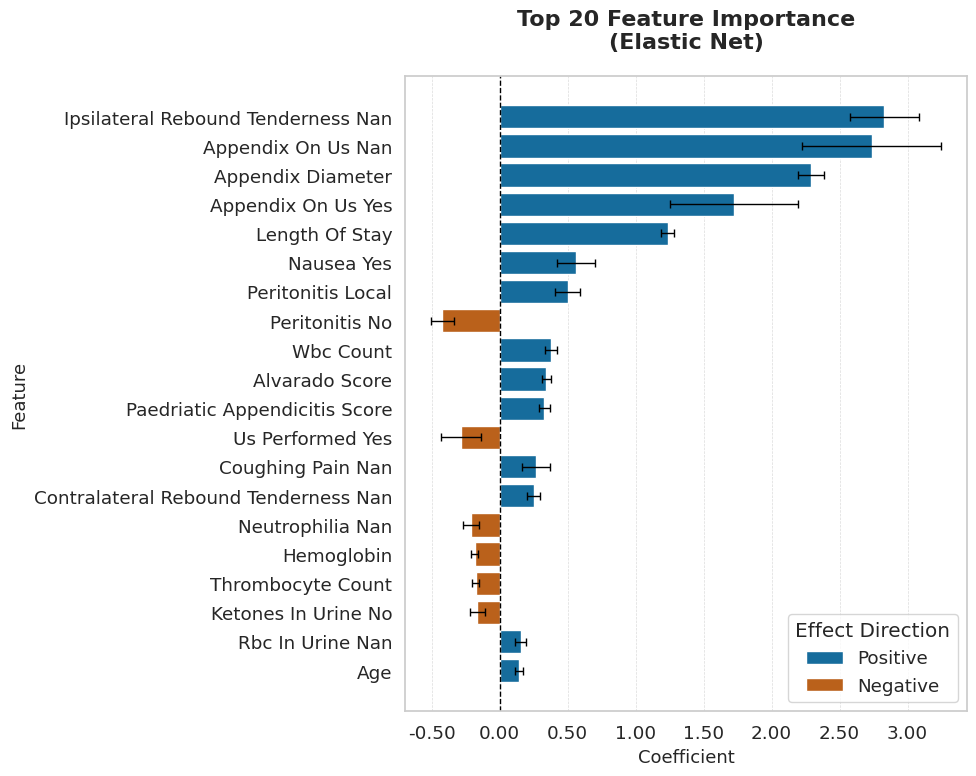

In [126]:
plot_model_importance("Elastic Net", top_n=20)


Feature  Mean Feature Importance   Std Dev  \
15                    Appendix On Us Yes                 0.157116  0.022474   
4                      Appendix Diameter                 0.146624  0.013934   
2                         Length Of Stay                 0.135808  0.026185   
55    Ipsilateral Rebound Tenderness Nan                 0.087059  0.013086   
3                         Alvarado Score                 0.084340  0.014261   
50                        Peritonitis No                 0.041720  0.016331   
6                              Wbc Count                 0.035513  0.012192   
7                  Neutrophil Percentage                 0.031806  0.016004   
23                     Coughing Pain Yes                 0.025958  0.007482   
34                  Ketones In Urine Nan                 0.019661  0.009354   
21  Contralateral Rebound Tenderness Yes                 0.016468  0.004530   
12                                   Crp                 0.016059  0.005386   
9                             Hemoglobin                 0.013047  0.003853   
48                             Stool Nan                 0.012798  0.008637   
49                     Peritonitis Local                 0.012381  0.008506   
41                       Wbc In Urine No                 0.011283  0.006566   
5                       Body Temperature                 0.010900  0.003243   
8                              Rbc Count                 0.010758  0.002957   
25                            Nausea Yes                 0.010613  0.005938   
58                       Free Fluids Yes                 0.009812  0.003688   

    95% CI Lower  95% CI Upper  
15      0.152965      0.161267  
4       0.144050      0.149197  
2       0.130971      0.140645  
55      0.084642      0.089476  
3       0.081706      0.086974  
50      0.038704      0.044737  
6       0.033261      0.037765  
7       0.028849      0.034762  
23      0.024576      0.027340  
34      0.017934      0.021389  
21      0.015631      0.017305  
12      0.015064      0.017054  
9       0.012335      0.013758  
48      0.011203      0.014393  
49      0.010809      0.013952  
41      0.010070      0.012496  
5       0.010301      0.011499  
8       0.010211      0.011304  
25      0.009516      0.011709  
58      0.009131      0.010494

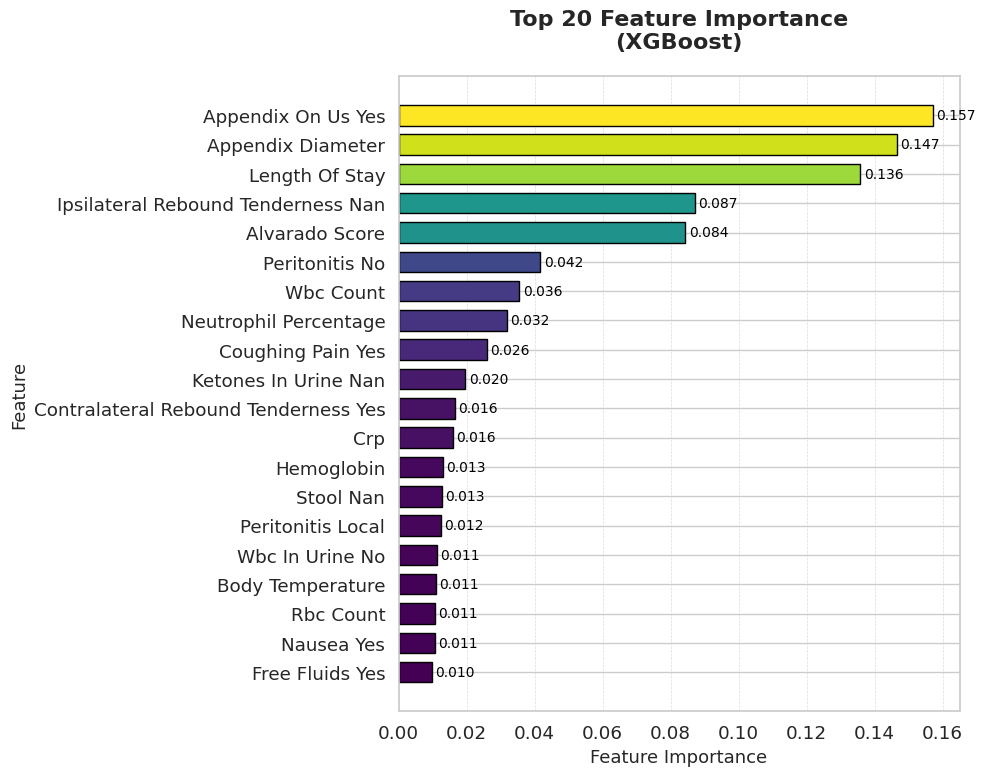

In [127]:
plot_model_importance("XGBoost", top_n=20)


> Missing values in categorical variables were handled implicitly during preprocessing using One-Hot Encoding with handle_unknown="ignore". This allowed missingness itself to be treated as an informative feature rather than being imputed or discarded. In clinical settings, the absence of information (e.g., no ultrasound performed) can be highly predictive of patient outcomes, and this approach preserved that potential signal. As a result, some derived features with "NaN" suffixes appeared among the most important predictors in models such as Elastic Net and XGBoost. These findings highlight that missingness carried independent clinical meaning rather than representing noise, further supporting the decision to encode rather than impute categorical missing data.

XGBoost most important predictors
1. Appendix visibility on ultrasound:
Detection strongly increased
appendicitis likelihood.
2. Appendix diameter: Larger
appendix diameters were
associated with a greater chance of
appendicitis.
3. Length of stay: Longer hospital stays correlated with higher likelihood of appendicitis.
4. Ipsilateral rebound tenderness: Absence of tenderness suggested lower appendicitis risk.
5. Alvarado Score: Higher scores (based on symptoms, signs, and labs) indicated greater probability of appendicitis.

# **5. DEPLOYMENT**

RELOAD DATA FROM HERE IF REQUIRED

In [2]:
# ---- Load and Prepare Raw Data ---- #
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

# fetch dataset
regensburg_pediatric_appendicitis = fetch_ucirepo(id=938)

X = regensburg_pediatric_appendicitis.data.features
y = regensburg_pediatric_appendicitis.data.targets
missing_percent = X.isnull().mean() * 100
cols_to_drop = missing_percent[missing_percent > 50].index
X = X.drop(columns=cols_to_drop)
y_full = y.copy()
y = y_full['Diagnosis']
valid_idx = y.notnull()

# Filter both X and y
X = X[valid_idx]
y = y[valid_idx]
y_full = y_full[valid_idx]


# Encoding functions
def encode_diagnosis_labels(y):
    if isinstance(y, (pd.Series, np.ndarray)):
        unique_labels = np.unique(y)
        if "appendicitis" in unique_labels and "no appendicitis" in unique_labels:
            print("Converting 'appendicitis' to 1 and 'no appendicitis' to 0...")
            return pd.Series(y).replace({"appendicitis": 1, "no appendicitis": 0})
        elif sorted(unique_labels) == [0, 1]:
            print("✔ Labels already correctly encoded (0=No Appendicitis, 1=Appendicitis).")
            return pd.Series(y)
        else:
            print(f"⚠ Warning: Unexpected labels {unique_labels}. Please check!")
            return pd.Series(y)
    else:
        raise TypeError("Input must be a pandas Series or numpy array.")

# Select only patients who were diagnosed with appendicitis
appendicitis_patients = y_full["Diagnosis"] == "appendicitis"

# Filter severity dataset
X_severity = X[appendicitis_patients]
y2 = y_full["Severity"][appendicitis_patients]

# Encode severity labels
def encode_binary_labels(y):
    if isinstance(y, (pd.Series, np.ndarray)):
        unique_labels = np.unique(y)
        if "complicated" in unique_labels and "uncomplicated" in unique_labels:
            print(" Converting 'complicated' to 1 and 'uncomplicated' to 0...")
            return pd.Series(y).replace({"complicated": 1, "uncomplicated": 0})
        elif sorted(unique_labels) == [0, 1]:
            print("✔ Labels are already correctly encoded (0=uncomplicated, 1=complicated).")
            return pd.Series(y)
        else:
            print(f"⚠ Warning: Unexpected labels {unique_labels}. Please check!")
            return pd.Series(y)
    else:
        raise TypeError("Input must be a pandas Series or numpy array.")

# Encode
y = encode_diagnosis_labels(y)
y2 = encode_binary_labels(y2)

# Final DataFrames
df = pd.concat([X, y], axis=1)

# For severity task
X_severity = X[y == 1]
y_severity = y2[y == 1]


Converting 'appendicitis' to 1 and 'no appendicitis' to 0...
 Converting 'complicated' to 1 and 'uncomplicated' to 0...


## 5.1 XGBoost re-trained on 100 % of data

In [4]:
# ================================
#  1. Retrain XGBoost Models
# ================================

import xgboost as xgb
import pickle
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

n_neighbors = 5
random_state = 42

# Split columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()
raw_feature_names = X.columns.tolist()

# --- Diagnosis preprocessing ---
X_diag = X.copy()
knn_imputer_diag = KNNImputer(n_neighbors=n_neighbors)
X_diag[num_cols] = knn_imputer_diag.fit_transform(X_diag[num_cols])

preprocessor_diag = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
])
X_diag_processed = preprocessor_diag.fit_transform(X_diag)

# --- Severity preprocessing ---
X_sev = X_severity.copy()
knn_imputer_sev = KNNImputer(n_neighbors=n_neighbors)
X_sev[num_cols] = knn_imputer_sev.fit_transform(X_sev[num_cols])

preprocessor_sev = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
])
X_sev_processed = preprocessor_sev.fit_transform(X_sev)

# --- Train models ---
diagnosis_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1,
                                   use_label_encoder=False, eval_metric="logloss", random_state=random_state)
diagnosis_model.fit(X_diag_processed, y.values.ravel())

severity_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1,
                                  use_label_encoder=False, eval_metric="logloss", random_state=random_state)
severity_model.fit(X_sev_processed, y2.values.ravel())

# --- Save everything ---
with open("diagnosis_model.pkl", "wb") as f:
    pickle.dump(diagnosis_model, f)
with open("severity_model.pkl", "wb") as f:
    pickle.dump(severity_model, f)
with open("diagnosis_preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor_diag, f)
with open("severity_preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor_sev, f)
with open("raw_feature_names.pkl", "wb") as f:
    pickle.dump(raw_feature_names, f)
with open("num_cols.pkl", "wb") as f:
    pickle.dump(num_cols, f)
with open("cat_cols.pkl", "wb") as f:
    pickle.dump(cat_cols, f)
with open("knn_imputer_diag.pkl", "wb") as f:
    pickle.dump(knn_imputer_diag, f)

with open("knn_imputer_sev.pkl", "wb") as f:
    pickle.dump(knn_imputer_sev, f)


print(" All models, preprocessors, and feature info saved!")



 All models, preprocessors, and feature info saved!


XGBoost retrained on 100% of the data for the app with the optimised hyperparameters.

In [5]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.0 MB/s eta 0:00:00


## 5.2 Web App - Appendicitis Tool

In [6]:
import gradio as gr

# Load everything
with open("diagnosis_model.pkl", "rb") as f:
    diagnosis_model = pickle.load(f)
with open("severity_model.pkl", "rb") as f:
    severity_model = pickle.load(f)
with open("diagnosis_preprocessor.pkl", "rb") as f:
    diagnosis_preprocessor = pickle.load(f)
with open("severity_preprocessor.pkl", "rb") as f:
    severity_preprocessor = pickle.load(f)
with open("raw_feature_names.pkl", "rb") as f:
    raw_feature_names = pickle.load(f)
with open("num_cols.pkl", "rb") as f:
    num_cols = pickle.load(f)
with open("cat_cols.pkl", "rb") as f:
    cat_cols = pickle.load(f)
with open("knn_imputer_diag.pkl", "rb") as f:
    knn_imputer_diag = pickle.load(f)

import gradio as gr

# Predict function
def predict_appendicitis(
    age, bmi, height, weight, length_of_stay,
    alvarado_score, appendix_diameter, body_temperature, wbc_count, neutrophil_percentage,
    rbc_count, hemoglobin, rdw, thrombocyte_count, crp,
    sex, appendix_on_us, migratory_pain, lower_right_abd_pain, contralateral_rebound_tenderness,
    coughing_pain, nausea, loss_of_appetite, neutrophilia,
    ketones_in_urine, rbc_in_urine, wbc_in_urine, dysuria,
    stool, peritonitis, psoas_sign, ipsilateral_rebound_tenderness, us_performed, free_fluids,
    pas_score
):
    input_data = {
        "Age": age, "BMI": bmi, "Height": height, "Weight": weight, "Length_of_Stay": length_of_stay,
        "Alvarado_Score": alvarado_score, "Appendix_Diameter": appendix_diameter, "Body_Temperature": body_temperature,
        "WBC_Count": wbc_count, "Neutrophil_Percentage": neutrophil_percentage, "RBC_Count": rbc_count,
        "Hemoglobin": hemoglobin, "RDW": rdw, "Thrombocyte_Count": thrombocyte_count, "CRP": crp,
        "Sex": sex, "Appendix_on_US": appendix_on_us, "Migratory_Pain": migratory_pain,
        "Lower_Right_Abd_Pain": lower_right_abd_pain, "Contralateral_Rebound_Tenderness": contralateral_rebound_tenderness,
        "Coughing_Pain": coughing_pain, "Nausea": nausea, "Loss_of_Appetite": loss_of_appetite, "Neutrophilia": neutrophilia,
        "Ketones_in_Urine": ketones_in_urine, "RBC_in_Urine": rbc_in_urine, "WBC_in_Urine": wbc_in_urine, "Dysuria": dysuria,
        "Stool": stool, "Peritonitis": peritonitis, "Psoas_Sign": psoas_sign,
        "Ipsilateral_Rebound_Tenderness": ipsilateral_rebound_tenderness, "US_Performed": us_performed,
        "Free_Fluids": free_fluids, "Paedriatic_Appendicitis_Score": pas_score
    }

    df_input = pd.DataFrame([input_data])
    df_input = df_input.reindex(columns=raw_feature_names)

    # Only transform numerics
    df_input[num_cols] = knn_imputer_diag.transform(df_input[num_cols])

    # Preprocessing
    X_diag = diagnosis_preprocessor.transform(df_input)
    X_sev = severity_preprocessor.transform(df_input)

    # Predict
    diag_probs = diagnosis_model.predict_proba(X_diag)[0]
    diag_pred = np.argmax(diag_probs)

    diag_result = "Likely Appendicitis" if diag_pred == 1 else "Unlikely Appendicitis"
    diag_confidence = f"Yes: {diag_probs[1]*100:.2f}% | No: {diag_probs[0]*100:.2f}%"

    if diag_pred == 1:
        sev_probs = severity_model.predict_proba(X_sev)[0]
        sev_pred = np.argmax(sev_probs)
        sev_result = "Complicated Appendicitis" if sev_pred == 1 else "Uncomplicated Appendicitis"
        sev_confidence = f"Complicated: {sev_probs[1]*100:.2f}% | Uncomplicated: {sev_probs[0]*100:.2f}%"
    else:
        sev_result = "N/A"
        sev_confidence = "N/A"

    return diag_result, diag_confidence, sev_result, sev_confidence

with gr.Blocks() as demo:
    gr.Markdown("<h1 style='text-align: center;'>🩺 Appendicitis Prediction App</h1>")

    with gr.Row():

        # Left side - all user inputs
        with gr.Column(scale=2):
            with gr.Accordion("🧍 Demographic", open=True):
                age = gr.Slider(1, 18, label="Age (years)")
                sex = gr.Dropdown(["male", "female"], label="Sex")
                weight = gr.Slider(10, 150, label="Weight (kg)")
                height = gr.Slider(70, 200, label="Height (cm)")
                bmi = gr.Slider(10, 50, label="BMI (kg/m²)")

            with gr.Accordion("🩺 Clinical", open=False):
                length_of_stay = gr.Slider(0, 28,step=1, label="Length of Stay (days)")
                alvarado_score = gr.Slider(0, 10, label="Alvarado Score")
                pas_score = gr.Slider(0, 10, label="Pediatric Appendicitis Score (PAS)")
                appendix_diameter = gr.Slider(2, 20, label="Appendix Diameter (mm)")
                body_temp = gr.Slider(35.0, 41.0, step=0.1, label="Body Temperature (°C)")
                migratory_pain = gr.Dropdown(["yes", "no"], label="Migratory Pain")
                lower_right_abd_pain = gr.Dropdown(["yes", "no"], label="Lower Right Abdominal Pain")
                contralat_rebound = gr.Dropdown(["yes", "no"], label="Contralateral Rebound Tenderness")
                coughing_pain = gr.Dropdown(["yes", "no"], label="Coughing Pain")
                nausea = gr.Dropdown(["yes", "no"], label="Nausea")
                loss_appetite = gr.Dropdown(["yes", "no"], label="Loss of Appetite")
                neutrophilia = gr.Dropdown(["yes", "no"], label="Neutrophilia")
                peritonitis = gr.Dropdown(["no", "local", "generalized"], label="Peritonitis")
                psoas_sign = gr.Dropdown(["yes", "no"], label="Psoas Sign")
                ipsilateral_rebound = gr.Dropdown(["yes", "no"], label="Ipsilateral Rebound Tenderness")
                us_performed = gr.Dropdown(["yes", "no"], label="Ultrasound Performed")
                appendix_on_us = gr.Dropdown(["yes", "no"], label="Appendix Visible on Ultrasound")
                free_fluids = gr.Dropdown(["yes", "no"], label="Free Fluids on Ultrasound")

            with gr.Accordion("🧪 Laboratory", open=False):
                wbc_count = gr.Slider(2.0, 35.0, step=0.1, label="WBC Count (×10⁹/L)")
                neutrophil_percentage = gr.Slider(30.0, 90.0, step=0.1, label="Neutrophil Percentage (%)")
                rbc_count = gr.Slider(3.0, 6.5, step=0.1, label="RBC Count (×10¹²/L)")
                hemoglobin = gr.Slider(8.0, 18.0, step=0.1, label="Hemoglobin (g/dL)")
                rdw = gr.Slider(11.0, 20.0, step=0.1, label="RDW (%)")
                thrombocyte_count = gr.Slider(150.0, 500.0, step=1, label="Platelet Count (×10⁹/L)")
                crp = gr.Slider(0.0, 300.0, step=1, label="C-Reactive Protein (mg/L)")
                ketones_urine = gr.Dropdown(["no", "+", "++", "+++"], label="Ketones in Urine")
                rbc_urine = gr.Dropdown(["no", "+", "++", "+++"], label="RBCs in Urine")
                wbc_urine = gr.Dropdown(["no", "+", "++", "+++"], label="WBCs in Urine")
                dysuria = gr.Dropdown(["yes", "no"], label="Dysuria")

            with gr.Accordion("🚻 Stool", open=False):
                stool = gr.Dropdown(["normal", "constipation", "diarrhea", "constipation, diarrhea"], label="Stool Appearance")

            submit_btn = gr.Button("🔍 Predict")

        # Right side - prediction output
        with gr.Column(scale=1):
            gr.Markdown("## 🔎 Prediction Results")

            diag_prediction = gr.Label(label="Diagnosis Result")
            diag_probs = gr.Label(label="Diagnosis Confidence (%)")
            severity_prediction = gr.Label(label="Severity Result")
            severity_probs = gr.Label(label="Severity Confidence (%)")

    # when submit button is pressed
    submit_btn.click(
        predict_appendicitis,
        inputs=[
            age, bmi, height, weight, length_of_stay,
            alvarado_score, appendix_diameter, body_temp,
            wbc_count, neutrophil_percentage, rbc_count, hemoglobin, rdw, thrombocyte_count, crp,
            sex, appendix_on_us, migratory_pain, lower_right_abd_pain,
            contralat_rebound, coughing_pain, nausea, loss_appetite, neutrophilia,
            ketones_urine, rbc_urine, wbc_urine, dysuria,
            stool, peritonitis, psoas_sign, ipsilateral_rebound, us_performed, free_fluids,
            pas_score
        ],
        outputs=[diag_prediction, diag_probs, severity_prediction, severity_probs]
    )


In [7]:
demo.launch(inline=False, share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8aa2c514c44f253adf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://8aa2c514c44f253adf.gradio.live


In [8]:
# shutting down the deployed model
demo.close()

Closing server running on port: 7860


To make the models accessible and interactive, a web-based tool was developed using the Gradio framework. The application allows clinicians to input relevant clinical features and receive immediate predictions for both appendicitis diagnosis and severity classification. It displays predicted class labels alongside probability scores to support informed decision-making.

The backend runs the final retrained XGBoost models, selected for their performance and consistency.

Inputs include key clinical, laboratory, and ultrasound-derived features, reflecting the variables used during model training.

The interface is designed to be intuitive, allowing for quick use in time-sensitive clinical settings.

This tool demonstrates how machine learning models can be deployed in practice to support real-time diagnosis. It forms a foundation for future development, including the possibility of a lightweight version for symptom-based home screening.

**Snippet of the tool**


<img src="https://drive.google.com/uc?export=view&id=1LJ9wEgBQI-y5vvcNoQPmBtjD2pNZibZy" alt="Monte Carlo CV Pipeline" width="800">


#### Most Important Features for Severity

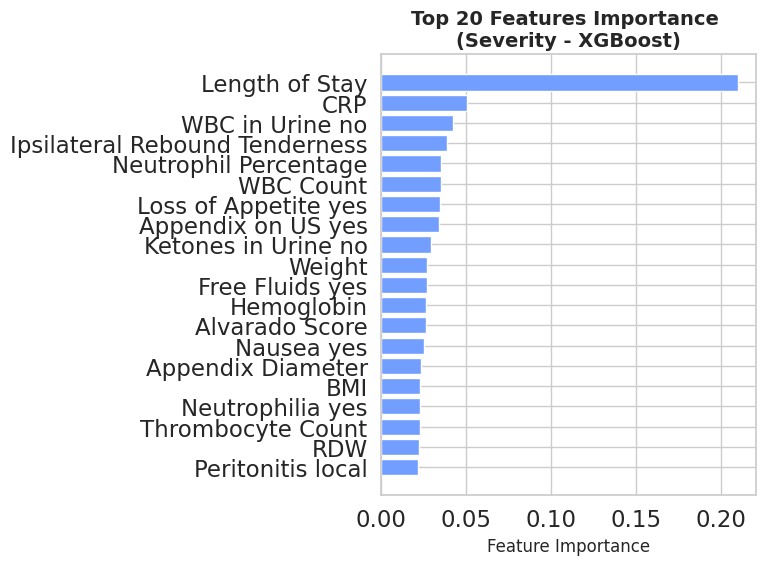

In [43]:

# --- Load saved model and preprocessor ---
with open("severity_model.pkl", "rb") as f:
    severity_model = pickle.load(f)

with open("severity_preprocessor.pkl", "rb") as f:
    severity_preprocessor = pickle.load(f)

# --- Get feature importances ---
feature_names = severity_preprocessor.get_feature_names_out()

# Clean feature names
def clean_feature_name(name):
    name = name.replace("num__", "").replace("cat__", "")  # Remove prefixes
    name = re.sub(r'_nan$', '', name)  # Remove trailing _nan if exists
    name = name.replace("_", " ")  # Replace underscores with spaces
    return name

cleaned_feature_names = [clean_feature_name(name) for name in feature_names]

importances = severity_model.feature_importances_

importance_df = pd.DataFrame({
    "Feature": cleaned_feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# --- Plot Top 15 important features ---
plt.figure(figsize=(8, 6))
plt.barh(importance_df["Feature"].head(20)[::-1], importance_df["Importance"].head(20)[::-1], color="#729fff")
plt.xlabel("Feature Importance", fontsize=12)
plt.title("Top 20 Features Importance \n(Severity - XGBoost)", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()


1. Length of Stay: Longer hospital stays were strongly
associated with complicated appendicitis (supported by
boxplot analysis). It domnates the importance in the XGBoost for severity classification.
2. CRP (C-Reactive Protein): Higher CRP levels, a marker of
inflammation, were linked to a greater likelihood of a
complicated case.

In [23]:
df_severity = X_severity.copy()
df_severity["Severity"] = y_severity

# --- Map severity 0/1 to labels if needed ---
severity_labels = {0: "Uncomplicated", 1: "Complicated"}
df_severity["Severity"] = df_severity["Severity"].map(severity_labels)


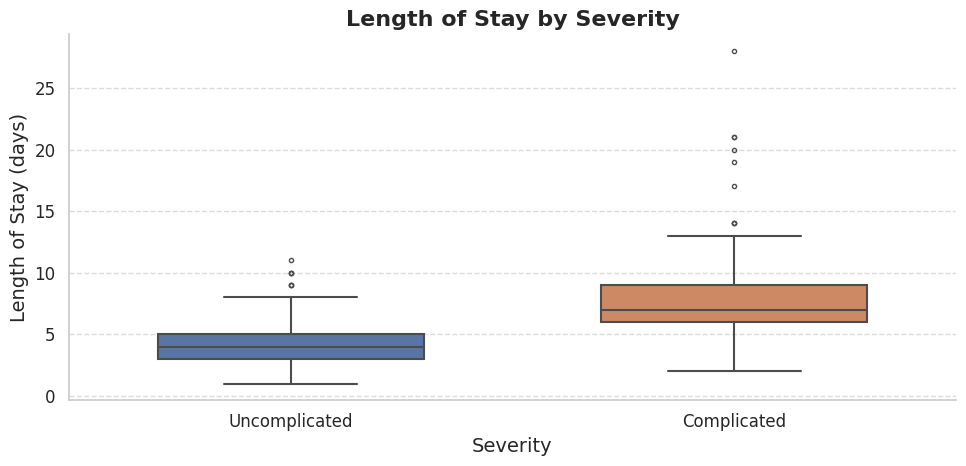

In [35]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.5)

custom_palette = {
    "Uncomplicated": "#4C72B0",  # Blue
    "Complicated": "#DD8452"     # Orange
}

plt.figure(figsize=(10, 5))
sns.boxplot(
    x=df_severity["Severity"],
    y=df_severity['Length_of_Stay'],
    palette=custom_palette,
    width=0.6,
    fliersize=3,   # Smaller outliers
    linewidth=1.5  # Thicker box edges
)

plt.title('Length of Stay by Severity', fontsize=16, weight='bold')
plt.xlabel('Severity', fontsize=14)
plt.ylabel('Length of Stay (days)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine()

plt.tight_layout()
plt.show()


The distribution of length of hospital stay is longer for patients with complicated appendicitis compared to uncomplicated cases.
This trend is clinically intuitive, as complications typically require extended monitoring, additional interventions, or more complex recovery.


# **6. CONCLUSION**

This project presented a complete machine learning pipeline to model appendicitis diagnosis and severity classification using the Regensburg Pediatric Appendicitis Dataset. A structured and reproducible approach was followed, covering data preprocessing, model development, cross-validation, feature importance analysis, and deployment via a web-based application.

### Summary of Key Steps

- **Dataset Exploration**  
  - Conducted missing data analysis and removed variables with over 50% missingness.  
  - Assessed multicollinearity, handled categorical/numerical predictors separately, and applied appropriate encoding and scaling.

- **Methodology Design**  
  - Five classification models were trained and evaluated: Logistic Regression, Elastic Net, Random Forest, XGBoost, and a Multi-Layer Perceptron (MLP) Neural Network.  
  - Monte Carlo Cross-Validation (MCCV) with 200 iterations was used to estimate model performance reliably.  
  - Metrics included mean and standard deviation of Accuracy, Precision, Recall, F1-Score, and AUC.

- **Model Selection and Deployment**  
  - **XGBoost consistently achieved the highest and most stable performance** across all metrics for diagnosis classification.  
  - For severity prediction, the Neural Network achieved the highest mean F1-score but showed greater variance across validation folds.  
  - XGBoost was selected for deployment in both tasks due to its consistent performance and generalisability.  
  - Final models were retrained on the full dataset and deployed using a **Gradio web application** for real-time predictions.

- **Key Findings**  
  - **“Appendix on US”** (detectability) and **“Appendix Diameter”** were identified as the most important predictors for appendicitis diagnosis.  
  - **“Length of Stay”** emerged as a key indicator for severity classification, capturing clinical progression.  
  - Machine learning models, when properly validated and interpreted, can effectively support diagnostic decision-making in clinical settings.  
  - XGBoost offered a strong balance of accuracy, AUC, and F1-score, while also demonstrating stability across MCCV splits.

- **Reflections**  
  - Machine learning provides a promising foundation for data-driven support in pediatric appendicitis diagnosis and triage.  
  - Preprocessing choices: including handling of missing values, encoding, and feature selection, were essential to ensure model reliability.  
  - Combining strong predictive performance with interpretable feature importance increases clinical trust and facilitates real-world integration.

### **Limitations and Future Work**

- The current tool relies on features that are only available after clinical imaging and lab results, limiting its use to clinical environments. Future work should focus on developing a **lightweight model using only symptoms and demographic data** to enable **preliminary risk screening at home**.
- The dataset is drawn from a single institution, which may limit generalisability. **External validation on data from other hospitals or populations** is needed to assess broader applicability.
- While model interpretability was partially addressed through feature importance, additional explainability tools (e.g., SHAP values) could help increase transparency for end users.

---

This project demonstrates the feasibility of building accurate and practical diagnostic models from structured clinical data and highlights the potential of machine learning to improve pediatric healthcare decision-making when carefully validated and implemented.


# References

* [Interpretable and Intervenable Ultrasonography-based Machine Learning Models for Pediatric Appendicitis, Ričards Marcinkevičs & et al, Published in Medical Image Analysis 2023](https://arxiv.org/abs/2302.14460v2)

* [Regensburg Pediatric Appendicitis Dataset](https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis)

* [Aurelien Geron - Hands-on machine learning with scikit-learn, keras, and tensorflow: concepts, tools, and techniques to build intelligent systems](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)
* [Gareth James, Daniela Witten, Trevor Hastie - An Introduction to Statistical Learning](https://www.statlearning.com/)
* [Max Kuhn, Kjell Johnson - Applied Predictive Modeling](https://link.springer.com/book/10.1007/978-1-4614-6849-3)
* [Ewout W. Steyerberg - Clinical Prediction Models](https://link.springer.com/book/10.1007/978-3-030-16399-0)
* [Frank E. Harrell, Jr - Regression Modeling Strategies](https://link.springer.com/book/10.1007/978-3-319-19425-7)